# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [171]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


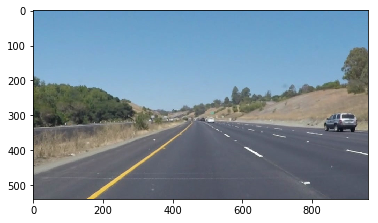

In [172]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [289]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    line_image = np.zeros_like(img)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    return cv2.addWeighted(img, 1.0, line_image, 0.95, 0.0)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
   # line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
   # draw_lines(line_img, lines)
   # return line_img
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



## Custom Functions


In [315]:
def separate_lines(lines):
    """ Takes an array of hough lines and separates them by +/- slope.
        The y-axis is inverted in matplotlib, so the calculated positive slopes will be right
        lane lines and negative slopes will be left lanes. """
    right = []
    left = []
    for x1,y1,x2,y2 in lines[:, 0]:
        m = (float(y2) - y1) / (x2 - x1)
        if m >= 0: 
            right.append([x1,y1,x2,y2,m])
        else:
            left.append([x1,y1,x2,y2,m])
    
    return right, left

#Two lane lines: left and the other right. 
#The left lane should have a positive slope, and the right lane should have a negative slope. 
# for each left and right lanes collect positive slope/lines and negative slope/lines separately and take averages
# return slope and intercept
def average_slope_intercept(lines):
    # holder slope and intercept
    left_slope    = [] 
    right_slope   = [] 
    #Line length
    left_lengths  = [] 
    right_lengths = [] 
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue 
            # calculate the slope, intercept and line length
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            # in the image, y coordinate is reversed. 
            # The higher y value is actually lower in the image.
            if slope < 0: 
                left_slope.append((slope, intercept))
                left_lengths.append((length))
            else:
                right_slope.append((slope, intercept))
                right_lengths.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_lengths,  left_slope) /np.sum(left_lengths)  if len(left_lengths) >0 else None
    right_lane = np.dot(right_lengths, right_slope)/np.sum(right_lengths) if len(right_lengths)>0 else None
    
    return left_lane, right_lane 

# convert the slope and intercept into pixel points
def make_line_points(y1, y2, line):
   
    if line is None:
        return None
    
    slope, intercept = line
    
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

#Each line is a list of 4 values (x1, y1, x2, y2)
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

def mean_line(line, lines):
    if line is not None:
        lines.append(line)

    if len(lines)>0:
        line = np.mean(lines, axis=0, dtype=np.int32)
        line = tuple(map(tuple, line)) # make sure it's tuples not numpy array for cv2.line to work
    return line

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [267]:
import os
files = os.listdir("test_images/")
print(files)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [322]:
def process_test_image(image):
    
    # grayscale the image
    gray = grayscale(image)
   
    #apply Gaussian smoothing
    kernel_size=5
    blur_gray = gaussian_blur(gray,kernel_size)
    
     #apply canny edges
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Define the polygon
    imshape = image.shape
    x_dim = np.shape(image)[1]
    y_dim = np.shape(image)[0]
    vertices = np.array([[(10,y_dim-50),(x_dim-10,y_dim-50),(x_dim/2+40,y_dim/1.65),(x_dim/2-40,y_dim/1.65)]],
                      dtype = np.int32)
    roi = region_of_interest(edges, vertices)
    plt.imshow(roi)

    # Hough transform parameters
    rho = 2 
    theta = np.pi/180 
    threshold = 20    
    min_line_length = 20 
    max_line_gap = 300  
    
    # creating a blank to draw lines on
    line_image = np.copy(image)*0

    # Run Hough on edge detected image 
    lines = hough_lines(roi, rho, theta, threshold, min_line_length, max_line_gap)
    
    #get the slope of intercept of left and right lanes
    left_line, right_line = separate_lines(lines)
        
    #lines = np.concatenate((right_line, left_line))
    #lines_img = np.zeros(img.shape, dtype=np.uint8)
   # lines_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
   
    # Iterate over the output "lines" and draw lines on a blank image
    lines_edges = draw_lines(line_image, lines, [255, 0, 0], 10)
    
    lane_images = []
    
    # draw lines on final image
    #lines_edges = weighted_img(lines,image)
    final_img = weighted_img(lines_edges, img)
    
    return final_img
 


## Testing a Lane Finding Pipeline


solidWhiteCurve.jpg


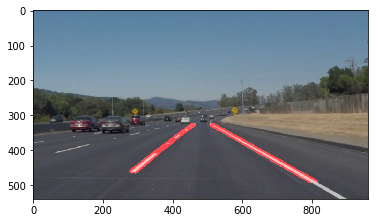

solidWhiteRight.jpg


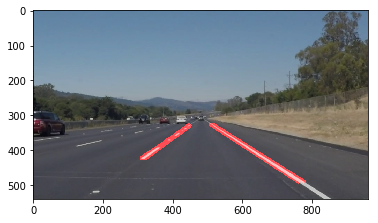

solidYellowCurve.jpg


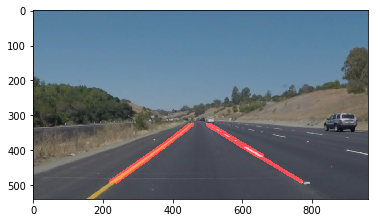

solidYellowCurve2.jpg


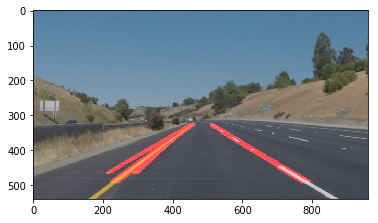

solidYellowLeft.jpg


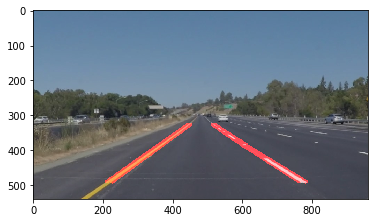

whiteCarLaneSwitch.jpg


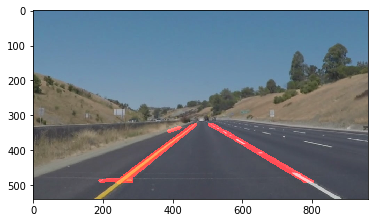

In [323]:

#pipeline for images in the directory 'test_images'
for test_image in files:
    img = mpimg.imread('test_images/' + test_image)
    print(test_image)
    pImage = process_test_image(img)
    mpimg.imsave('test_images_output/final-' + test_image, pImage)
    plt.imshow(pImage)
    plt.show()



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [189]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [54]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # Grayscale the image
   
    return lines_edges

Let's try the one with the solid white lane on the right first ...

[[519 327 771 490]]
[[234 490 451 327]]
[[590 369 718 448]]
[[624 389 782 487]]
[[249 467 446 329]]
[[514 327 573 365]]
[[219 490 427 339]]
[[558 350 612 389]]
[[740 460 786 489]]
[[522 328 770 489]]
[[550 345 628 399]]
[[393 369 444 328]]
[[581 364 651 414]]
[[518 327 588 374]]
[[542 340 667 424]]
[[218 490 248 468]]
[[248 481 400 358]]
[[724 461 768 489]]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 4/222 [00:00<00:06, 35.86it/s]

[[519 327 771 490]]
[[234 490 451 327]]
[[590 369 718 448]]
[[624 389 782 487]]
[[249 467 446 329]]
[[514 327 573 365]]
[[219 490 427 339]]
[[558 350 612 389]]
[[740 460 786 489]]
[[522 328 770 489]]
[[550 345 628 399]]
[[393 369 444 328]]
[[581 364 651 414]]
[[518 327 588 374]]
[[542 340 667 424]]
[[218 490 248 468]]
[[248 481 400 358]]
[[724 461 768 489]]
[[518 327 770 490]]
[[217 490 445 330]]
[[513 328 735 457]]
[[541 341 647 403]]
[[234 490 450 327]]
[[564 360 788 490]]
[[265 455 447 327]]
[[547 349 640 399]]
[[539 344 656 409]]
[[238 488 442 329]]
[[613 390 756 470]]
[[573 365 666 415]]
[[525 330 580 365]]
[[347 396 446 327]]
[[518 327 789 490]]
[[567 362 771 490]]
[[550 351 652 413]]
[[233 478 446 328]]
[[234 490 444 332]]
[[662 421 724 459]]
[[513 327 546 347]]
[[619 394 661 419]]
[[217 490 450 327]]
[[252 467 441 330]]
[[341 407 430 342]]
[[512 327 604 383]]
[[653 415 788 490]]
[[521 328 749 465]]
[[512 327 769 488]]
[[517 327 789 490]]
[[519 327 790 490]]
[[322 414 447 327]]


  6%|▌         | 13/222 [00:00<00:05, 34.90it/s]

[[511 327 658 422]]
[[515 327 786 490]]
[[575 367 741 474]]
[[289 438 448 327]]
[[299 440 445 330]]
[[607 383 767 490]]
[[289 439 454 327]]
[[522 330 679 435]]
[[637 401 665 419]]
[[289 441 453 327]]
[[665 418 732 468]]
[[507 327 693 447]]
[[557 355 781 490]]
[[579 372 762 490]]
[[263 459 451 327]]
[[271 461 456 327]]
[[272 461 454 329]]
[[518 331 567 360]]
[[578 372 672 425]]
[[514 327 709 448]]
[[265 458 445 332]]
[[511 327 700 445]]
[[506 327 758 490]]
[[242 484 447 335]]
[[230 483 316 421]]
[[722 457 768 486]]
[[237 485 455 327]]
[[366 386 451 329]]
[[686 435 718 456]]
[[514 333 716 464]]
[[243 484 451 327]]
[[556 355 618 393]]
[[230 482 423 352]]
[[513 328 545 347]]
[[749 473 776 490]]
[[231 485 405 359]]
[[233 479 373 388]]
[[699 443 719 456]]
[[514 328 772 489]]
[[235 487 455 327]]
[[508 328 757 490]]
[[217 490 450 327]]
[[507 327 572 368]]
[[527 340 592 381]]
[[232 490 271 462]]
[[630 408 753 488]]
[[306 433 452 327]]
[[220 487 447 328]]
[[514 327 775 490]]
[[570 368 622 401]]


  9%|▉         | 21/222 [00:00<00:05, 36.36it/s]


[[521 327 782 490]]
[[598 381 664 423]]
[[521 331 611 388]]
[[312 424 442 329]]
[[304 423 439 328]]
[[639 408 694 443]]
[[594 378 777 488]]
[[314 424 442 331]]
[[305 424 441 329]]
[[516 327 584 370]]
[[527 331 781 490]]
[[305 423 440 328]]
[[520 327 781 490]]
[[515 327 687 439]]
[[282 437 441 330]]
[[721 463 763 490]]
[[363 389 442 332]]
[[700 449 732 469]]
[[358 392 425 342]]
[[523 328 664 416]]
[[673 431 699 447]]
[[286 439 442 330]]
[[643 411 682 436]]
[[283 438 442 331]]
[[688 441 711 455]]
[[514 328 759 488]]
[[518 327 779 490]]
[[514 327 655 419]]
[[256 456 447 327]]
[[264 459 441 335]]
[[340 399 439 332]]
[[704 453 754 485]]
[[261 459 450 327]]
[[530 335 778 490]]
[[256 459 440 335]]
[[517 327 778 490]]
[[519 333 760 490]]
[[233 485 449 328]]
[[220 482 440 334]]
[[530 340 617 395]]
[[358 396 447 327]]
[[337 411 409 353]]
[[511 327 562 359]]
[[604 388 641 411]]
[[228 486 440 337]]
[[624 401 687 441]]
[[219 485 449 330]]
[[516 327 550 349]]
[[226 486 446 327]]
[[515 327 776 490]]

 14%|█▎        | 30/222 [00:00<00:04, 39.83it/s]

[[519 328 776 489]]
[[526 337 759 489]]
[[229 490 443 329]]
[[211 490 446 331]]
[[231 489 433 342]]
[[562 360 777 490]]
[[665 428 760 490]]
[[513 328 584 373]]
[[306 429 434 340]]
[[518 327 726 457]]
[[276 447 445 329]]
[[305 429 407 360]]
[[213 489 367 389]]
[[602 386 639 409]]
[[247 477 446 332]]
[[518 327 778 490]]
[[544 349 760 490]]
[[565 361 658 423]]
[[213 489 445 332]]
[[236 486 445 329]]
[[520 331 561 360]]
[[213 490 433 342]]
[[284 444 445 327]]
[[630 404 776 489]]
[[648 416 690 443]]
[[230 489 433 341]]
[[520 327 563 361]]
[[514 327 538 345]]
[[229 490 432 343]]
[[520 333 761 490]]
[[517 327 778 490]]
[[213 490 446 327]]
[[518 327 779 490]]
[[230 490 432 343]]
[[260 465 451 327]]
[[377 377 443 334]]
[[519 332 569 364]]
[[345 406 443 333]]
[[259 465 449 327]]
[[377 376 429 341]]
[[216 489 430 344]]
[[613 393 640 410]]
[[528 334 777 490]]
[[532 341 761 490]]
[[326 416 449 327]]
[[518 327 779 490]]
[[323 413 451 327]]
[[512 327 543 347]]
[[219 490 452 327]]
[[328 416 428 346]]


 18%|█▊        | 40/222 [00:01<00:04, 40.97it/s]

[[292 435 435 338]]
[[528 337 574 362]]
[[298 437 353 400]]
[[308 433 385 371]]
[[295 437 444 329]]
[[712 458 754 485]]
[[686 432 728 459]]
[[531 336 777 490]]
[[512 327 602 386]]
[[267 452 446 327]]
[[342 409 448 329]]
[[592 381 663 426]]
[[650 419 740 476]]
[[278 455 411 358]]
[[713 460 760 489]]
[[268 455 446 330]]
[[537 344 563 361]]
[[518 327 632 401]]
[[269 455 330 409]]
[[578 372 667 422]]
[[636 410 678 436]]
[[280 453 444 330]]
[[519 327 539 340]]
[[267 453 380 380]]
[[270 455 410 353]]
[[513 327 536 342]]
[[563 362 648 410]]
[[548 352 760 490]]
[[538 341 776 490]]
[[511 327 544 348]]
[[247 478 412 358]]
[[237 475 300 430]]
[[554 352 775 490]]
[[236 478 319 418]]
[[518 328 550 348]]
[[240 478 448 327]]
[[242 478 447 329]]
[[733 474 758 490]]
[[235 475 445 328]]
[[239 478 423 349]]
[[565 363 599 385]]
[[256 472 302 439]]
[[244 478 447 330]]
[[641 414 691 446]]
[[533 342 575 369]]
[[552 355 759 490]]
[[233 490 446 330]]
[[547 347 776 490]]
[[216 489 430 344]]
[[510 327 637 410]]


 20%|██        | 45/222 [00:01<00:04, 39.52it/s]


[[520 327 675 427]]
[[516 327 758 490]]
[[259 460 437 331]]
[[687 433 776 490]]
[[515 327 741 479]]
[[366 389 439 330]]
[[668 421 710 449]]
[[272 458 441 331]]
[[257 459 402 361]]
[[627 395 759 490]]
[[265 458 440 331]]
[[257 458 421 343]]
[[269 458 449 327]]
[[525 329 737 466]]
[[518 328 759 490]]
[[523 328 712 450]]
[[708 446 777 490]]
[[242 481 447 327]]
[[225 484 436 331]]
[[700 441 747 472]]
[[515 327 699 451]]
[[223 484 415 345]]
[[231 481 438 331]]
[[239 481 433 335]]
[[234 481 439 332]]
[[514 327 776 490]]
[[324 420 448 327]]
[[521 327 715 462]]
[[544 341 758 490]]
[[314 419 434 332]]
[[557 354 648 417]]
[[323 420 436 332]]
[[558 356 652 411]]
[[581 365 672 433]]
[[596 375 651 419]]
[[313 418 385 366]]
[[546 348 701 442]]
[[699 441 751 474]]
[[570 364 625 394]]
[[554 349 660 416]]
[[517 328 777 490]]
[[554 349 756 476]]
[[542 344 626 402]]
[[304 434 434 333]]
[[530 332 728 470]]
[[295 431 449 327]]
[[551 347 647 416]]
[[528 335 573 366]]
[[581 365 668 430]]
[[341 398 445 328]]

 22%|██▏       | 49/222 [00:01<00:05, 34.29it/s]

[[210 490 444 327]]
[[524 333 758 490]]
[[546 343 749 474]]
[[227 490 313 427]]
[[312 425 445 328]]
[[522 328 572 361]]
[[753 475 777 490]]
[[253 470 446 329]]
[[306 425 442 330]]
[[514 327 718 464]]
[[569 358 757 489]]
[[721 455 745 471]]
[[745 470 765 484]]
[[310 424 415 345]]
[[546 347 758 490]]
[[522 328 722 457]]
[[210 490 441 328]]
[[516 328 757 490]]
[[261 465 444 328]]
[[682 430 741 469]]
[[238 482 397 358]]
[[740 467 771 488]]
[[519 327 539 340]]
[[209 490 439 329]]
[[252 470 445 329]]
[[520 327 608 384]]
[[288 439 442 331]]
[[612 385 659 416]]
[[248 474 290 439]]
[[598 378 776 490]]
[[519 327 651 419]]
[[531 334 715 462]]
[[520 332 631 397]]
[[208 490 444 331]]
[[602 379 739 478]]
[[226 490 389 363]]
[[513 327 594 374]]
[[545 348 651 410]]
[[549 345 657 423]]
[[260 458 424 339]]
[[228 489 442 328]]
[[650 410 757 490]]
[[235 471 380 376]]
[[225 490 442 332]]
[[522 328 581 372]]
[[541 344 758 490]]
[[540 339 718 454]]
[[636 400 775 490]]
[[228 481 443 331]]
[[514 327 717 463]]


 26%|██▌       | 57/222 [00:01<00:05, 28.05it/s]

[[520 327 556 351]]
[[662 426 777 490]]
[[304 423 441 330]]
[[302 422 443 327]]
[[683 440 766 483]]
[[520 331 675 425]]
[[313 423 420 342]]
[[719 453 741 468]]
[[313 419 442 332]]
[[557 355 601 379]]
[[517 327 750 473]]
[[606 389 720 464]]
[[511 327 589 376]]
[[575 368 775 489]]
[[281 436 443 327]]
[[518 327 694 437]]
[[683 440 759 490]]
[[293 437 440 331]]
[[283 436 423 342]]
[[590 378 631 404]]
[[603 387 640 410]]
[[282 439 448 327]]
[[281 437 442 328]]
[[721 466 757 489]]
[[640 411 776 490]]
[[511 327 688 442]]
[[517 327 766 483]]
[[253 457 393 359]]
[[269 455 446 327]]
[[677 436 719 463]]
[[265 455 441 328]]
[[732 473 759 490]]
[[665 428 777 490]]
[[518 327 702 442]]
[[514 328 608 389]]
[[254 456 439 331]]
[[701 452 722 465]]
[[253 455 444 327]]
[[726 469 746 481]]
[[262 455 443 328]]
[[255 457 448 327]]
[[628 404 770 486]]
[[346 399 410 348]]
[[682 439 761 480]]
[[515 327 776 490]]
[[521 333 657 424]]
[[234 480 445 327]]
[[577 364 757 490]]
[[546 345 704 455]]
[[218 481 444 329]]


 30%|██▉       | 66/222 [00:01<00:04, 31.98it/s]


[[220 490 441 330]]
[[520 332 698 444]]
[[662 430 736 479]]
[[205 490 445 328]]
[[589 381 769 490]]
[[210 485 453 327]]
[[567 366 737 469]]
[[514 328 571 363]]
[[625 405 652 422]]
[[266 447 403 361]]
[[724 472 751 489]]
[[621 402 693 441]]
[[659 428 748 476]]
[[353 389 452 327]]
[[259 463 399 358]]
[[653 424 712 453]]
[[508 327 749 489]]
[[513 327 661 420]]
[[226 486 446 327]]
[[678 431 744 475]]
[[204 490 445 328]]
[[634 411 707 459]]
[[219 490 452 327]]
[[609 394 768 490]]
[[664 422 752 490]]
[[264 448 448 328]]
[[569 367 640 407]]
[[202 490 453 327]]
[[552 351 748 488]]
[[600 388 680 433]]
[[729 464 754 481]]
[[591 382 656 417]]
[[633 410 726 462]]
[[511 330 673 428]]
[[562 362 752 490]]
[[586 373 766 489]]
[[204 490 447 327]]
[[531 338 593 379]]
[[252 465 448 328]]
[[540 348 594 385]]
[[220 490 373 375]]
[[637 405 768 490]]
[[698 455 751 490]]
[[508 327 750 490]]
[[250 464 453 327]]
[[569 362 625 399]]
[[233 469 451 327]]
[[514 327 589 381]]
[[204 489 339 405]]
[[508 327 750 490]]

 34%|███▍      | 76/222 [00:02<00:03, 36.74it/s]

[[509 327 751 490]]
[[515 327 722 461]]
[[701 446 770 490]]
[[314 420 447 327]]
[[306 418 409 349]]
[[690 439 749 478]]
[[311 420 444 327]]
[[308 420 411 348]]
[[594 384 628 406]]
[[516 327 768 490]]
[[514 327 544 347]]
[[310 416 430 338]]
[[307 420 447 329]]
[[652 423 706 459]]
[[515 327 767 490]]
[[509 327 751 490]]
[[296 433 446 328]]
[[286 433 443 327]]
[[510 328 750 490]]
[[304 428 446 329]]
[[518 329 596 381]]
[[632 402 768 490]]
[[287 433 444 327]]
[[289 430 324 406]]
[[514 327 568 363]]
[[511 327 734 478]]
[[515 327 723 462]]
[[516 327 768 490]]
[[273 449 445 329]]
[[262 449 442 328]]
[[696 454 751 490]]
[[261 449 325 405]]
[[648 421 722 470]]
[[510 327 578 374]]
[[262 448 290 428]]
[[544 350 605 392]]
[[262 446 408 355]]
[[272 449 370 375]]
[[519 330 622 397]]
[[512 329 751 490]]
[[650 413 733 468]]
[[243 469 444 329]]
[[230 467 444 328]]
[[718 457 762 487]]
[[637 405 690 440]]
[[515 327 545 346]]
[[241 470 401 354]]
[[646 419 769 490]]
[[616 392 750 489]]
[[230 470 441 328]]


 36%|███▌      | 80/222 [00:02<00:03, 36.48it/s]

[[525 335 753 484]]
[[510 327 743 490]]
[[341 399 441 327]]
[[333 398 437 335]]
[[516 328 544 347]]
[[555 360 762 490]]
[[543 352 736 473]]
[[370 380 446 327]]
[[263 454 413 345]]
[[522 337 558 361]]
[[253 454 439 329]]
[[654 420 744 490]]
[[511 327 762 490]]
[[510 327 743 490]]
[[230 477 443 328]]
[[319 406 446 327]]
[[512 329 562 365]]
[[524 334 547 349]]
[[218 477 432 333]]
[[221 477 442 328]]
[[545 352 604 394]]
[[515 327 691 445]]
[[217 475 363 383]]
[[227 477 434 337]]
[[219 477 390 366]]
[[510 327 743 490]]
[[511 327 722 464]]
[[303 418 435 335]]
[[302 417 441 327]]
[[310 419 355 390]]
[[706 454 744 480]]
[[524 334 631 404]]
[[726 467 752 485]]
[[303 417 433 333]]
[[512 328 744 490]]
[[654 420 695 448]]
[[309 419 445 328]]
[[535 346 683 439]]
[[511 327 706 454]]
[[515 331 742 490]]
[[294 422 444 328]]
[[294 431 408 349]]
[[282 430 380 372]]
[[709 456 757 489]]
[[515 327 539 343]]
[[510 327 574 367]]
[[285 432 445 328]]
[[562 365 756 487]]
[[291 432 345 397]]
[[312 411 341 394]]


 40%|███▉      | 88/222 [00:02<00:04, 31.40it/s]

[[511 327 735 473]]
[[521 335 742 490]]
[[227 466 441 327]]
[[236 469 443 330]]
[[226 469 443 328]]
[[530 338 623 399]]
[[562 365 756 487]]
[[242 457 443 327]]
[[512 327 548 349]]
[[651 427 760 490]]
[[523 337 741 490]]
[[511 327 686 441]]
[[189 490 430 340]]
[[210 489 354 385]]
[[522 336 759 490]]
[[228 475 302 426]]
[[382 365 442 329]]
[[526 335 560 358]]
[[275 435 359 388]]
[[208 490 353 385]]
[[542 350 641 412]]
[[593 387 733 472]]
[[382 367 442 330]]
[[563 366 675 434]]
[[297 424 440 328]]
[[191 490 300 427]]
[[621 405 692 445]]
[[387 368 443 328]]
[[517 327 742 490]]
[[235 462 292 424]]
[[510 327 717 472]]
[[516 327 758 490]]
[[525 334 694 448]]
[[190 490 428 341]]
[[534 345 741 490]]
[[218 482 442 331]]
[[271 448 408 349]]
[[207 490 272 447]]
[[191 490 349 395]]
[[276 438 440 328]]
[[567 369 634 414]]
[[376 370 442 330]]
[[517 327 740 489]]
[[551 357 741 490]]
[[194 489 441 329]]
[[510 327 748 482]]
[[529 341 758 490]]
[[208 490 440 333]]
[[511 327 558 356]]
[[191 490 410 353]]


 41%|████▏     | 92/222 [00:02<00:04, 27.34it/s]

[[525 337 736 475]]
[[557 361 741 490]]
[[286 437 449 327]]
[[344 391 439 332]]
[[512 327 560 357]]
[[539 348 581 372]]
[[522 331 758 490]]
[[594 388 738 489]]
[[278 437 366 378]]
[[556 360 590 378]]
[[576 374 706 456]]
[[274 437 451 327]]
[[285 437 443 327]]
[[524 335 574 367]]
[[280 438 445 327]]
[[511 327 714 463]]
[[558 362 740 490]]
[[334 399 449 327]]
[[350 396 446 327]]
[[713 461 754 489]]
[[516 327 537 341]]
[[646 416 720 467]]
[[527 339 571 365]]
[[540 349 586 376]]
[[247 456 437 337]]
[[538 342 567 368]]
[[257 456 372 381]]
[[544 352 579 376]]
[[249 458 450 328]]
[[247 457 445 328]]
[[603 395 738 490]]
[[254 456 420 349]]
[[510 327 640 412]]
[[532 343 553 353]]
[[541 345 756 490]]
[[510 327 632 415]]
[[521 333 738 490]]
[[225 479 449 328]]
[[212 479 446 327]]
[[516 327 757 490]]
[[580 371 739 490]]
[[346 399 432 337]]
[[518 332 548 353]]
[[214 482 445 327]]
[[630 406 653 422]]
[[322 407 418 350]]
[[512 327 683 451]]
[[514 328 755 490]]
[[512 327 665 438]]
[[522 329 699 462]]


 44%|████▍     | 98/222 [00:02<00:04, 26.31it/s]

[[514 327 701 462]]
[[520 327 702 454]]
[[307 416 448 328]]
[[261 446 402 361]]
[[688 443 733 474]]
[[270 449 448 329]]
[[519 327 568 362]]
[[527 331 711 469]]
[[714 460 748 484]]
[[261 448 325 405]]
[[591 377 742 490]]
[[267 449 448 327]]
[[431 335 750 484]]
[[264 449 445 327]]
[[574 365 738 488]]
[[516 327 758 490]]
[[515 327 714 471]]
[[231 466 445 327]]
[[525 329 710 468]]
[[242 468 448 329]]
[[239 469 448 328]]
[[530 337 739 488]]
[[592 376 744 490]]
[[231 468 444 330]]
[[534 335 606 387]]
[[231 467 447 327]]
[[526 329 732 473]]
[[532 337 743 490]]
[[203 485 293 425]]
[[567 363 645 421]]
[[210 490 443 327]]
[[548 349 590 381]]
[[242 469 442 329]]
[[737 475 759 490]]
[[538 337 729 481]]
[[575 364 655 428]]
[[394 366 446 328]]
[[699 449 744 481]]
[[520 329 572 368]]
[[657 429 758 490]]
[[357 388 443 330]]
[[193 490 213 477]]
[[200 486 420 348]]
[[599 381 684 449]]
[[243 468 303 423]]
[[355 386 430 335]]
[[521 329 743 490]]
[[550 347 684 438]]
[[216 486 444 327]]
[[192 490 429 336]]


 47%|████▋     | 104/222 [00:03<00:04, 24.14it/s]

[[519 327 761 490]]
[[531 331 720 473]]
[[554 353 660 420]]
[[206 490 445 329]]
[[191 490 443 327]]
[[528 330 699 458]]
[[542 344 604 382]]
[[565 361 679 433]]
[[607 384 741 488]]
[[587 377 674 430]]
[[322 409 393 366]]
[[550 344 626 405]]
[[368 377 441 331]]
[[680 434 745 490]]
[[517 327 591 373]]
[[224 476 444 328]]
[[190 490 443 332]]
[[577 370 698 446]]
[[568 359 761 490]]
[[518 327 736 485]]
[[548 343 744 490]]
[[303 419 444 331]]
[[528 330 695 455]]
[[305 418 442 329]]
[[369 383 424 339]]
[[516 327 565 360]]
[[308 421 410 355]]
[[527 333 652 415]]
[[532 332 728 479]]
[[307 421 445 331]]
[[532 337 742 489]]
[[530 332 674 432]]
[[648 413 742 478]]
[[370 377 453 327]]
[[520 327 745 490]]
[[521 330 571 367]]
[[283 434 442 331]]
[[357 392 450 327]]
[[713 457 754 486]]
[[525 329 617 400]]
[[515 327 588 373]]
[[551 351 603 390]]
[[370 384 422 342]]
[[537 337 631 410]]
[[292 435 441 331]]
[[542 345 607 386]]
[[519 327 761 490]]
[[514 327 716 469]]
[[339 398 454 327]]
[[347 400 446 328]]


 48%|████▊     | 107/222 [00:03<00:04, 24.39it/s]

[[520 327 762 490]]
[[532 338 683 447]]
[[311 418 451 327]]
[[325 417 451 329]]
[[517 328 635 413]]
[[556 350 720 473]]
[[638 407 745 490]]
[[319 420 415 348]]
[[311 419 390 370]]
[[320 420 448 327]]
[[532 334 671 438]]
[[629 401 678 443]]
[[654 418 740 487]]
[[515 327 561 358]]
[[313 417 420 350]]
[[519 327 761 490]]
[[516 327 633 409]]
[[521 327 763 490]]
[[700 458 747 490]]
[[292 430 450 327]]
[[326 416 447 328]]
[[624 404 691 450]]
[[653 425 698 455]]
[[349 399 436 334]]
[[527 330 764 490]]
[[308 428 383 370]]
[[673 439 708 462]]
[[610 394 637 412]]
[[352 398 434 339]]
[[320 420 410 350]]
[[535 339 579 370]]
[[300 432 424 342]]
[[521 327 762 489]]
[[515 327 748 490]]
[[268 446 450 328]]
[[525 329 764 490]]
[[274 448 341 405]]
[[517 327 566 360]]
[[275 448 320 420]]
[[568 363 623 401]]
[[271 443 449 327]]
[[270 448 381 376]]
[[404 360 447 327]]
[[280 447 408 351]]
[[516 327 591 378]]
[[296 427 426 345]]
[[288 442 448 330]]
[[399 358 436 334]]
[[526 329 765 490]]
[[517 327 748 489]]


 51%|█████     | 113/222 [00:03<00:04, 24.52it/s]

[[525 329 764 490]]
[[203 490 454 327]]
[[222 489 442 330]]
[[516 327 590 377]]
[[613 395 677 439]]
[[292 441 447 329]]
[[581 372 612 393]]
[[262 462 353 391]]
[[288 438 399 358]]
[[349 392 443 331]]
[[229 485 444 329]]
[[543 345 731 477]]
[[521 327 711 455]]
[[204 490 455 327]]
[[543 341 765 490]]
[[610 393 668 433]]
[[225 488 443 330]]
[[642 416 678 440]]
[[683 445 749 490]]
[[221 490 342 399]]
[[377 373 446 330]]
[[519 327 556 355]]
[[662 430 698 454]]
[[220 490 413 350]]
[[551 346 765 490]]
[[532 338 750 490]]
[[519 327 539 340]]
[[521 327 719 460]]
[[204 490 455 327]]
[[206 490 448 327]]
[[384 368 451 328]]
[[515 327 536 342]]
[[549 349 656 424]]
[[370 378 454 327]]
[[234 480 445 332]]
[[699 456 747 489]]
[[328 412 426 341]]
[[224 489 521 331]]
[[535 340 750 490]]
[[588 370 767 490]]
[[362 384 449 327]]
[[523 328 720 460]]
[[554 352 751 490]]
[[311 423 454 327]]
[[515 327 536 342]]
[[312 423 453 328]]
[[524 333 568 357]]
[[519 327 539 339]]
[[519 327 752 490]]
[[573 360 767 490]]


 54%|█████▎    | 119/222 [00:03<00:04, 23.80it/s]


[[686 435 770 490]]
[[633 398 714 463]]
[[608 382 628 396]]
[[343 396 453 327]]
[[600 383 664 419]]
[[664 428 763 486]]
[[526 329 713 451]]
[[517 327 665 427]]
[[723 469 754 490]]
[[693 448 738 478]]
[[241 474 449 328]]
[[226 475 438 332]]
[[650 418 758 481]]
[[666 429 740 469]]
[[227 476 364 380]]
[[676 436 772 490]]
[[230 476 437 336]]
[[559 350 676 426]]
[[640 411 722 457]]
[[229 476 448 328]]
[[521 327 544 342]]
[[244 473 439 332]]
[[713 462 755 490]]
[[686 443 728 461]]
[[528 335 553 352]]
[[399 364 452 327]]
[[560 351 705 445]]
[[518 328 684 440]]
[[515 327 752 487]]
[[324 416 438 333]]
[[726 459 757 481]]
[[315 415 358 385]]
[[521 327 773 490]]
[[319 417 451 328]]
[[718 465 756 490]]
[[316 416 448 327]]
[[407 353 440 335]]
[[515 327 755 489]]
[[525 329 773 490]]
[[306 428 436 334]]
[[296 427 440 337]]
[[296 426 448 327]]
[[521 327 595 380]]
[[608 389 639 409]]
[[579 363 739 467]]
[[733 475 756 490]]
[[516 327 697 449]]
[[412 356 451 327]]
[[386 372 444 330]]
[[516 327 757 490]]

 56%|█████▋    | 125/222 [00:04<00:04, 22.59it/s]

[[584 368 739 468]]
[[519 327 677 437]]
[[206 489 307 421]]
[[220 490 448 330]]
[[552 348 756 490]]
[[314 421 431 339]]
[[538 343 579 371]]
[[738 466 774 490]]
[[274 451 457 327]]
[[514 327 548 351]]
[[596 376 680 439]]
[[547 345 609 391]]
[[625 395 724 469]]
[[299 433 450 327]]
[[608 384 695 449]]
[[538 339 584 374]]
[[529 335 720 455]]
[[513 327 755 490]]
[[210 485 447 331]]
[[633 407 772 488]]
[[223 489 453 328]]
[[221 489 272 454]]
[[564 360 757 490]]
[[395 370 457 327]]
[[518 327 542 342]]
[[203 490 294 438]]
[[600 385 718 454]]
[[256 464 295 438]]
[[645 415 750 474]]
[[212 484 282 446]]
[[614 387 774 490]]
[[525 332 553 349]]
[[595 375 770 488]]
[[558 356 758 490]]
[[202 490 402 365]]
[[518 327 586 371]]
[[209 485 447 331]]
[[514 327 545 349]]
[[220 490 442 335]]
[[553 353 591 379]]
[[568 358 612 387]]
[[746 471 774 490]]
[[270 453 450 327]]
[[520 328 565 362]]
[[547 345 591 374]]
[[265 452 457 327]]
[[227 484 389 374]]
[[518 327 736 464]]
[[512 327 682 438]]
[[219 490 452 327]]


 58%|█████▊    | 129/222 [00:04<00:03, 25.25it/s]

[[523 329 778 489]]
[[543 345 694 446]]
[[371 387 425 344]]
[[527 336 752 483]]
[[553 349 778 490]]
[[291 433 455 327]]
[[726 467 762 490]]
[[300 431 409 360]]
[[293 434 455 328]]
[[515 327 541 345]]
[[300 434 424 350]]
[[532 338 558 356]]
[[294 434 380 374]]
[[552 348 776 488]]
[[514 327 737 472]]
[[266 452 451 328]]
[[727 467 762 490]]
[[354 399 450 327]]
[[520 327 781 490]]
[[660 423 723 463]]
[[272 451 454 328]]
[[721 463 753 483]]
[[268 453 406 363]]
[[266 451 440 333]]
[[280 451 454 329]]
[[553 353 764 490]]
[[523 333 764 490]]
[[532 335 780 490]]
[[236 476 438 335]]
[[249 473 456 328]]
[[723 453 781 490]]
[[520 327 557 350]]
[[564 356 636 401]]
[[345 405 453 327]]
[[704 441 745 468]]
[[659 413 729 458]]
[[234 475 453 328]]
[[514 327 555 353]]
[[234 474 452 327]]
[[521 327 782 490]]
[[514 327 764 490]]
[[529 333 566 356]]
[[320 417 449 330]]
[[345 407 453 329]]
[[565 361 763 490]]
[[648 407 714 449]]
[[602 378 652 411]]
[[536 341 603 379]]
[[329 418 450 327]]
[[627 394 651 410]]


 64%|██████▍   | 143/222 [00:04<00:02, 34.15it/s]


[[215 490 293 436]]
[[550 350 592 377]]
[[303 436 419 352]]
[[526 329 784 490]]
[[582 370 766 490]]
[[516 327 753 481]]
[[232 478 445 329]]
[[549 344 782 490]]
[[229 490 449 331]]
[[214 490 257 459]]
[[230 489 449 330]]
[[215 488 435 339]]
[[278 451 446 329]]
[[537 335 785 490]]
[[518 327 769 490]]
[[228 490 448 331]]
[[211 490 448 330]]
[[240 472 446 328]]
[[603 383 767 490]]
[[531 331 786 490]]
[[527 331 671 420]]
[[212 490 447 332]]
[[530 334 572 361]]
[[249 472 447 328]]
[[599 380 768 490]]
[[533 332 786 490]]
[[518 327 589 372]]
[[317 417 447 329]]
[[581 368 663 414]]
[[324 419 447 330]]
[[317 418 445 329]]
[[520 327 620 387]]
[[593 376 631 394]]
[[634 396 689 431]]
[[520 328 769 490]]
[[323 419 447 332]]
[[519 327 770 490]]
[[529 330 779 486]]
[[298 431 442 330]]
[[306 432 446 330]]
[[309 432 445 330]]
[[531 331 787 490]]
[[658 419 695 442]]
[[298 430 430 344]]
[[695 443 769 490]]
[[360 389 446 331]]
[[301 433 443 330]]
[[623 396 675 429]]
[[528 330 785 490]]
[[528 333 665 425]]

 66%|██████▌   | 147/222 [00:04<00:02, 32.07it/s]

[[527 331 782 490]]
[[514 327 763 489]]
[[259 464 448 331]]
[[269 465 459 327]]
[[518 327 589 370]]
[[259 465 452 330]]
[[642 403 711 447]]
[[613 385 650 409]]
[[512 327 763 490]]
[[315 423 416 357]]
[[272 464 313 434]]
[[552 351 600 377]]
[[405 366 457 327]]
[[575 366 781 490]]
[[261 465 340 412]]
[[606 381 698 447]]
[[527 331 782 490]]
[[513 327 765 490]]
[[223 488 453 327]]
[[239 489 450 330]]
[[564 359 621 390]]
[[224 489 410 363]]
[[559 356 597 375]]
[[519 327 556 354]]
[[372 390 455 328]]
[[579 369 642 403]]
[[650 408 708 445]]
[[257 465 281 449]]
[[562 353 636 406]]
[[596 375 650 415]]
[[523 328 782 489]]
[[516 327 767 490]]
[[236 490 452 327]]
[[222 489 448 330]]
[[520 327 707 443]]
[[366 395 457 327]]
[[536 339 759 484]]
[[221 490 408 363]]
[[286 443 451 327]]
[[711 444 760 475]]
[[526 329 780 487]]
[[529 334 770 490]]
[[220 489 437 342]]
[[235 490 358 401]]
[[541 337 787 490]]
[[234 490 448 329]]
[[277 451 417 350]]
[[348 399 455 327]]
[[220 490 401 368]]
[[517 327 539 341]]


 70%|██████▉   | 155/222 [00:04<00:02, 32.93it/s]

[[661 419 728 460]]
[[517 327 599 377]]
[[693 430 736 457]]
[[313 434 450 327]]
[[548 341 756 470]]
[[525 329 773 490]]
[[530 331 698 435]]
[[531 335 734 466]]
[[294 450 452 327]]
[[372 383 453 328]]
[[293 450 456 327]]
[[747 463 788 489]]
[[289 451 377 380]]
[[518 327 546 345]]
[[762 472 791 490]]
[[280 451 444 332]]
[[616 385 788 489]]
[[517 327 754 480]]
[[251 472 442 334]]
[[550 343 751 478]]
[[605 383 786 488]]
[[264 472 447 334]]
[[522 328 771 490]]
[[529 332 604 376]]
[[259 473 453 327]]
[[521 327 585 364]]
[[521 331 628 391]]
[[251 473 445 337]]
[[251 471 457 327]]
[[261 472 430 349]]
[[641 399 713 445]]
[[540 341 770 490]]
[[552 344 787 490]]
[[340 415 455 329]]
[[521 327 772 490]]
[[329 414 453 327]]
[[516 327 536 340]]
[[337 417 452 327]]
[[338 408 454 330]]
[[538 336 752 469]]
[[331 413 402 368]]
[[519 328 543 344]]
[[538 339 771 490]]
[[550 342 788 490]]
[[311 427 451 329]]
[[318 429 444 337]]
[[536 334 601 379]]
[[329 413 454 328]]
[[528 330 568 354]]
[[320 429 444 336]]


 73%|███████▎  | 163/222 [00:05<00:01, 34.65it/s]

[[533 332 786 484]]
[[519 327 733 461]]
[[240 490 448 328]]
[[230 486 300 434]]
[[536 339 777 490]]
[[525 332 754 465]]
[[372 391 451 329]]
[[363 389 451 328]]
[[561 352 641 402]]
[[640 402 779 480]]
[[673 424 720 453]]
[[227 488 269 456]]
[[307 433 440 340]]
[[363 390 451 330]]
[[241 489 299 435]]
[[725 457 789 486]]
[[730 460 772 486]]
[[223 490 372 389]]
[[529 330 564 351]]
[[520 327 777 488]]
[[534 332 797 490]]
[[222 490 451 330]]
[[556 349 689 432]]
[[251 482 448 328]]
[[249 483 353 396]]
[[285 449 437 342]]
[[223 490 450 331]]
[[756 476 780 490]]
[[390 371 425 350]]
[[250 482 284 449]]
[[572 354 672 414]]
[[354 399 411 362]]
[[519 327 552 348]]
[[535 333 797 490]]
[[554 348 782 490]]
[[582 360 799 490]]
[[242 489 457 327]]
[[252 473 449 330]]
[[518 327 545 344]]
[[224 490 340 406]]
[[242 490 347 405]]
[[578 362 687 430]]
[[529 330 569 358]]
[[735 462 781 490]]
[[401 370 451 327]]
[[229 487 397 373]]
[[520 327 557 351]]
[[341 407 450 330]]
[[544 340 742 455]]
[[562 349 768 482]]


 77%|███████▋  | 171/222 [00:05<00:01, 32.40it/s]

[[516 327 673 414]]
[[542 344 804 490]]
[[608 383 765 467]]
[[328 429 459 327]]
[[651 409 736 459]]
[[321 427 451 329]]
[[572 362 669 412]]
[[524 329 571 356]]
[[623 392 701 430]]
[[752 470 785 489]]
[[324 429 452 329]]
[[711 436 756 472]]
[[626 394 675 422]]
[[321 428 364 395]]
[[594 375 748 457]]
[[523 331 558 354]]
[[357 408 423 351]]
[[714 447 741 462]]
[[742 464 762 475]]
[[587 371 690 424]]
[[637 400 722 442]]
[[542 340 619 383]]
[[344 411 440 338]]
[[520 327 803 490]]
[[513 327 784 490]]
[[339 423 454 330]]
[[338 414 457 327]]
[[523 328 763 477]]
[[300 442 423 356]]
[[312 444 424 356]]
[[514 327 543 344]]
[[588 367 662 416]]
[[315 441 440 337]]
[[576 360 625 394]]
[[301 444 444 340]]
[[604 376 635 400]]
[[307 445 363 403]]
[[301 443 455 327]]
[[647 401 785 490]]
[[519 327 665 418]]
[[619 385 680 427]]
[[513 327 784 490]]
[[557 350 628 391]]
[[520 327 803 490]]
[[293 459 437 339]]
[[323 425 442 341]]
[[275 461 420 359]]
[[321 437 449 330]]
[[278 458 459 327]]
[[633 399 706 442]]


 79%|███████▉  | 175/222 [00:05<00:01, 31.65it/s]

[[513 327 784 490]]
[[547 344 799 490]]
[[240 490 457 327]]
[[357 409 457 328]]
[[568 361 782 490]]
[[519 327 556 348]]
[[353 410 447 331]]
[[257 489 433 342]]
[[720 443 793 486]]
[[530 337 572 358]]
[[387 378 459 327]]
[[514 327 561 351]]
[[254 490 454 328]]
[[267 473 407 367]]
[[539 338 801 490]]
[[574 364 783 490]]
[[515 327 676 419]]
[[571 362 637 401]]
[[337 416 445 332]]
[[389 383 458 327]]
[[544 345 624 388]]
[[521 327 559 349]]
[[669 414 732 451]]
[[342 419 403 371]]
[[379 385 454 328]]
[[609 385 677 425]]
[[648 402 784 490]]
[[553 351 579 362]]
[[391 380 436 343]]
[[558 354 586 366]]
[[627 390 714 448]]
[[554 347 801 490]]
[[581 368 784 490]]
[[324 432 447 336]]
[[526 330 566 353]]
[[515 327 674 418]]
[[317 432 445 332]]
[[373 389 456 327]]
[[549 348 596 376]]
[[316 430 456 328]]
[[380 390 453 327]]
[[526 329 785 490]]
[[588 372 647 407]]
[[514 327 785 490]]
[[554 347 802 490]]
[[309 447 457 327]]
[[296 448 444 333]]
[[526 329 550 343]]
[[515 327 574 362]]
[[305 448 453 328]]


 82%|████████▏ | 183/222 [00:05<00:01, 33.25it/s]

[[609 384 785 490]]
[[521 329 801 490]]
[[307 441 458 327]]
[[526 329 588 365]]
[[515 327 595 374]]
[[314 443 398 377]]
[[306 443 455 330]]
[[517 327 621 385]]
[[411 359 454 328]]
[[315 443 365 404]]
[[575 363 622 391]]
[[542 342 586 364]]
[[334 419 423 356]]
[[568 353 805 490]]
[[517 327 787 490]]
[[283 459 452 327]]
[[518 327 571 358]]
[[293 461 442 340]]
[[635 399 786 490]]
[[289 461 453 328]]
[[534 332 559 346]]
[[572 360 667 411]]
[[286 461 457 327]]
[[519 327 590 365]]
[[679 418 714 439]]
[[295 460 356 411]]
[[566 356 620 388]]
[[531 331 564 349]]
[[285 461 456 327]]
[[285 457 324 426]]
[[574 361 802 488]]
[[664 417 770 479]]
[[251 485 451 328]]
[[517 327 657 405]]
[[264 485 436 341]]
[[634 398 688 430]]
[[594 373 669 412]]
[[518 327 639 394]]
[[266 484 387 386]]
[[716 448 763 475]]
[[618 388 681 419]]
[[262 486 454 330]]
[[751 469 785 488]]
[[529 330 580 359]]
[[252 486 453 329]]
[[636 399 711 436]]
[[562 353 590 365]]
[[608 382 650 407]]
[[254 486 442 339]]
[[251 484 305 441]]


 86%|████████▋ | 192/222 [00:06<00:00, 34.95it/s]


[[635 397 802 490]]
[[520 329 637 392]]
[[319 429 450 327]]
[[517 327 595 367]]
[[523 330 701 437]]
[[526 329 805 490]]
[[725 453 788 490]]
[[309 447 452 327]]
[[699 437 724 451]]
[[297 449 424 347]]
[[306 447 445 331]]
[[533 332 611 377]]
[[312 444 457 327]]
[[665 416 709 442]]
[[455 327 804 490]]
[[296 447 454 328]]
[[303 447 371 388]]
[[615 386 742 454]]
[[638 400 787 480]]
[[296 449 432 346]]
[[529 330 807 490]]
[[519 327 791 490]]
[[269 468 445 331]]
[[283 466 455 327]]
[[269 469 371 387]]
[[518 327 788 489]]
[[278 466 429 344]]
[[384 379 446 331]]
[[517 327 621 387]]
[[536 333 598 368]]
[[271 469 452 328]]
[[520 327 792 478]]
[[542 335 722 447]]
[[597 367 671 409]]
[[342 409 451 327]]
[[353 409 424 345]]
[[573 352 660 410]]
[[732 453 779 480]]
[[239 489 441 331]]
[[596 371 685 417]]
[[724 448 811 489]]
[[249 488 429 347]]
[[715 442 781 472]]
[[239 490 428 347]]
[[587 360 643 400]]
[[567 349 597 371]]
[[246 488 382 385]]
[[680 422 770 466]]
[[707 429 795 490]]
[[738 456 788 476]]

 90%|█████████ | 200/222 [00:06<00:00, 34.38it/s]

[[518 327 789 490]]
[[617 381 806 490]]
[[241 490 458 327]]
[[258 490 457 329]]
[[597 370 650 401]]
[[525 335 585 363]]
[[511 327 578 359]]
[[257 490 436 340]]
[[534 335 572 361]]
[[540 338 594 374]]
[[242 490 449 334]]
[[523 329 553 350]]
[[370 400 454 327]]
[[556 352 627 387]]
[[361 399 461 327]]
[[743 463 787 489]]
[[367 400 405 364]]
[[527 331 788 481]]
[[534 340 804 490]]
[[632 390 685 421]]
[[570 356 785 490]]
[[542 344 773 472]]
[[507 327 652 408]]
[[277 473 454 329]]
[[509 327 671 413]]
[[241 490 445 336]]
[[268 472 459 328]]
[[515 327 554 347]]
[[648 407 804 490]]
[[242 490 264 473]]
[[260 489 394 373]]
[[605 381 702 431]]
[[562 357 623 386]]
[[689 432 783 478]]
[[545 347 593 369]]
[[402 374 434 342]]
[[610 385 662 414]]
[[666 418 778 475]]
[[257 490 457 328]]
[[524 332 586 365]]
[[578 366 681 419]]
[[430 345 453 328]]
[[598 372 727 455]]
[[545 345 787 490]]
[[539 338 803 490]]
[[342 419 460 327]]
[[333 420 453 327]]
[[747 456 805 490]]
[[336 421 456 327]]
[[681 418 759 464]]


 92%|█████████▏| 204/222 [00:06<00:00, 29.34it/s]

[[514 327 809 490]]
[[512 327 786 486]]
[[533 339 725 442]]
[[519 327 661 406]]
[[349 415 453 328]]
[[339 415 423 347]]
[[630 395 762 463]]
[[748 465 792 490]]
[[375 393 452 327]]
[[598 376 673 413]]
[[356 409 425 347]]
[[274 490 379 385]]
[[340 413 450 327]]
[[531 337 637 398]]
[[250 490 291 486]]
[[520 327 548 342]]
[[520 327 780 483]]
[[535 334 734 448]]
[[706 431 809 490]]
[[553 348 730 454]]
[[335 426 453 327]]
[[324 425 450 327]]
[[521 330 553 349]]
[[695 425 792 490]]
[[525 329 560 353]]
[[334 426 452 327]]
[[325 426 450 328]]
[[617 380 770 468]]
[[515 327 543 339]]
[[552 344 728 453]]
[[596 370 811 490]]
[[317 441 452 328]]
[[590 365 791 490]]
[[521 327 613 384]]
[[305 440 439 335]]
[[305 441 450 328]]
[[627 386 764 474]]
[[517 328 549 347]]
[[583 361 658 411]]
[[533 333 567 357]]
[[618 387 807 488]]
[[362 405 419 350]]
[[540 337 696 434]]
[[526 329 553 349]]
[[645 396 750 466]]
[[314 442 442 335]]
[[576 357 615 385]]
[[525 329 793 490]]
[[655 402 813 490]]
[[515 327 679 414]]


 95%|█████████▌| 211/222 [00:06<00:00, 27.91it/s]

[[528 330 810 487]]
[[519 328 732 451]]
[[255 490 448 328]]
[[515 327 797 490]]
[[240 490 437 336]]
[[275 474 452 330]]
[[283 469 451 328]]
[[534 333 604 371]]
[[257 490 450 328]]
[[609 380 815 490]]
[[238 490 379 387]]
[[322 430 423 346]]
[[538 335 817 490]]
[[518 327 776 476]]
[[258 489 450 328]]
[[296 447 449 328]]
[[531 331 616 377]]
[[239 490 273 463]]
[[299 446 434 337]]
[[527 331 683 421]]
[[661 402 798 490]]
[[239 489 451 329]]
[[279 471 421 348]]
[[735 453 791 485]]
[[241 488 435 337]]
[[256 490 364 393]]
[[534 332 584 359]]
[[519 327 772 473]]
[[534 332 817 489]]
[[259 487 448 328]]
[[270 468 449 328]]
[[732 451 799 489]]
[[240 490 266 469]]
[[257 490 351 402]]
[[271 468 431 339]]
[[262 486 450 328]]
[[537 333 710 429]]
[[722 445 818 490]]
[[274 468 450 330]]
[[238 490 433 338]]
[[534 332 820 490]]
[[526 331 802 490]]
[[344 416 450 327]]
[[382 377 456 327]]
[[420 354 451 327]]
[[337 413 431 340]]
[[518 327 554 348]]
[[712 439 777 476]]
[[338 416 457 327]]
[[591 363 793 475]]


 96%|█████████▋| 214/222 [00:06<00:00, 26.26it/s]

[[513 327 737 446]]
[[533 333 764 471]]
[[515 329 817 490]]
[[364 402 441 335]]
[[353 402 405 361]]
[[530 335 694 422]]
[[583 361 661 411]]
[[353 404 460 327]]
[[284 467 443 334]]
[[627 385 782 481]]
[[525 329 724 448]]
[[354 402 453 327]]
[[540 342 601 371]]
[[609 375 633 389]]
[[727 441 795 488]]
[[286 467 425 346]]
[[572 355 625 390]]
[[518 327 813 490]]
[[526 334 797 490]]
[[350 414 423 348]]
[[340 412 460 327]]
[[600 371 664 407]]
[[522 332 560 354]]
[[695 423 783 473]]
[[650 398 693 423]]
[[360 396 453 328]]
[[354 401 442 335]]
[[348 414 459 327]]
[[511 327 666 413]]
[[342 414 452 331]]
[[523 333 795 490]]
[[518 327 813 490]]
[[334 427 454 327]]
[[511 327 794 490]]
[[338 414 461 327]]
[[325 425 455 327]]
[[517 327 811 490]]
[[330 427 454 331]]
[[358 398 438 339]]
[[529 333 720 447]]
[[512 327 704 429]]
[[510 327 756 458]]
[[315 442 453 330]]
[[517 327 653 408]]
[[306 439 454 327]]
[[754 467 794 489]]
[[305 440 455 327]]
[[717 445 813 490]]
[[439 338 808 487]]
[[456 327 781 472]]


100%|█████████▉| 221/222 [00:07<00:00, 27.08it/s]


[[519 333 582 363]]
[[511 327 793 490]]
[[516 327 810 490]]
[[250 481 458 329]]
[[255 490 408 362]]
[[517 327 574 358]]
[[256 490 456 329]]
[[357 398 455 327]]
[[240 489 367 400]]
[[281 457 459 327]]
[[521 334 604 375]]
[[537 341 613 385]]
[[293 460 361 397]]
[[593 370 809 490]]
[[516 330 793 490]]
[[513 327 682 425]]
[[525 332 601 373]]
[[238 490 407 367]]
[[385 377 454 327]]
[[347 408 450 335]]
[[517 327 547 342]]
[[254 490 276 473]]
[[512 327 674 414]]
[[346 407 457 329]]
[[255 489 451 330]]
[[250 480 355 406]]
[[537 338 561 350]]
[[692 424 761 463]]
[[517 327 811 490]]
[[513 328 793 490]]
[[512 327 699 435]]
[[378 382 459 327]]
[[339 419 453 327]]
[[334 419 436 345]]
[[537 337 684 421]]
[[776 471 809 490]]
[[695 426 738 451]]
[[729 445 756 461]]
[[686 421 713 437]]
[[338 419 452 327]]
[[343 417 458 327]]
[[751 457 774 471]]
[[712 444 768 476]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.17 s, sys: 1.52 s, total: 6.69 s
Wall

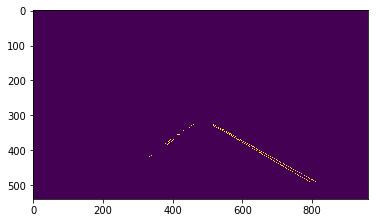

In [302]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_test_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [303]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[[183 490 454 327]]
[[536 341 766 490]]
[[275 442 445 335]]
[[526 329 748 490]]
[[200 490 417 354]]
[[569 358 720 471]]
[[523 328 604 389]]
[[609 386 700 457]]
[[427 346 449 332]]
[[523 331 765 488]]
[[201 490 327 414]]
[[411 352 455 327]]
[[658 428 758 486]]
[[185 490 453 329]]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 3/682 [00:00<00:23, 28.40it/s]

[[183 490 454 327]]
[[536 341 766 490]]
[[275 442 445 335]]
[[526 329 748 490]]
[[200 490 417 354]]
[[569 358 720 471]]
[[523 328 604 389]]
[[609 386 700 457]]
[[427 346 449 332]]
[[523 331 765 488]]
[[201 490 327 414]]
[[411 352 455 327]]
[[658 428 758 486]]
[[185 490 453 329]]
[[299 422 445 331]]
[[221 477 439 340]]
[[541 345 760 487]]
[[525 329 747 490]]
[[184 490 219 469]]
[[228 465 280 432]]
[[202 490 309 426]]
[[622 393 766 490]]
[[264 443 313 412]]
[[528 330 748 490]]
[[212 483 307 430]]
[[355 388 454 327]]
[[218 471 247 452]]
[[574 362 714 467]]
[[694 442 739 473]]
[[328 409 450 332]]
[[238 467 316 427]]
[[567 363 724 461]]
[[258 454 310 422]]
[[537 341 620 393]]
[[208 476 316 430]]
[[318 410 349 390]]
[[523 331 764 488]]
[[189 489 447 334]]
[[202 490 405 363]]
[[215 472 418 354]]
[[377 375 445 331]]
[[526 330 755 484]]
[[338 403 406 362]]
[[524 332 749 490]]
[[246 453 430 346]]
[[287 444 377 374]]
[[192 486 333 407]]
[[524 330 705 457]]
[[337 399 449 327]]
[[721 460 765 490]]


  2%|▏         | 11/682 [00:00<00:21, 30.90it/s]


[[227 480 387 380]]
[[529 335 730 471]]
[[523 328 742 470]]
[[412 353 454 327]]
[[383 377 445 336]]
[[519 327 741 471]]
[[399 362 437 341]]
[[213 490 389 380]]
[[374 385 449 327]]
[[531 336 739 471]]
[[197 490 446 334]]
[[230 478 397 369]]
[[520 327 659 414]]
[[416 356 448 327]]
[[531 336 760 490]]
[[215 488 378 386]]
[[197 489 451 330]]
[[553 351 658 414]]
[[379 386 447 327]]
[[394 365 454 327]]
[[315 423 379 383]]
[[532 333 650 409]]
[[298 434 380 384]]
[[212 490 251 466]]
[[398 367 428 348]]
[[537 338 653 416]]
[[197 490 445 335]]
[[213 490 365 391]]
[[521 327 658 413]]
[[386 370 451 329]]
[[209 484 432 345]]
[[533 334 668 428]]
[[366 392 447 328]]
[[555 352 678 426]]
[[337 408 376 383]]
[[592 370 678 428]]
[[534 333 644 413]]
[[374 378 440 339]]
[[405 357 452 328]]
[[198 490 390 374]]
[[214 490 235 477]]
[[532 336 673 428]]
[[229 472 453 327]]
[[218 489 440 339]]
[[533 336 701 441]]
[[215 490 443 336]]
[[533 337 687 441]]
[[210 484 266 447]]
[[520 327 690 442]]
[[521 327 599 374]]

  2%|▏         | 16/682 [00:00<00:19, 33.55it/s]


[[219 490 320 427]]
[[523 328 764 490]]
[[312 427 346 405]]
[[394 365 445 334]]
[[289 436 443 329]]
[[584 366 687 440]]
[[306 425 446 327]]
[[379 381 415 357]]
[[678 435 761 489]]
[[270 455 304 433]]
[[204 490 443 335]]
[[220 490 412 360]]
[[572 364 766 490]]
[[523 329 781 490]]
[[207 489 440 338]]
[[351 400 410 361]]
[[361 387 448 330]]
[[528 331 783 490]]
[[524 330 705 447]]
[[397 369 446 327]]
[[556 350 764 490]]
[[303 441 435 342]]
[[541 343 707 447]]
[[366 384 434 343]]
[[243 475 304 437]]
[[302 437 446 332]]
[[250 472 430 346]]
[[228 477 451 327]]
[[524 330 781 490]]
[[734 470 763 489]]
[[541 342 743 468]]
[[225 489 441 332]]
[[525 329 783 490]]
[[209 489 243 466]]
[[541 343 766 490]]
[[222 490 441 337]]
[[286 458 436 341]]
[[307 425 444 329]]
[[540 342 734 468]]
[[254 469 425 345]]
[[350 401 414 357]]


  3%|▎         | 20/682 [00:00<00:19, 34.84it/s]

[[223 490 436 341]]
[[271 449 449 329]]
[[207 490 438 334]]
[[530 332 663 418]]
[[525 330 656 418]]
[[526 332 548 348]]
[[245 466 289 436]]
[[171 481 439 338]]
[[581 370 661 418]]
[[529 330 664 418]]
[[170 482 260 476]]
[[214 485 263 477]]
[[394 365 446 332]]
[[275 446 445 327]]
[[171 479 257 475]]
[[330 409 361 387]]
[[233 475 448 330]]
[[225 490 435 342]]
[[526 331 684 429]]
[[227 479 445 327]]
[[210 490 244 466]]
[[544 345 675 430]]
[[393 366 449 329]]
[[229 488 397 371]]
[[400 371 441 330]]
[[334 406 445 333]]
[[526 332 670 429]]
[[529 330 677 430]]
[[208 490 450 327]]
[[264 454 446 327]]
[[282 449 433 343]]
[[219 484 446 331]]
[[527 330 601 383]]
[[208 490 449 327]]
[[224 490 396 374]]
[[232 475 444 327]]
[[527 332 707 440]]
[[529 330 682 441]]
[[288 445 396 372]]
[[398 362 438 338]]
[[226 479 256 458]]
[[527 331 706 443]]
[[315 419 438 333]]
[[546 346 696 443]]
[[541 338 691 443]]
[[236 483 388 369]]
[[684 442 706 442]]
[[220 483 294 442]]
[[340 409 433 342]]
[[225 489 428 346]]


  4%|▍         | 30/682 [00:00<00:16, 38.51it/s]

[[535 337 581 363]]
[[567 360 751 467]]
[[350 409 441 327]]
[[274 454 316 426]]
[[209 490 442 333]]
[[276 456 429 345]]
[[526 329 785 490]]
[[521 328 768 489]]
[[250 474 433 341]]
[[232 487 439 331]]
[[536 336 733 468]]
[[678 428 757 483]]
[[535 338 614 391]]
[[237 483 304 427]]
[[415 350 449 327]]
[[227 490 335 406]]
[[620 388 741 473]]
[[332 409 448 328]]
[[521 327 707 443]]
[[295 434 443 327]]
[[211 490 410 360]]
[[211 489 440 334]]
[[265 464 418 353]]
[[228 490 430 343]]
[[571 362 793 490]]
[[621 396 771 490]]
[[575 365 791 490]]
[[222 483 435 334]]
[[521 327 768 487]]
[[540 336 703 441]]
[[255 461 289 437]]
[[311 423 439 330]]
[[538 339 586 366]]
[[412 351 447 327]]
[[326 413 448 327]]
[[280 444 302 428]]
[[211 490 259 457]]
[[237 483 323 414]]
[[700 442 788 489]]
[[526 329 625 396]]
[[210 490 431 341]]
[[229 490 415 355]]
[[539 338 792 490]]
[[227 490 428 344]]
[[644 403 774 490]]
[[402 358 447 327]]
[[303 446 440 327]]
[[541 336 593 375]]
[[378 376 400 361]]
[[635 403 770 487]]


  6%|▌         | 39/682 [00:00<00:16, 39.86it/s]

[[216 490 436 330]]
[[545 336 690 427]]
[[534 332 681 427]]
[[232 490 430 340]]
[[257 462 291 437]]
[[626 393 680 427]]
[[410 350 439 332]]
[[276 449 439 327]]
[[400 358 433 337]]
[[537 333 683 427]]
[[558 349 595 369]]
[[245 482 384 377]]
[[336 406 426 338]]
[[215 490 394 369]]
[[533 332 701 441]]
[[534 332 714 440]]
[[259 471 444 327]]
[[243 483 345 398]]
[[232 490 421 347]]
[[285 441 354 399]]
[[549 338 598 373]]
[[302 430 331 408]]
[[368 396 435 329]]
[[601 370 703 441]]
[[547 338 576 355]]
[[217 490 381 379]]
[[397 361 439 332]]
[[277 447 368 392]]
[[363 385 422 346]]
[[217 490 423 340]]
[[233 490 396 367]]
[[652 410 735 460]]
[[561 351 746 458]]
[[291 438 444 327]]
[[233 489 423 345]]
[[542 335 571 352]]
[[533 332 610 375]]
[[350 394 426 342]]
[[652 409 745 458]]
[[708 445 734 460]]
[[548 342 739 453]]
[[360 403 432 331]]
[[292 437 317 418]]
[[328 411 434 331]]
[[653 410 739 460]]
[[652 408 744 457]]
[[244 471 443 327]]
[[564 353 786 481]]
[[669 420 775 483]]
[[337 412 420 347]]


  6%|▋         | 44/682 [00:01<00:15, 40.83it/s]

[[229 490 413 351]]
[[305 426 434 329]]
[[541 337 606 379]]
[[540 335 671 413]]
[[265 454 307 423]]
[[227 479 366 388]]
[[212 490 435 333]]
[[286 449 441 328]]
[[182 474 276 475]]
[[234 487 296 441]]
[[231 477 272 471]]
[[340 401 418 342]]
[[541 336 671 412]]
[[292 444 442 327]]
[[222 484 420 340]]
[[230 490 287 446]]
[[543 339 675 424]]
[[284 450 357 387]]
[[544 336 689 426]]
[[276 446 441 327]]
[[216 488 240 470]]
[[260 468 431 330]]
[[543 336 687 426]]
[[299 439 443 327]]
[[221 485 426 336]]
[[271 450 440 328]]
[[233 487 276 456]]
[[544 340 713 437]]
[[594 373 705 440]]
[[547 338 713 438]]
[[261 466 283 451]]
[[544 341 714 439]]
[[212 490 294 442]]
[[301 436 370 385]]
[[240 471 266 452]]


  7%|▋         | 49/682 [00:01<00:15, 39.63it/s]

[[307 424 443 328]]
[[232 490 376 381]]
[[525 329 636 401]]
[[300 429 413 352]]
[[224 484 266 453]]
[[531 331 743 458]]
[[386 373 411 347]]
[[292 435 383 375]]
[[366 381 418 348]]
[[231 490 253 473]]
[[254 463 279 444]]
[[388 365 420 346]]
[[215 490 432 332]]
[[557 349 744 457]]
[[285 440 364 390]]
[[373 376 429 339]]
[[540 337 736 459]]
[[213 490 440 331]]
[[231 489 441 330]]
[[308 433 356 395]]
[[272 460 433 330]]
[[526 330 757 480]]
[[540 335 776 482]]
[[539 336 774 482]]
[[333 405 444 327]]
[[230 490 305 435]]
[[337 411 437 328]]
[[754 476 783 480]]
[[217 487 393 368]]
[[550 347 763 480]]
[[230 490 442 330]]
[[261 458 415 346]]
[[527 330 678 421]]
[[214 490 439 327]]
[[554 350 669 422]]
[[529 333 672 422]]
[[231 490 379 382]]
[[419 346 445 327]]
[[224 484 262 456]]
[[321 422 378 382]]
[[535 334 678 420]]
[[316 426 380 383]]
[[527 331 674 422]]
[[280 444 304 426]]
[[312 429 381 384]]
[[400 356 423 340]]
[[215 490 438 328]]
[[233 488 443 329]]
[[528 332 699 435]]
[[554 350 690 435]]


  8%|▊         | 53/682 [00:01<00:17, 36.52it/s]


[[224 483 439 327]]
[[567 358 797 490]]
[[536 334 768 484]]
[[229 490 443 328]]
[[213 490 243 468]]
[[556 345 780 490]]
[[534 335 585 369]]
[[293 434 425 338]]
[[574 363 742 457]]
[[268 451 288 436]]
[[239 472 261 455]]
[[701 438 762 480]]
[[543 340 629 390]]
[[246 476 366 388]]
[[350 392 423 340]]
[[279 442 428 341]]
[[540 336 777 490]]
[[215 487 408 356]]
[[633 399 796 490]]
[[521 327 591 374]]
[[228 490 278 454]]
[[380 370 432 333]]
[[310 443 442 328]]
[[355 395 375 381]]
[[640 400 748 472]]
[[345 396 373 382]]
[[353 390 387 372]]
[[211 490 305 440]]
[[538 336 633 400]]
[[217 486 304 440]]
[[305 444 445 327]]
[[195 421 545 341]]
[[293 443 435 336]]
[[243 480 439 327]]
[[521 328 771 478]]
[[211 490 444 327]]
[[212 490 445 327]]
[[537 340 777 490]]
[[376 379 438 333]]
[[275 459 443 328]]
[[228 490 277 459]]
[[521 327 788 487]]
[[544 344 794 489]]
[[274 462 412 347]]
[[230 489 310 430]]
[[523 330 774 487]]
[[265 462 285 463]]
[[235 486 446 327]]
[[211 490 443 328]]
[[521 328 673 419]]

  9%|▊         | 58/682 [00:01<00:16, 38.03it/s]


[[529 330 597 379]]
[[210 490 414 347]]
[[544 344 714 446]]
[[391 362 437 329]]
[[600 381 708 446]]
[[ 32 490 535 337]]
[[289 436 315 417]]
[[211 490 423 341]]
[[229 490 446 327]]
[[524 330 622 396]]
[[535 339 751 464]]
[[526 329 740 467]]
[[399 357 432 334]]
[[228 490 442 329]]
[[523 331 637 405]]
[[413 352 436 335]]
[[212 490 386 368]]
[[524 329 744 466]]
[[405 359 436 329]]
[[214 488 445 327]]
[[306 430 433 337]]
[[258 468 439 327]]
[[525 331 783 486]]
[[226 490 383 368]]
[[525 329 652 414]]
[[526 333 777 490]]
[[228 490 345 395]]
[[254 459 357 394]]
[[288 436 326 408]]
[[210 490 234 473]]
[[525 330 785 486]]
[[282 450 390 363]]
[[278 442 346 402]]
[[244 478 317 415]]
[[610 388 777 489]]
[[272 446 334 411]]
[[315 425 355 388]]
[[548 348 793 490]]
[[401 355 444 328]]
[[261 465 332 404]]


  9%|▉         | 62/682 [00:01<00:16, 37.58it/s]

[[210 490 421 342]]
[[225 490 421 347]]
[[526 332 680 424]]
[[549 349 672 426]]
[[209 490 435 331]]
[[226 490 304 433]]
[[401 361 445 327]]
[[537 341 673 426]]
[[526 331 681 424]]
[[333 410 386 372]]
[[526 333 676 426]]
[[641 408 670 426]]
[[550 349 679 424]]
[[402 360 439 327]]
[[210 490 424 340]]
[[225 490 420 348]]
[[527 334 703 439]]
[[563 359 694 441]]
[[385 372 435 336]]
[[531 333 697 441]]
[[335 409 420 349]]
[[208 490 439 328]]
[[540 343 703 441]]
[[358 396 444 327]]
[[553 352 674 420]]
[[224 490 423 345]]
[[290 432 445 327]]
[[528 334 732 456]]
[[644 410 721 458]]
[[206 490 430 339]]
[[348 403 439 327]]
[[529 332 727 451]]
[[398 357 437 334]]
[[531 332 725 458]]
[[311 418 424 344]]
[[542 344 732 458]]
[[266 459 320 419]]
[[353 403 420 341]]
[[280 439 362 389]]
[[208 490 436 330]]
[[556 353 644 408]]
[[319 420 417 351]]
[[205 490 444 328]]
[[223 490 421 346]]
[[572 364 757 480]]
[[530 334 771 479]]
[[206 490 427 341]]
[[376 372 445 327]]
[[533 338 760 480]]
[[533 333 769 480]]


 10%|▉         | 67/682 [00:01<00:16, 38.40it/s]

[[223 490 439 333]]
[[223 480 433 333]]
[[519 327 786 488]]
[[208 490 439 328]]
[[571 364 789 490]]
[[538 337 734 464]]
[[523 329 771 490]]
[[738 463 773 481]]
[[373 376 441 331]]
[[534 339 735 464]]
[[224 490 445 329]]
[[245 466 425 340]]
[[227 489 433 339]]
[[230 476 282 439]]
[[521 328 779 489]]
[[517 327 597 381]]
[[217 485 237 470]]
[[332 406 443 329]]
[[411 349 434 333]]
[[236 471 266 472]]
[[179 479 440 328]]
[[177 476 264 476]]
[[520 329 776 489]]
[[282 440 327 408]]
[[267 451 424 341]]
[[225 490 435 337]]
[[216 486 279 441]]
[[521 328 671 425]]
[[521 329 662 424]]
[[238 471 298 428]]
[[226 490 413 354]]
[[421 343 445 329]]


 10%|█         | 71/682 [00:01<00:16, 37.65it/s]

[[538 342 678 423]]
[[580 371 670 425]]
[[291 434 321 412]]
[[220 483 240 468]]
[[298 428 447 327]]
[[226 490 432 340]]
[[209 490 442 327]]
[[524 329 693 439]]
[[522 331 614 393]]
[[611 384 690 439]]
[[224 490 337 402]]
[[231 485 448 327]]
[[522 329 692 439]]
[[293 433 328 408]]
[[356 389 438 335]]
[[336 403 389 372]]
[[390 365 423 342]]
[[540 344 685 438]]
[[267 451 316 416]]
[[226 489 446 329]]
[[208 490 446 329]]
[[226 490 442 327]]
[[542 345 728 452]]
[[236 483 420 349]]
[[594 380 719 455]]
[[525 329 710 454]]
[[210 490 432 340]]
[[224 490 441 327]]
[[703 453 727 455]]
[[257 466 448 327]]
[[229 487 447 328]]
[[544 347 718 451]]
[[523 331 722 455]]
[[208 490 438 335]]
[[259 466 321 420]]
[[344 405 441 327]]
[[524 330 758 476]]
[[524 332 625 400]]
[[313 427 394 362]]
[[355 397 389 371]]
[[227 489 356 389]]
[[333 413 373 377]]
[[526 330 639 409]]
[[373 384 406 358]]
[[263 452 416 352]]
[[400 358 447 327]]
[[527 330 742 475]]
[[340 408 363 384]]
[[225 490 343 398]]
[[535 339 749 473]]


 11%|█         | 75/682 [00:01<00:16, 37.47it/s]

[[332 406 449 327]]
[[226 490 438 336]]
[[210 490 443 327]]
[[568 358 692 444]]
[[552 352 679 426]]
[[521 327 701 448]]
[[681 429 703 441]]
[[273 448 420 345]]
[[225 490 448 328]]
[[586 374 675 424]]
[[516 327 648 416]]
[[270 450 300 428]]
[[586 376 702 448]]
[[638 408 710 446]]
[[631 403 686 431]]
[[392 364 446 328]]
[[520 328 705 448]]
[[245 467 425 341]]
[[228 489 430 342]]
[[214 488 441 329]]
[[542 346 743 467]]
[[531 339 728 467]]
[[529 337 743 465]]
[[225 490 449 327]]
[[211 490 249 463]]
[[521 329 734 467]]
[[516 327 601 378]]
[[521 328 742 466]]
[[644 414 732 467]]
[[227 490 441 334]]
[[310 423 444 330]]
[[531 339 782 490]]
[[211 490 444 327]]
[[520 327 761 489]]
[[518 327 725 466]]
[[298 431 354 391]]
[[515 327 573 368]]
[[225 490 450 327]]
[[600 386 781 490]]
[[251 463 431 337]]
[[441 328 711 448]]
[[225 480 255 459]]


 12%|█▏        | 79/682 [00:02<00:16, 35.95it/s]

[[607 383 683 440]]
[[534 337 747 470]]
[[227 490 421 349]]
[[211 489 449 328]]
[[536 343 761 489]]
[[519 327 781 490]]
[[226 490 443 327]]
[[518 327 774 487]]
[[518 330 764 490]]
[[357 389 425 346]]
[[210 490 308 431]]
[[315 432 443 328]]
[[518 329 619 390]]
[[282 442 419 346]]
[[234 474 317 428]]
[[304 425 449 327]]
[[226 490 439 335]]
[[520 327 752 483]]
[[209 490 443 327]]
[[533 340 764 490]]
[[225 490 448 328]]
[[519 327 780 490]]
[[271 449 319 415]]
[[391 364 433 335]]
[[533 339 763 478]]
[[233 475 259 456]]
[[574 368 715 453]]
[[519 329 743 468]]
[[289 437 414 349]]
[[338 410 405 362]]
[[236 483 415 353]]
[[240 470 437 332]]
[[225 490 449 327]]
[[556 350 764 490]]
[[539 339 591 379]]
[[219 484 257 457]]
[[534 341 781 490]]
[[629 406 780 490]]
[[569 365 751 483]]
[[417 345 442 328]]
[[226 490 443 332]]
[[522 328 635 407]]
[[519 330 643 404]]
[[519 329 630 404]]
[[238 471 443 327]]
[[232 475 442 328]]
[[224 490 448 327]]
[[227 489 444 331]]
[[209 490 236 471]]
[[521 331 658 413]]


 12%|█▏        | 83/682 [00:02<00:16, 35.87it/s]

[[226 479 443 327]]
[[225 490 449 327]]
[[226 490 443 332]]
[[522 330 671 427]]
[[521 332 663 428]]
[[520 327 668 427]]
[[292 434 422 343]]
[[209 490 250 461]]
[[522 332 676 425]]
[[581 372 673 427]]
[[559 357 615 389]]
[[224 490 448 327]]
[[230 475 442 327]]
[[522 332 698 438]]
[[561 359 691 440]]
[[208 490 441 327]]
[[521 327 685 438]]
[[531 338 684 441]]
[[356 389 437 331]]
[[522 330 681 437]]
[[226 487 393 374]]
[[347 395 373 376]]
[[543 347 698 437]]
[[223 490 448 327]]
[[227 477 442 327]]
[[522 332 726 454]]
[[521 327 624 401]]
[[206 490 237 469]]
[[567 362 628 396]]
[[390 365 440 329]]
[[209 489 441 327]]
[[534 340 721 457]]
[[591 379 717 458]]
[[222 490 384 368]]
[[546 349 637 402]]
[[231 485 386 376]]
[[522 328 715 458]]
[[223 490 446 328]]

 13%|█▎        | 87/682 [00:02<00:16, 35.96it/s]


[[272 444 409 351]]
[[528 331 757 479]]
[[516 327 746 482]]
[[222 490 447 327]]
[[400 356 433 334]]
[[207 490 252 458]]
[[529 332 750 481]]
[[524 333 739 478]]
[[577 363 750 479]]
[[241 467 271 445]]
[[525 331 754 479]]
[[411 348 434 333]]
[[226 477 274 443]]
[[544 347 762 478]]
[[261 453 283 437]]
[[305 423 442 327]]
[[223 490 447 327]]
[[217 481 419 344]]
[[518 327 668 421]]
[[607 390 658 423]]
[[222 490 446 327]]
[[516 327 656 421]]
[[410 349 441 328]]
[[546 348 667 421]]
[[208 489 253 457]]
[[337 401 427 338]]
[[529 332 665 423]]
[[239 476 402 361]]
[[204 490 405 354]]
[[516 327 690 435]]
[[220 490 345 402]]
[[617 397 678 436]]
[[393 366 441 333]]
[[393 361 429 337]]
[[519 327 690 434]]
[[515 327 666 429]]
[[420 342 440 329]]
[[351 390 448 327]]
[[533 336 689 434]]
[[383 368 442 332]]
[[549 351 687 437]]
[[340 404 376 379]]
[[540 343 680 437]]
[[204 490 446 327]]
[[222 489 366 385]]
[[311 426 448 327]]
[[553 354 705 453]]
[[516 327 712 449]]
[[519 328 717 451]]
[[384 367 429 337]]

 13%|█▎        | 91/682 [00:02<00:16, 35.81it/s]

[[240 474 443 331]]
[[521 329 779 490]]
[[209 486 393 362]]
[[558 357 763 490]]
[[201 490 442 327]]
[[218 490 325 418]]
[[516 327 670 427]]
[[243 472 328 417]]
[[203 490 429 337]]
[[320 417 448 327]]
[[708 456 762 490]]
[[519 330 699 439]]
[[273 451 331 411]]
[[547 348 686 441]]
[[725 455 775 487]]
[[205 489 423 342]]
[[219 490 428 343]]
[[548 350 780 490]]
[[519 327 761 490]]
[[372 381 435 338]]
[[517 329 619 391]]
[[390 363 434 334]]
[[203 490 248 459]]
[[355 389 447 327]]
[[390 368 444 331]]
[[552 347 708 456]]
[[518 329 681 439]]
[[563 361 694 440]]
[[202 490 440 329]]
[[520 330 682 439]]
[[328 412 355 394]]
[[518 327 779 490]]
[[319 421 449 327]]
[[203 490 444 327]]
[[521 329 761 490]]
[[219 490 288 443]]
[[577 371 732 461]]
[[283 450 367 380]]
[[550 352 779 490]]
[[323 411 361 384]]
[[520 332 704 456]]
[[282 449 447 329]]
[[243 473 264 459]]
[[230 473 284 436]]
[[283 449 373 376]]
[[566 364 758 489]]
[[271 454 398 359]]
[[519 330 719 460]]
[[287 450 330 405]]
[[292 450 357 387]]


 14%|█▍        | 95/682 [00:02<00:16, 35.87it/s]

[[207 490 441 332]]
[[223 490 433 343]]
[[238 479 448 331]]
[[216 485 451 327]]
[[510 327 660 417]]
[[512 329 648 420]]
[[515 327 659 420]]
[[515 328 657 417]]
[[587 374 653 420]]
[[511 327 654 420]]
[[225 490 430 346]]
[[215 486 452 327]]
[[208 490 439 334]]
[[323 420 384 378]]
[[511 327 667 432]]
[[513 327 675 432]]
[[404 364 453 327]]
[[540 349 606 392]]
[[394 371 447 327]]
[[510 327 601 390]]
[[375 383 417 355]]
[[612 389 671 432]]
[[211 489 433 339]]
[[226 490 428 348]]
[[208 490 442 332]]
[[511 327 690 447]]
[[312 428 373 386]]
[[402 366 454 327]]
[[515 327 700 447]]
[[586 380 694 447]]
[[357 396 393 372]]
[[523 337 692 443]]
[[512 329 702 444]]
[[543 351 600 383]]
[[399 368 448 327]]
[[304 434 345 406]]
[[311 429 444 335]]
[[210 490 451 328]]
[[511 328 711 463]]
[[510 327 730 464]]
[[225 490 284 450]]
[[222 481 442 332]]
[[286 447 337 412]]
[[516 328 719 465]]
[[371 386 454 327]]
[[272 457 295 442]]
[[515 327 720 465]]
[[324 420 348 404]]


 15%|█▍        | 99/682 [00:02<00:16, 35.81it/s]

[[224 490 433 343]]
[[209 490 450 328]]
[[526 338 637 413]]
[[512 327 768 487]]
[[328 416 444 334]]
[[233 484 375 388]]
[[515 327 755 488]]
[[511 327 748 486]]
[[409 354 452 327]]
[[546 351 603 387]]
[[226 489 380 389]]
[[208 490 433 338]]
[[225 490 449 328]]
[[362 387 435 336]]
[[209 490 413 357]]
[[513 328 663 422]]
[[517 327 624 404]]
[[253 459 393 371]]
[[329 409 366 383]]
[[555 352 630 408]]
[[372 394 444 332]]
[[512 327 656 424]]
[[224 490 332 406]]
[[518 328 658 418]]
[[301 427 363 392]]
[[359 389 445 327]]
[[366 393 451 327]]
[[235 472 373 392]]
[[289 435 372 391]]
[[249 462 519 330]]
[[314 418 376 383]]
[[208 490 431 339]]
[[227 489 449 328]]
[[517 327 684 435]]
[[620 401 675 436]]
[[375 384 451 327]]
[[357 399 452 327]]
[[530 340 684 433]]
[[366 390 390 372]]
[[410 353 432 338]]
[[515 329 680 436]]
[[209 490 409 355]]
[[513 327 623 398]]
[[360 394 446 327]]
[[516 327 682 435]]
[[517 331 664 430]]
[[209 489 429 340]]
[[239 479 428 346]]
[[532 336 697 451]]
[[596 377 709 450]]


 15%|█▌        | 103/682 [00:02<00:16, 35.93it/s]

[[207 490 429 340]]
[[514 328 677 438]]
[[227 489 449 328]]
[[415 354 438 338]]
[[518 328 738 465]]
[[658 416 741 470]]
[[344 406 394 369]]
[[209 490 451 327]]
[[531 337 736 470]]
[[650 415 726 470]]
[[339 418 444 327]]
[[562 356 725 470]]
[[335 417 446 331]]
[[655 415 737 470]]
[[225 490 320 421]]
[[519 331 730 463]]
[[207 490 429 340]]
[[663 428 759 490]]
[[322 421 450 328]]
[[523 332 771 487]]
[[226 489 450 327]]
[[519 332 663 426]]
[[518 330 768 486]]
[[224 490 367 383]]
[[329 429 436 333]]
[[321 426 439 337]]
[[404 363 433 336]]
[[696 450 738 477]]
[[407 361 440 330]]
[[209 489 450 327]]
[[222 490 435 340]]
[[519 329 777 490]]
[[223 490 418 353]]
[[682 441 758 490]]
[[549 352 775 488]]
[[515 328 765 484]]
[[320 415 451 327]]
[[206 490 231 473]]
[[519 332 684 439]]
[[412 351 434 336]]
[[205 490 446 327]]
[[408 354 445 332]]
[[219 482 270 447]]
[[207 490 427 341]]
[[338 410 444 333]]
[[520 330 776 490]]
[[222 490 291 443]]
[[708 458 758 490]]
[[520 331 763 483]]
[[311 429 417 349]]


 16%|█▌        | 107/682 [00:02<00:16, 35.74it/s]

[[206 490 425 342]]
[[221 490 425 347]]
[[223 490 405 362]]
[[573 368 776 490]]
[[519 327 748 476]]
[[382 372 440 335]]
[[521 330 758 490]]
[[205 490 436 334]]
[[355 390 422 349]]
[[520 332 751 476]]
[[536 343 770 484]]
[[328 409 352 392]]
[[238 469 272 446]]
[[163 487 451 327]]
[[161 485 441 329]]
[[301 427 444 327]]
[[222 490 416 354]]
[[206 490 428 340]]
[[515 327 656 422]]
[[523 330 663 421]]
[[205 490 440 331]]
[[521 332 651 420]]
[[414 354 434 340]]
[[339 401 411 357]]
[[423 347 451 327]]
[[376 376 425 347]]
[[276 444 444 327]]
[[215 445 394 369]]
[[523 333 655 419]]
[[222 490 428 345]]
[[210 488 450 327]]
[[516 327 686 433]]
[[522 334 676 434]]
[[232 484 342 407]]
[[205 490 440 331]]
[[513 327 678 434]]
[[423 347 446 331]]
[[223 490 405 362]]
[[400 359 451 327]]
[[266 450 292 432]]
[[567 358 680 434]]
[[211 487 253 458]]
[[583 375 684 433]]
[[189 463 445 327]]
[[257 467 450 327]]
[[205 490 432 342]]
[[523 334 710 446]]
[[362 387 445 327]]
[[224 490 369 381]]
[[207 490 419 352]]


 16%|█▋        | 111/682 [00:02<00:15, 35.95it/s]


[[392 365 443 334]]
[[524 332 704 449]]
[[542 348 699 450]]
[[150 487 371 472]]
[[207 490 428 341]]
[[223 490 417 354]]
[[243 467 451 327]]
[[514 327 724 468]]
[[524 336 742 467]]
[[519 327 627 405]]
[[400 365 450 329]]
[[551 349 632 407]]
[[415 349 443 330]]
[[544 350 735 469]]
[[224 490 285 448]]
[[238 479 433 342]]
[[518 327 732 471]]
[[224 490 411 359]]
[[268 451 453 327]]
[[208 490 426 343]]
[[512 327 773 490]]
[[548 353 646 417]]
[[409 359 442 336]]
[[516 328 775 490]]
[[421 345 443 330]]
[[526 338 760 490]]
[[391 372 420 352]]
[[418 352 452 328]]
[[208 490 430 345]]
[[278 454 447 327]]
[[513 327 670 425]]
[[226 490 374 379]]
[[337 412 390 368]]
[[529 340 664 428]]
[[320 415 450 330]]
[[356 397 407 362]]
[[231 487 339 409]]
[[518 328 588 372]]
[[301 428 415 356]]
[[346 404 385 378]]
[[527 338 665 428]]
[[516 328 672 425]]
[[614 397 663 428]]
[[354 400 417 348]]
[[209 490 421 347]]
[[283 449 426 348]]
[[515 328 683 441]]
[[225 490 356 402]]
[[518 328 693 441]]
[[423 344 448 327]]

 17%|█▋        | 115/682 [00:03<00:16, 35.27it/s]

[[218 485 453 327]]
[[226 490 395 371]]
[[556 358 710 458]]
[[514 327 722 456]]
[[209 490 429 341]]
[[515 328 714 452]]
[[348 414 448 327]]
[[530 340 712 458]]
[[331 415 392 373]]
[[401 365 440 338]]
[[322 414 449 331]]
[[413 351 436 336]]
[[514 328 714 458]]
[[210 490 404 364]]
[[519 329 711 458]]
[[212 489 453 327]]
[[228 488 401 366]]
[[515 327 758 479]]
[[654 422 745 479]]
[[410 353 448 327]]
[[226 490 370 389]]
[[407 360 449 331]]
[[392 366 426 343]]
[[532 341 753 479]]
[[517 330 755 479]]
[[561 361 750 479]]
[[653 421 746 479]]
[[210 490 261 455]]
[[713 460 740 477]]
[[377 377 424 349]]
[[715 451 756 477]]
[[533 341 754 479]]
[[394 365 419 353]]
[[215 487 453 327]]
[[515 327 777 490]]
[[227 489 397 369]]
[[520 332 762 490]]
[[521 329 760 490]]
[[226 490 373 387]]
[[391 372 427 347]]
[[389 368 440 333]]
[[237 472 291 435]]
[[615 390 707 456]]
[[274 446 439 338]]
[[209 490 235 472]]
[[689 434 734 463]]
[[732 461 763 481]]
[[420 346 444 330]]
[[535 343 610 393]]
[[388 369 445 334]]


 17%|█▋        | 119/682 [00:03<00:16, 34.77it/s]


[[225 490 385 378]]
[[536 342 752 472]]
[[522 330 779 490]]
[[569 365 761 490]]
[[407 355 446 328]]
[[212 489 273 447]]
[[382 373 439 338]]
[[375 384 405 363]]
[[399 366 436 341]]
[[393 365 426 343]]
[[324 413 443 335]]
[[514 327 738 466]]
[[222 453 301 451]]
[[225 452 399 367]]
[[520 327 762 490]]
[[227 490 342 409]]
[[535 342 698 444]]
[[242 469 443 329]]
[[226 489 399 367]]
[[352 395 446 327]]
[[522 330 779 490]]
[[554 355 762 490]]
[[382 378 452 328]]
[[222 482 259 456]]
[[515 327 725 463]]
[[262 468 322 414]]
[[263 469 355 392]]
[[226 490 335 405]]
[[537 343 645 405]]
[[288 447 344 399]]
[[208 490 413 357]]
[[242 478 312 430]]
[[394 364 436 336]]
[[190 474 526 331]]
[[275 470 350 395]]
[[212 489 453 327]]
[[369 388 442 336]]
[[247 476 443 329]]
[[522 333 645 416]]
[[269 459 339 411]]
[[523 331 778 490]]
[[330 416 364 393]]
[[411 352 447 327]]
[[209 490 235 472]]
[[236 482 311 431]]
[[520 331 761 488]]
[[319 416 447 332]]
[[518 327 779 490]]
[[359 396 387 369]]
[[520 327 762 490]]

 18%|█▊        | 123/682 [00:03<00:16, 34.28it/s]

[[230 490 455 327]]
[[222 484 447 327]]
[[516 327 670 423]]
[[551 353 661 424]]
[[260 459 449 327]]
[[229 490 452 328]]
[[515 327 665 424]]
[[519 327 665 418]]
[[219 486 241 470]]
[[540 345 667 424]]
[[252 464 448 327]]
[[231 490 455 327]]
[[279 445 398 364]]
[[555 356 681 438]]
[[520 329 691 436]]
[[214 490 457 327]]
[[530 338 690 438]]
[[390 368 435 338]]
[[269 452 422 352]]
[[533 341 690 436]]
[[531 337 680 437]]
[[426 343 449 328]]
[[221 485 349 396]]
[[537 340 688 438]]
[[358 390 450 330]]
[[230 490 453 328]]
[[275 447 428 343]]
[[531 339 707 453]]
[[516 327 717 453]]
[[521 329 717 451]]
[[215 490 456 327]]
[[378 376 426 344]]
[[232 489 353 404]]
[[264 455 419 354]]
[[570 360 704 453]]
[[371 381 450 327]]
[[515 327 709 453]]
[[241 471 356 404]]
[[520 327 650 418]]
[[230 490 449 331]]
[[226 481 404 360]]
[[535 342 751 472]]
[[547 350 738 474]]
[[514 327 606 382]]
[[396 364 435 338]]
[[340 417 455 327]]
[[331 418 397 369]]
[[367 384 417 351]]
[[215 490 344 413]]
[[221 486 457 327]]


 19%|█▊        | 127/682 [00:03<00:15, 35.12it/s]

[[213 490 374 381]]
[[518 328 730 460]]
[[404 359 438 336]]
[[428 342 451 327]]
[[352 403 457 327]]
[[232 490 457 327]]
[[331 411 452 327]]
[[216 489 311 423]]
[[515 329 762 490]]
[[519 328 770 485]]
[[304 429 352 395]]
[[514 327 693 443]]
[[577 365 708 456]]
[[234 488 364 387]]
[[518 327 780 490]]
[[524 332 730 470]]
[[269 453 443 332]]
[[572 368 626 397]]
[[240 442 315 442]]
[[273 459 393 374]]
[[233 489 457 327]]
[[275 449 449 328]]
[[214 490 302 429]]
[[514 328 763 490]]
[[514 327 727 460]]
[[521 328 779 489]]
[[519 329 767 483]]
[[230 490 402 361]]
[[385 374 448 329]]
[[518 327 779 490]]
[[715 460 762 490]]
[[537 344 723 460]]
[[262 458 285 441]]
[[571 367 726 460]]
[[209 461 295 458]]
[[233 489 455 328]]

 20%|█▉        | 135/682 [00:03<00:15, 36.09it/s]


[[263 457 444 331]]
[[222 485 340 403]]
[[514 328 763 490]]
[[518 327 757 483]]
[[231 489 390 369]]
[[395 367 451 327]]
[[520 328 766 482]]
[[216 489 264 455]]
[[516 327 755 482]]
[[231 490 423 346]]
[[513 327 594 382]]
[[241 484 457 327]]
[[519 327 781 490]]
[[514 327 750 480]]
[[170 485 262 476]]
[[232 490 457 327]]
[[262 458 446 330]]
[[219 487 323 415]]
[[517 327 666 423]]
[[513 327 604 388]]
[[230 490 402 361]]
[[385 374 449 328]]
[[216 489 254 462]]
[[517 328 664 423]]
[[237 486 359 391]]
[[313 423 451 327]]
[[233 489 454 329]]
[[213 490 267 453]]
[[516 330 679 436]]
[[521 328 686 435]]
[[228 481 280 444]]
[[285 452 457 327]]
[[253 464 283 442]]
[[291 438 339 404]]
[[527 334 616 394]]
[[518 331 684 435]]
[[288 440 308 425]]
[[513 327 688 432]]
[[360 391 452 327]]
[[231 490 286 440]]
[[518 327 680 436]]
[[594 376 682 435]]
[[231 490 451 331]]
[[244 470 438 335]]
[[379 378 446 330]]
[[516 328 712 450]]
[[216 489 318 418]]
[[545 349 702 451]]
[[513 327 710 450]]
[[326 422 457 327]]

 20%|██        | 139/682 [00:03<00:15, 35.59it/s]


[[215 490 319 418]]
[[512 328 716 461]]
[[516 327 726 458]]
[[248 466 453 327]]
[[241 484 456 328]]
[[517 327 729 459]]
[[511 327 726 461]]
[[413 353 452 327]]
[[314 423 352 396]]
[[215 489 404 361]]
[[348 414 459 327]]
[[521 331 656 426]]
[[231 490 444 336]]
[[259 460 433 339]]
[[510 327 751 483]]
[[514 327 765 483]]
[[521 329 766 482]]
[[214 490 266 454]]
[[296 444 458 327]]
[[359 392 426 344]]
[[419 350 450 328]]
[[517 327 751 473]]
[[517 329 763 483]]
[[327 414 349 398]]
[[234 477 282 443]]
[[519 332 760 483]]
[[241 483 457 327]]
[[276 448 440 334]]
[[512 327 763 490]]
[[518 327 779 490]]
[[223 484 317 419]]
[[581 367 712 458]]
[[213 490 237 473]]
[[514 327 685 433]]
[[230 490 318 433]]
[[278 456 442 333]]
[[238 484 420 347]]
[[703 453 762 490]]
[[742 466 780 490]]
[[320 436 445 331]]
[[246 479 366 386]]
[[339 411 458 327]]
[[214 490 262 456]]
[[516 327 715 451]]


 22%|██▏       | 148/682 [00:04<00:17, 29.96it/s]

[[233 489 457 327]]
[[294 436 448 329]]
[[510 327 759 488]]
[[521 329 780 490]]
[[517 327 727 458]]
[[215 490 426 343]]
[[517 330 764 490]]
[[214 490 239 472]]
[[513 328 759 476]]
[[249 476 294 448]]
[[298 452 452 327]]
[[230 490 433 343]]
[[224 484 458 327]]
[[256 473 444 332]]
[[508 327 780 490]]
[[226 481 405 364]]
[[369 385 432 340]]
[[249 478 350 397]]
[[351 403 381 382]]
[[514 328 645 407]]
[[233 489 331 410]]
[[512 328 762 490]]
[[270 472 367 385]]
[[235 488 445 336]]
[[543 344 752 484]]
[[191 472 279 472]]
[[330 412 364 387]]
[[544 345 574 366]]
[[247 468 279 468]]
[[300 431 379 383]]
[[517 328 593 381]]
[[251 476 380 376]]
[[228 481 357 400]]
[[230 490 429 346]]
[[236 476 430 341]]
[[215 490 320 417]]
[[517 331 652 418]]
[[516 328 659 417]]
[[260 470 458 327]]
[[400 363 441 334]]
[[408 362 452 327]]
[[311 432 371 389]]
[[282 454 373 381]]
[[543 344 583 375]]
[[233 489 264 467]]
[[525 337 605 382]]
[[223 484 253 463]]
[[517 328 656 418]]
[[231 490 435 342]]
[[281 445 435 338]]


 22%|██▏       | 152/682 [00:04<00:17, 31.12it/s]


[[568 359 649 417]]
[[390 368 455 330]]
[[554 356 689 434]]
[[213 490 324 415]]
[[360 400 427 344]]
[[231 490 359 400]]
[[241 482 364 399]]
[[512 327 594 374]]
[[357 399 411 359]]
[[233 475 452 327]]
[[229 490 453 327]]
[[511 327 715 449]]
[[521 334 702 451]]
[[212 490 437 343]]
[[549 347 704 451]]
[[288 438 458 327]]
[[558 357 716 449]]
[[282 442 351 404]]
[[536 339 701 450]]
[[353 408 457 327]]
[[260 457 352 404]]
[[352 408 451 328]]
[[230 490 454 327]]
[[297 434 408 357]]
[[514 330 570 366]]
[[506 327 738 472]]
[[513 327 741 464]]
[[216 489 340 403]]
[[603 386 749 470]]
[[334 417 459 327]]
[[405 360 431 342]]
[[337 417 452 327]]
[[652 415 739 463]]
[[512 328 722 464]]
[[669 421 733 471]]
[[214 490 246 467]]
[[536 341 744 471]]
[[338 418 455 330]]
[[280 455 427 345]]
[[507 327 710 444]]
[[693 445 739 472]]
[[339 418 401 362]]
[[652 416 712 447]]
[[213 490 454 327]]
[[273 459 456 330]]
[[570 366 784 490]]
[[668 429 766 490]]
[[230 490 439 343]]
[[214 490 394 373]]
[[538 346 742 464]]

 23%|██▎       | 157/682 [00:04<00:15, 33.92it/s]

[[224 486 453 331]]
[[377 389 463 327]]
[[234 490 450 338]]
[[516 332 696 436]]
[[517 332 696 435]]
[[505 328 689 438]]
[[247 471 371 393]]
[[220 489 355 404]]
[[396 371 457 328]]
[[503 327 618 396]]
[[235 490 271 465]]
[[281 456 464 327]]
[[237 489 443 344]]
[[222 490 464 327]]
[[233 481 450 334]]
[[502 327 636 401]]
[[323 427 384 385]]
[[362 399 447 341]]


 24%|██▎       | 161/682 [00:04<00:16, 30.97it/s]

[[598 385 719 454]]
[[501 327 631 399]]
[[509 330 579 368]]
[[221 490 437 344]]
[[517 333 579 367]]
[[236 490 303 443]]
[[532 340 715 454]]
[[238 490 393 378]]
[[234 481 448 336]]
[[517 331 756 474]]
[[389 382 465 327]]
[[501 327 747 474]]
[[507 327 559 361]]
[[509 327 560 361]]
[[292 441 456 330]]
[[223 490 439 327]]
[[509 328 744 475]]
[[241 477 368 397]]
[[508 327 753 474]]
[[372 394 458 327]]
[[419 362 454 336]]
[[224 489 464 327]]
[[301 444 454 336]]
[[240 489 374 395]]
[[502 327 661 422]]
[[519 335 667 420]]
[[519 334 590 373]]
[[303 443 380 395]]
[[414 366 457 328]]
[[522 337 658 422]]
[[223 490 465 327]]
[[536 342 567 364]]
[[324 428 369 397]]
[[240 490 367 391]]
[[408 370 447 342]]
[[226 489 504 329]]
[[233 483 464 327]]
[[252 482 464 328]]
[[502 328 687 431]]
[[244 486 424 359]]
[[501 327 677 433]]
[[524 338 596 378]]
[[239 490 267 471]]
[[521 334 562 357]]
[[224 490 341 417]]
[[362 402 459 327]]
[[502 327 650 409]]
[[625 401 682 433]]
[[223 490 465 327]]
[[520 335 596 377]]


 25%|██▍       | 170/682 [00:04<00:15, 33.42it/s]

[[519 331 768 486]]
[[275 456 452 332]]
[[617 388 781 486]]
[[557 352 735 467]]
[[224 490 457 327]]
[[276 465 445 338]]
[[241 490 458 327]]
[[514 330 765 486]]
[[250 473 298 439]]
[[703 438 780 486]]
[[332 427 395 373]]
[[503 327 619 388]]
[[340 427 464 327]]
[[542 344 779 486]]
[[732 455 781 484]]
[[269 470 385 380]]
[[336 427 428 350]]
[[240 490 464 327]]
[[320 426 461 328]]
[[514 330 792 490]]
[[259 466 389 384]]
[[504 327 775 490]]
[[226 489 364 402]]
[[522 332 696 436]]
[[505 327 694 436]]
[[399 377 457 327]]
[[305 436 357 399]]
[[241 490 303 446]]
[[420 360 443 344]]
[[255 469 339 420]]
[[520 331 587 376]]
[[418 357 463 327]]
[[245 476 521 335]]
[[298 440 326 440]]
[[406 372 458 327]]
[[299 439 372 396]]
[[579 370 774 478]]
[[240 490 461 329]]
[[229 488 449 334]]
[[515 330 793 490]]
[[582 366 755 478]]
[[225 490 458 327]]
[[245 487 321 433]]
[[505 327 718 450]]
[[306 451 402 368]]
[[519 330 776 490]]
[[299 454 462 327]]
[[383 388 419 356]]
[[336 422 382 382]]
[[303 455 412 361]]


 26%|██▌       | 178/682 [00:04<00:14, 35.39it/s]

[[230 490 463 327]]
[[523 332 675 426]]
[[246 490 372 398]]
[[378 396 435 343]]
[[596 372 683 424]]
[[379 397 457 327]]
[[399 370 443 343]]
[[231 490 408 370]]
[[506 327 574 360]]
[[391 376 437 343]]
[[522 332 679 426]]
[[381 397 446 334]]
[[288 450 374 396]]
[[521 332 570 362]]
[[318 429 391 383]]
[[424 358 453 329]]
[[550 346 684 426]]
[[521 335 678 426]]
[[301 441 381 394]]
[[247 490 332 428]]
[[241 484 443 337]]
[[247 490 457 331]]
[[521 332 698 438]]
[[518 328 706 436]]
[[231 490 456 327]]
[[258 483 319 436]]
[[318 437 383 389]]
[[508 327 702 431]]
[[351 406 384 381]]
[[514 327 706 438]]
[[360 405 393 381]]
[[383 382 446 339]]
[[251 488 351 405]]
[[371 402 459 328]]
[[281 466 409 369]]
[[242 484 432 346]]
[[320 437 461 327]]
[[515 327 724 453]]
[[570 357 735 452]]
[[251 489 331 427]]
[[520 329 727 453]]
[[232 490 456 327]]
[[512 328 612 379]]
[[509 327 731 450]]
[[274 472 460 327]]
[[516 327 725 453]]
[[234 490 428 349]]
[[263 481 461 327]]
[[514 327 757 473]]
[[556 349 771 473]]


 27%|██▋       | 182/682 [00:05<00:14, 35.14it/s]

[[239 490 456 327]]
[[254 490 463 327]]
[[508 327 689 423]]
[[348 410 413 360]]
[[507 327 683 424]]
[[255 490 429 354]]
[[238 490 309 437]]
[[513 327 675 424]]
[[407 365 461 327]]
[[371 393 419 357]]
[[550 347 681 425]]
[[402 374 830 449]]
[[530 340 677 424]]
[[514 327 684 421]]
[[314 435 357 402]]
[[253 490 462 327]]
[[282 458 456 327]]
[[238 490 455 327]]
[[548 350 711 433]]
[[533 337 712 436]]
[[514 327 630 396]]
[[507 327 578 362]]
[[430 351 461 327]]
[[521 333 711 434]]
[[256 489 417 363]]
[[699 434 885 467]]
[[531 336 704 436]]
[[241 488 455 327]]
[[253 490 462 327]]
[[514 327 639 402]]
[[506 327 740 451]]
[[366 396 399 370]]
[[255 489 395 383]]
[[582 364 735 452]]
[[333 429 419 355]]
[[238 490 281 457]]
[[513 327 730 452]]
[[335 419 383 382]]
[[722 449 946 489]]
[[338 424 390 384]]
[[532 337 723 451]]
[[550 352 731 448]]
[[358 402 411 361]]
[[240 489 454 328]]
[[266 482 456 328]]
[[308 449 440 343]]
[[504 327 766 472]]
[[509 328 775 469]]
[[346 410 426 351]]
[[512 331 775 471]]


 28%|██▊       | 190/682 [00:05<00:16, 29.54it/s]

[[252 481 457 327]]
[[343 422 461 327]]
[[504 327 701 432]]
[[261 485 377 397]]
[[537 341 691 433]]
[[354 413 441 338]]
[[238 490 381 398]]
[[510 328 675 416]]
[[558 358 648 402]]
[[264 483 296 459]]
[[250 482 284 456]]
[[255 490 277 474]]
[[558 357 695 427]]
[[349 417 385 382]]
[[289 463 459 330]]
[[239 489 462 327]]
[[266 471 452 331]]
[[347 417 462 327]]
[[510 330 728 446]]
[[525 335 691 434]]
[[256 490 410 369]]
[[240 490 280 459]]
[[561 360 727 448]]
[[312 445 356 411]]
[[650 406 715 448]]
[[426 349 457 327]]
[[287 455 315 433]]
[[512 329 607 380]]
[[271 477 461 328]]
[[571 366 727 446]]
[[263 473 283 457]]
[[426 354 457 330]]
[[508 330 607 381]]
[[256 490 377 393]]
[[240 490 456 327]]
[[509 330 760 463]]
[[306 451 460 327]]
[[661 417 749 466]]
[[511 332 758 463]]
[[511 329 615 384]]
[[240 489 455 327]]
[[685 430 753 466]]
[[512 329 554 351]]
[[354 416 461 327]]
[[255 490 379 386]]
[[564 362 608 383]]
[[240 490 456 327]]
[[317 440 461 327]]
[[514 332 787 489]]
[[509 327 802 489]]


 29%|██▉       | 199/682 [00:05<00:14, 34.16it/s]

[[237 490 454 327]]
[[285 466 439 342]]
[[240 489 452 329]]
[[509 327 673 421]]
[[502 328 679 418]]
[[258 486 281 469]]
[[502 327 664 420]]
[[508 327 671 421]]
[[254 489 392 381]]
[[595 380 677 420]]
[[435 347 458 327]]
[[528 337 679 420]]
[[505 327 668 421]]
[[237 490 453 327]]
[[256 487 447 337]]
[[509 327 619 393]]
[[406 367 458 327]]
[[508 329 699 431]]
[[501 327 698 431]]
[[345 409 404 370]]
[[253 490 278 471]]
[[236 490 452 333]]
[[510 327 693 428]]
[[336 417 369 391]]
[[546 347 616 392]]
[[372 389 409 366]]
[[254 489 279 470]]
[[236 490 452 327]]
[[261 484 436 343]]
[[515 330 630 399]]
[[324 434 456 327]]
[[508 328 724 443]]
[[253 490 364 394]]
[[529 337 709 445]]
[[503 327 716 445]]
[[262 483 422 349]]
[[555 351 719 445]]
[[300 443 415 354]]
[[236 490 452 327]]
[[257 487 432 346]]
[[517 331 643 406]]
[[319 438 457 327]]
[[503 327 757 462]]
[[502 327 527 341]]
[[604 384 746 463]]
[[275 472 376 385]]
[[547 352 754 462]]
[[532 339 738 462]]
[[252 490 336 415]]
[[259 485 344 409]]


 30%|███       | 207/682 [00:05<00:13, 34.90it/s]

[[335 422 456 327]]
[[250 490 455 329]]
[[506 331 764 468]]
[[505 330 615 386]]
[[234 490 281 454]]
[[508 328 715 452]]
[[534 342 758 476]]
[[306 436 371 386]]
[[663 420 750 463]]
[[612 385 717 453]]
[[233 490 450 327]]
[[249 490 451 327]]
[[508 329 799 490]]
[[327 431 455 327]]
[[500 327 783 490]]
[[586 370 766 473]]
[[330 429 424 347]]
[[335 432 456 327]]
[[509 328 754 475]]
[[232 490 366 389]]
[[510 328 763 468]]
[[330 432 428 344]]
[[312 441 432 341]]
[[504 328 682 431]]
[[339 432 412 356]]
[[259 483 450 333]]
[[682 430 798 490]]
[[250 488 456 327]]
[[233 490 450 327]]
[[507 330 797 490]]
[[505 330 781 490]]
[[232 490 377 381]]
[[521 339 710 444]]
[[510 329 761 468]]
[[249 490 454 330]]
[[707 448 772 485]]
[[412 357 451 327]]
[[311 446 409 358]]
[[753 475 779 489]]
[[369 389 452 327]]
[[248 490 457 327]]
[[269 463 343 406]]
[[509 330 759 469]]
[[505 331 743 463]]
[[234 489 271 460]]
[[599 378 794 490]]
[[598 378 778 490]]
[[285 460 405 369]]
[[341 409 378 381]]
[[343 414 404 369]]


 31%|███       | 211/682 [00:06<00:15, 30.88it/s]

[[368 396 455 328]]
[[228 490 449 329]]
[[497 327 758 478]]
[[260 477 383 387]]
[[251 474 445 333]]
[[504 327 771 475]]
[[246 488 384 387]]
[[332 422 416 360]]
[[503 330 771 473]]
[[335 420 355 406]]
[[510 332 761 477]]
[[574 371 765 477]]
[[310 439 385 390]]
[[511 332 559 358]]
[[555 360 648 408]]
[[228 490 450 328]]
[[243 490 448 335]]
[[503 327 670 420]]
[[273 458 441 336]]
[[497 327 662 422]]
[[307 441 453 330]]
[[506 330 664 417]]
[[249 486 377 393]]
[[498 327 663 422]]
[[228 490 449 329]]
[[243 490 449 334]]
[[530 341 680 434]]
[[498 328 689 430]]
[[300 446 453 330]]
[[277 455 454 327]]
[[561 364 690 433]]
[[551 358 690 432]]
[[497 327 568 362]]
[[245 489 369 399]]
[[516 335 563 364]]
[[242 490 449 334]]
[[226 490 451 327]]
[[504 329 704 449]]
[[533 343 715 448]]
[[374 385 450 328]]
[[332 415 362 392]]
[[503 327 714 449]]
[[280 461 454 329]]
[[304 435 347 403]]
[[497 327 555 361]]
[[245 489 358 407]]
[[558 358 703 448]]
[[274 457 446 332]]
[[232 487 448 330]]
[[242 490 450 333]]


 32%|███▏      | 219/682 [00:06<00:15, 29.59it/s]

[[229 486 455 327]]
[[497 327 769 490]]
[[241 490 451 332]]
[[503 327 786 490]]
[[537 346 787 490]]
[[252 470 413 365]]
[[409 358 452 330]]
[[690 442 737 470]]
[[501 327 701 448]]
[[224 490 451 331]]
[[245 488 444 338]]
[[423 348 454 327]]
[[240 490 451 331]]
[[269 459 448 329]]
[[224 490 449 327]]
[[499 328 770 490]]
[[504 327 787 490]]
[[502 327 717 456]]
[[365 391 454 327]]
[[495 327 639 404]]
[[397 367 452 330]]
[[271 457 298 457]]
[[222 490 454 327]]
[[239 490 450 331]]
[[498 327 770 490]]
[[503 327 786 490]]
[[402 362 453 327]]
[[509 331 751 476]]
[[651 410 775 482]]
[[417 351 446 330]]
[[508 329 787 490]]
[[180 486 431 347]]
[[223 490 384 377]]
[[178 484 270 482]]
[[268 478 448 327]]
[[506 330 750 477]]
[[239 490 451 330]]
[[222 490 453 328]]
[[538 351 608 387]]
[[499 327 661 424]]
[[400 363 453 327]]
[[509 332 670 422]]
[[503 327 563 360]]
[[363 398 448 327]]
[[391 370 435 343]]
[[498 327 660 424]]
[[221 490 454 327]]
[[239 490 451 330]]
[[503 327 677 435]]
[[497 327 692 435]]


 33%|███▎      | 223/682 [00:06<00:15, 30.37it/s]

[[221 490 454 327]]
[[305 441 443 337]]
[[267 469 449 327]]
[[526 338 780 490]]
[[505 327 651 418]]
[[238 490 448 332]]
[[239 489 410 356]]
[[549 357 778 490]]
[[499 327 793 490]]
[[245 473 286 444]]
[[506 327 657 418]]
[[498 327 769 490]]
[[240 489 447 333]]
[[220 490 450 329]]
[[499 327 677 426]]
[[530 340 668 429]]
[[264 461 302 433]]
[[226 487 252 468]]
[[237 490 345 403]]
[[284 447 305 431]]
[[514 331 646 416]]
[[507 327 561 363]]
[[556 361 676 428]]
[[400 363 441 334]]
[[238 490 454 327]]
[[541 346 677 428]]
[[248 472 448 327]]
[[355 396 440 340]]
[[275 452 426 350]]
[[221 490 454 327]]
[[239 490 452 329]]
[[506 327 691 442]]
[[508 327 700 442]]
[[499 327 700 439]]
[[552 358 700 440]]
[[403 361 439 336]]
[[507 329 664 427]]
[[254 468 449 327]]
[[501 327 561 358]]
[[500 327 662 425]]
[[283 456 361 401]]
[[239 490 454 328]]
[[224 488 452 328]]
[[513 332 718 460]]
[[506 327 720 460]]
[[655 413 729 459]]
[[237 479 427 350]]
[[238 490 455 327]]
[[508 327 729 460]]
[[239 478 347 410]]


 34%|███▎      | 230/682 [00:06<00:18, 25.06it/s]

[[222 489 453 327]]
[[335 416 444 336]]
[[502 327 785 490]]
[[504 327 787 490]]
[[238 490 325 427]]
[[510 328 769 490]]
[[227 486 319 430]]
[[329 413 442 333]]
[[312 434 337 416]]
[[264 460 354 403]]
[[247 472 514 330]]
[[553 352 684 433]]
[[538 343 610 395]]
[[290 442 346 409]]
[[264 470 314 434]]
[[325 428 454 327]]
[[611 395 765 488]]
[[509 327 726 453]]
[[297 437 375 388]]
[[284 445 437 337]]
[[231 484 384 381]]
[[509 327 770 490]]
[[238 490 454 327]]
[[505 328 787 490]]
[[240 489 447 333]]
[[555 353 750 479]]
[[225 488 246 472]]
[[263 460 335 416]]
[[502 327 627 402]]
[[238 479 448 327]]
[[535 342 625 402]]
[[419 349 453 327]]
[[516 333 770 480]]
[[236 490 357 399]]
[[230 484 447 327]]
[[508 327 769 490]]
[[515 329 746 467]]
[[287 456 453 327]]
[[363 390 446 328]]
[[747 467 780 487]]
[[287 457 448 327]]
[[292 459 452 329]]
[[508 328 764 476]]
[[238 489 289 451]]
[[340 406 368 385]]
[[221 490 245 472]]
[[505 327 740 473]]
[[511 327 744 467]]
[[290 459 452 328]]
[[262 472 436 336]]


 35%|███▍      | 236/682 [00:06<00:17, 25.77it/s]

[[223 486 440 334]]
[[283 454 452 327]]
[[518 330 708 444]]
[[511 327 692 444]]
[[375 387 418 354]]
[[510 328 708 442]]
[[233 490 430 342]]
[[220 488 272 451]]
[[424 351 451 329]]
[[505 327 695 445]]
[[283 445 413 354]]
[[413 359 444 329]]
[[390 376 453 327]]
[[519 331 694 444]]
[[217 489 450 331]]
[[233 490 443 337]]
[[502 327 640 404]]
[[514 329 721 463]]
[[391 369 453 327]]
[[217 490 433 344]]
[[506 327 726 464]]
[[545 347 731 463]]
[[326 414 362 390]]
[[512 328 736 463]]
[[351 405 448 327]]
[[520 332 739 463]]
[[233 490 451 331]]
[[263 460 454 327]]
[[218 490 445 331]]
[[508 327 655 412]]
[[500 327 654 412]]
[[605 390 767 488]]
[[234 490 289 451]]
[[253 476 312 434]]
[[506 328 618 391]]
[[449 327 766 488]]
[[519 335 778 485]]
[[374 389 436 343]]
[[542 351 777 487]]
[[320 420 448 327]]
[[502 327 639 403]]
[[606 390 774 487]]
[[233 490 442 338]]
[[260 460 453 329]]
[[514 330 661 425]]
[[508 331 672 422]]
[[217 490 439 340]]
[[393 368 435 339]]
[[526 337 672 424]]
[[349 407 448 327]]


 35%|███▌      | 239/682 [00:07<00:17, 24.96it/s]


[[231 490 439 339]]
[[508 327 706 451]]
[[514 330 719 449]]
[[516 329 719 451]]
[[638 408 716 451]]
[[351 397 446 328]]
[[230 490 351 396]]
[[407 358 452 327]]
[[599 378 707 451]]
[[215 490 447 327]]
[[403 364 443 335]]
[[639 406 694 443]]
[[274 450 308 426]]
[[525 339 693 432]]
[[511 327 709 451]]
[[255 463 435 337]]
[[230 490 438 339]]
[[518 330 753 471]]
[[514 330 741 472]]
[[214 490 447 327]]
[[609 383 753 469]]
[[512 327 744 472]]
[[506 327 746 471]]
[[429 345 449 330]]
[[511 327 743 472]]
[[231 490 438 339]]
[[239 474 436 336]]
[[506 327 778 484]]
[[511 327 754 467]]
[[519 333 770 490]]
[[215 490 445 329]]
[[520 333 765 486]]
[[426 347 452 328]]
[[503 327 786 490]]
[[575 363 787 490]]
[[214 490 237 474]]
[[231 490 449 331]]
[[218 489 442 332]]
[[581 367 771 490]]
[[507 327 761 474]]
[[509 327 753 468]]
[[503 327 786 490]]
[[626 395 756 482]]
[[215 490 448 327]]
[[232 490 436 342]]
[[698 440 788 490]]
[[409 356 454 327]]
[[628 395 723 461]]
[[379 377 443 335]]
[[301 432 424 346]]

 36%|███▌      | 245/682 [00:07<00:17, 24.99it/s]

[[232 490 434 343]]
[[215 490 449 327]]
[[367 385 452 329]]
[[501 327 674 426]]
[[304 429 420 353]]
[[508 328 680 423]]
[[504 327 680 424]]
[[231 490 358 391]]
[[509 328 557 354]]
[[366 387 445 330]]
[[237 486 446 334]]
[[227 481 455 327]]
[[312 431 430 348]]
[[232 490 277 458]]
[[511 329 686 438]]
[[226 482 333 417]]
[[235 487 274 460]]
[[425 349 451 330]]
[[517 331 698 439]]
[[223 484 506 327]]
[[412 354 435 338]]
[[413 358 433 344]]
[[505 329 689 439]]
[[257 461 499 327]]
[[264 466 292 447]]
[[394 372 429 348]]
[[401 362 453 327]]
[[505 328 688 438]]
[[308 434 353 403]]
[[421 347 448 328]]
[[214 490 310 434]]
[[512 329 703 439]]
[[226 482 455 327]]
[[318 429 427 350]]
[[509 331 718 456]]
[[232 490 452 330]]
[[513 330 724 456]]
[[333 418 450 327]]
[[237 475 429 350]]
[[215 490 327 422]]
[[233 490 444 336]]
[[509 330 732 454]]
[[407 358 427 344]]
[[583 376 721 456]]
[[233 490 445 336]]
[[215 490 455 328]]
[[509 332 753 478]]
[[514 331 761 479]]
[[410 356 443 333]]
[[513 331 760 479]]


 37%|███▋      | 251/682 [00:07<00:16, 25.51it/s]


[[214 490 454 328]]
[[504 327 649 417]]
[[527 338 659 417]]
[[338 415 434 338]]
[[500 328 655 417]]
[[514 331 653 417]]
[[374 395 444 330]]
[[369 395 408 357]]
[[215 490 423 355]]
[[416 351 449 328]]
[[506 330 659 415]]
[[401 362 455 327]]
[[214 490 454 328]]
[[233 490 444 336]]
[[498 327 677 426]]
[[528 338 666 427]]
[[398 364 437 337]]
[[503 327 633 408]]
[[393 368 437 341]]
[[579 370 638 411]]
[[507 328 674 428]]
[[232 490 448 333]]
[[581 370 650 418]]
[[360 401 392 375]]
[[352 398 390 370]]
[[214 490 454 328]]
[[232 490 440 339]]
[[510 329 697 441]]
[[504 327 688 441]]
[[662 418 699 441]]
[[395 366 434 339]]
[[647 409 693 441]]
[[384 374 430 346]]
[[499 327 696 441]]
[[416 351 438 336]]
[[503 327 699 440]]
[[231 490 420 357]]
[[543 347 689 441]]
[[349 409 415 356]]
[[228 480 455 327]]
[[505 327 714 457]]
[[232 489 361 398]]
[[215 489 402 367]]
[[532 340 716 450]]
[[512 330 718 458]]
[[294 436 369 392]]
[[407 357 442 337]]
[[315 423 448 327]]
[[342 418 428 346]]
[[306 436 382 382]]

 38%|███▊      | 257/682 [00:07<00:18, 23.06it/s]


[[255 476 443 335]]
[[497 327 681 433]]
[[677 427 782 490]]
[[265 457 404 366]]
[[665 429 766 490]]
[[303 444 438 339]]
[[689 435 740 466]]
[[217 490 352 405]]
[[504 330 579 370]]
[[308 445 454 327]]
[[246 470 504 327]]
[[517 334 611 388]]
[[256 475 338 407]]
[[496 327 724 464]]
[[235 490 311 441]]
[[430 342 693 438]]
[[304 444 447 328]]
[[236 488 509 330]]
[[255 464 337 416]]
[[247 480 516 337]]
[[218 490 439 340]]
[[535 343 761 489]]
[[246 483 412 354]]
[[509 333 781 490]]
[[283 456 449 327]]
[[280 462 421 352]]
[[518 335 687 444]]
[[283 462 383 375]]
[[350 399 418 356]]
[[503 327 702 442]]
[[355 395 456 327]]
[[495 327 706 448]]
[[282 462 343 411]]
[[240 486 522 336]]
[[688 441 780 490]]
[[308 438 344 403]]
[[694 441 764 490]]
[[219 490 363 396]]
[[234 490 311 436]]
[[286 462 352 398]]
[[502 327 737 463]]
[[219 490 434 339]]
[[236 489 396 372]]
[[513 332 730 467]]
[[499 328 781 490]]
[[236 490 350 407]]
[[538 345 747 480]]
[[394 372 443 337]]
[[501 327 778 487]]
[[283 447 449 327]]

 38%|███▊      | 260/682 [00:07<00:17, 24.40it/s]

[[270 467 450 327]]
[[228 486 364 388]]
[[345 403 399 363]]
[[348 408 414 357]]
[[506 328 673 432]]
[[495 327 546 349]]
[[237 490 413 353]]
[[548 350 674 428]]
[[222 490 295 437]]
[[419 355 454 327]]
[[263 472 360 391]]
[[367 393 446 329]]
[[522 336 676 432]]
[[358 400 433 338]]
[[247 484 323 418]]
[[416 357 440 333]]
[[583 377 682 430]]
[[221 490 454 327]]
[[238 490 440 333]]
[[503 327 695 447]]
[[525 337 706 445]]
[[319 428 450 332]]
[[352 403 452 330]]
[[496 327 571 365]]
[[310 426 454 328]]
[[311 434 357 401]]
[[506 328 703 446]]
[[286 443 449 328]]
[[512 334 704 445]]
[[237 490 321 428]]
[[222 490 318 430]]
[[237 490 454 327]]
[[230 484 351 397]]
[[506 328 724 464]]
[[339 407 389 370]]
[[527 338 736 463]]
[[270 454 450 327]]
[[523 337 727 464]]
[[221 490 263 459]]
[[341 413 455 327]]
[[496 327 576 366]]
[[250 480 430 340]]
[[428 342 448 328]]
[[309 428 343 403]]
[[237 490 454 327]]
[[259 463 362 389]]
[[503 327 764 490]]
[[498 327 654 413]]
[[361 400 455 327]]
[[377 380 447 328]]


 39%|███▉      | 266/682 [00:08<00:18, 22.94it/s]


[[315 431 375 388]]
[[528 340 641 413]]
[[499 328 692 439]]
[[385 379 456 327]]
[[543 347 594 376]]
[[508 329 695 437]]
[[219 490 451 327]]
[[236 490 360 397]]
[[504 327 710 455]]
[[513 331 712 455]]
[[365 395 456 327]]
[[546 348 723 454]]
[[351 405 441 333]]
[[498 327 720 455]]
[[315 432 412 354]]
[[221 489 411 356]]
[[509 329 719 450]]
[[379 384 417 355]]
[[334 428 419 359]]
[[235 490 374 386]]
[[217 490 450 327]]
[[532 341 747 475]]
[[550 349 759 474]]
[[548 348 744 475]]
[[311 438 441 337]]
[[507 329 750 475]]
[[357 400 447 328]]
[[311 439 454 327]]
[[318 440 427 342]]
[[506 330 748 475]]
[[505 327 752 475]]
[[267 465 415 361]]
[[247 441 322 440]]
[[518 333 611 384]]
[[235 489 364 388]]
[[218 490 448 329]]
[[311 434 454 327]]
[[515 331 770 490]]
[[553 350 786 490]]
[[234 490 449 328]]
[[551 350 766 489]]
[[289 456 455 327]]
[[217 490 262 458]]
[[503 329 572 362]]
[[421 347 446 330]]
[[315 422 356 393]]
[[505 327 535 346]]
[[575 364 705 451]]
[[265 457 291 438]]
[[220 456 303 456]]

 40%|████      | 273/682 [00:08<00:15, 25.89it/s]

[[220 490 451 328]]
[[235 490 452 332]]
[[498 327 661 417]]
[[564 357 786 490]]
[[236 490 444 339]]
[[219 490 452 327]]
[[526 338 773 486]]
[[512 331 662 414]]
[[515 332 772 487]]
[[348 402 378 380]]
[[423 352 456 328]]
[[377 381 416 358]]
[[226 486 453 327]]
[[235 490 457 328]]
[[237 490 444 339]]
[[507 328 674 428]]
[[508 328 618 389]]
[[233 481 278 449]]
[[503 329 667 427]]
[[230 483 250 468]]
[[504 328 681 426]]
[[498 327 679 427]]
[[220 490 453 327]]
[[279 460 391 376]]
[[508 328 629 395]]
[[506 329 700 441]]
[[239 489 391 371]]
[[362 399 449 331]]
[[505 327 705 438]]
[[394 369 443 340]]
[[347 403 378 380]]
[[237 490 451 329]]
[[499 328 694 441]]
[[502 328 698 441]]
[[395 375 456 329]]
[[238 489 341 406]]
[[388 374 417 358]]
[[247 472 278 450]]
[[282 448 308 429]]
[[220 490 453 327]]
[[237 490 451 334]]
[[333 419 457 328]]
[[498 327 631 397]]
[[512 330 642 402]]
[[225 488 445 334]]
[[508 328 725 458]]
[[238 490 391 383]]
[[505 327 733 454]]
[[618 395 730 457]]
[[259 474 456 330]]


 41%|████      | 277/682 [00:08<00:14, 28.36it/s]

[[221 490 449 330]]
[[308 439 457 327]]
[[552 350 743 469]]
[[610 382 756 466]]
[[501 327 756 468]]
[[236 490 344 417]]
[[505 327 750 468]]
[[664 414 755 469]]
[[299 444 341 417]]
[[372 365 566 358]]
[[264 469 346 418]]
[[281 457 506 327]]
[[537 343 732 464]]
[[396 372 426 350]]
[[660 414 743 459]]
[[343 417 454 330]]
[[513 331 612 382]]
[[321 429 390 371]]
[[232 483 456 327]]
[[402 362 450 329]]
[[221 490 448 331]]
[[264 471 456 327]]
[[506 329 796 490]]
[[500 327 795 490]]
[[570 361 777 490]]
[[511 330 732 453]]
[[323 432 457 327]]
[[323 431 454 329]]
[[237 490 435 341]]
[[367 368 574 364]]
[[580 366 732 464]]
[[393 368 449 330]]
[[222 489 386 370]]
[[322 431 429 348]]
[[366 370 388 370]]
[[263 434 333 432]]
[[222 490 446 333]]
[[282 457 453 332]]
[[504 327 776 490]]
[[580 367 794 490]]
[[237 490 295 449]]
[[497 327 743 469]]
[[360 372 576 365]]
[[513 331 700 439]]
[[252 479 414 365]]
[[366 375 536 348]]
[[506 330 539 350]]
[[629 394 795 490]]
[[515 332 749 462]]
[[387 379 447 336]]


 42%|████▏     | 288/682 [00:09<00:13, 28.49it/s]


[[376 384 449 331]]
[[510 333 660 413]]
[[250 481 306 441]]
[[502 327 774 490]]
[[269 459 371 380]]
[[422 356 455 330]]
[[503 327 775 490]]
[[259 476 362 380]]
[[428 352 454 331]]
[[354 380 599 380]]
[[767 487 789 487]]
[[501 327 790 488]]
[[250 488 353 381]]
[[242 489 364 383]]
[[224 489 263 489]]
[[597 385 793 490]]
[[424 350 446 334]]
[[224 490 458 327]]
[[239 490 445 340]]
[[503 330 678 423]]
[[343 389 549 357]]
[[370 386 446 334]]
[[494 327 674 426]]
[[381 384 449 336]]
[[335 388 611 388]]
[[345 385 598 381]]
[[539 353 671 426]]
[[320 422 454 331]]
[[360 400 446 339]]
[[500 327 678 425]]
[[338 417 397 377]]
[[248 473 300 436]]
[[522 343 677 426]]
[[224 490 444 336]]
[[241 489 445 340]]
[[498 327 699 439]]
[[496 328 691 440]]
[[330 391 384 394]]
[[380 387 414 361]]
[[326 394 569 365]]
[[362 391 445 335]]
[[338 417 358 403]]
[[374 393 458 328]]
[[350 401 570 366]]
[[363 398 446 339]]
[[502 328 695 439]]
[[325 392 367 396]]
[[240 490 430 352]]
[[541 355 605 385]]
[[347 403 453 328]]

 43%|████▎     | 296/682 [00:09<00:12, 31.97it/s]

[[246 485 446 339]]
[[225 490 458 327]]
[[502 328 728 469]]
[[240 490 437 347]]
[[491 327 710 448]]
[[215 451 332 455]]
[[243 477 335 411]]
[[212 454 313 451]]
[[489 327 742 467]]
[[498 327 559 368]]
[[383 380 456 329]]
[[223 450 296 449]]
[[230 486 277 451]]
[[502 332 708 446]]
[[266 460 332 452]]
[[287 446 344 405]]
[[509 333 571 374]]
[[267 454 448 332]]
[[325 419 345 421]]
[[649 418 716 461]]
[[377 383 451 328]]
[[241 489 438 346]]
[[241 479 457 328]]
[[242 490 455 330]]
[[536 349 763 490]]
[[616 394 769 485]]
[[277 475 453 332]]
[[224 490 294 440]]
[[242 478 324 419]]
[[176 474 310 476]]
[[176 472 305 472]]
[[490 327 758 488]]
[[179 471 275 466]]
[[282 475 451 328]]
[[521 340 610 397]]
[[243 489 335 412]]
[[497 327 780 490]]
[[368 396 436 348]]
[[241 490 456 328]]
[[235 469 278 475]]
[[495 329 760 488]]
[[325 419 444 341]]
[[224 490 457 327]]
[[514 336 762 490]]
[[305 445 445 339]]
[[533 352 781 490]]
[[242 490 398 369]]
[[330 425 456 327]]
[[491 327 779 487]]
[[301 446 385 378]]


 44%|████▍     | 300/682 [00:09<00:11, 33.12it/s]

[[309 439 439 341]]
[[223 489 454 327]]
[[223 490 455 327]]
[[499 327 749 466]]
[[505 327 743 470]]
[[241 488 385 387]]
[[529 340 631 408]]
[[286 454 378 389]]
[[515 335 607 394]]
[[507 327 738 471]]
[[553 354 735 467]]
[[384 390 444 330]]
[[524 339 736 471]]
[[239 490 448 333]]
[[521 335 746 470]]
[[609 395 750 467]]
[[239 490 454 328]]
[[316 426 452 328]]
[[509 332 648 418]]
[[506 327 652 414]]
[[357 404 441 339]]
[[222 490 260 463]]
[[269 457 379 393]]
[[300 437 334 412]]
[[319 432 449 327]]
[[528 339 658 417]]
[[505 327 653 419]]
[[277 453 311 428]]
[[259 464 308 440]]
[[330 424 440 335]]
[[506 328 630 408]]
[[373 395 440 340]]
[[317 425 448 327]]
[[265 460 512 334]]
[[248 485 439 341]]
[[224 490 452 330]]
[[502 327 667 430]]
[[505 328 676 430]]
[[410 358 454 327]]
[[517 333 640 415]]
[[628 399 677 430]]
[[566 362 654 423]]
[[245 487 450 327]]
[[301 446 439 342]]
[[543 348 670 430]]
[[504 329 529 345]]
[[245 488 440 341]]
[[227 489 448 334]]
[[499 327 699 442]]
[[505 329 700 442]]


 45%|████▌     | 308/682 [00:09<00:11, 33.39it/s]

[[238 490 435 342]]
[[217 461 448 327]]
[[220 464 425 350]]
[[218 464 447 331]]
[[222 490 451 329]]
[[239 490 434 343]]
[[510 328 779 490]]
[[508 328 778 490]]
[[501 327 736 468]]
[[223 490 441 337]]
[[730 471 758 488]]
[[238 490 435 342]]
[[392 369 452 328]]
[[179 484 440 333]]
[[600 380 743 480]]
[[505 327 732 469]]
[[509 328 752 474]]
[[542 346 740 469]]
[[179 486 450 329]]
[[182 486 447 327]]
[[646 408 759 490]]
[[221 490 449 330]]
[[251 481 421 348]]
[[237 490 446 327]]
[[380 384 453 327]]
[[510 328 664 420]]
[[365 395 399 368]]
[[504 327 655 421]]
[[338 415 376 380]]
[[512 331 662 421]]
[[540 345 593 382]]
[[345 410 378 384]]
[[354 395 408 358]]
[[607 384 664 421]]
[[244 486 347 400]]
[[514 329 665 419]]
[[279 460 355 401]]
[[236 490 451 328]]
[[259 464 438 334]]
[[223 489 446 327]]
[[510 330 676 433]]
[[512 328 685 432]]
[[322 427 451 327]]
[[511 328 678 432]]
[[348 399 418 355]]
[[366 394 394 367]]
[[240 488 294 448]]
[[221 490 241 475]]
[[513 331 681 432]]
[[386 379 405 359]]


 47%|████▋     | 321/682 [00:09<00:09, 37.57it/s]


[[418 353 436 333]]
[[648 416 685 439]]
[[423 343 446 327]]
[[216 490 416 350]]
[[232 490 283 452]]
[[320 425 386 378]]
[[508 328 714 456]]
[[511 327 725 455]]
[[215 490 437 334]]
[[505 327 712 456]]
[[297 442 349 408]]
[[348 412 446 327]]
[[256 473 353 395]]
[[346 412 452 327]]
[[417 354 443 328]]
[[343 408 395 371]]
[[240 485 369 391]]
[[536 344 725 454]]
[[354 411 433 340]]
[[359 391 396 370]]
[[216 490 416 350]]
[[232 490 398 369]]
[[610 385 760 475]]
[[505 327 748 478]]
[[215 490 444 329]]
[[508 327 749 478]]
[[331 421 452 327]]
[[510 328 662 419]]
[[509 327 761 473]]
[[674 424 760 477]]
[[349 399 445 327]]
[[332 422 432 341]]
[[231 490 350 397]]
[[216 490 423 345]]
[[235 489 427 345]]
[[283 454 452 327]]
[[503 327 784 490]]
[[551 351 766 490]]
[[221 486 447 327]]
[[575 371 757 472]]
[[534 341 724 464]]
[[515 330 579 373]]
[[342 404 437 333]]
[[241 484 342 403]]
[[504 327 757 473]]
[[315 433 451 327]]
[[506 327 621 391]]
[[218 490 409 356]]
[[235 488 402 366]]
[[574 365 767 490]]

 48%|████▊     | 330/682 [00:10<00:08, 39.15it/s]

[[244 483 452 327]]
[[216 490 434 337]]
[[508 327 758 483]]
[[506 328 637 401]]
[[382 373 447 327]]
[[245 482 330 411]]
[[545 352 642 404]]
[[510 327 768 482]]
[[510 331 751 481]]
[[234 490 320 418]]
[[605 389 655 412]]
[[313 432 451 328]]
[[605 387 656 412]]
[[751 478 772 478]]
[[257 473 375 378]]
[[234 489 421 349]]
[[283 444 426 341]]
[[506 328 673 424]]
[[623 393 673 423]]
[[502 327 664 424]]
[[232 489 447 327]]
[[247 469 314 421]]
[[509 327 670 424]]
[[330 419 451 328]]
[[352 401 392 372]]
[[231 480 265 455]]
[[231 490 446 328]]
[[308 435 414 350]]
[[507 327 668 424]]
[[386 376 408 359]]
[[215 490 364 393]]
[[539 344 661 423]]
[[322 417 360 389]]
[[225 483 347 406]]
[[355 393 440 337]]
[[216 490 444 330]]
[[232 490 283 452]]
[[507 327 696 436]]
[[502 328 685 438]]
[[313 432 447 327]]
[[392 371 448 331]]
[[502 327 695 438]]
[[216 489 445 328]]
[[526 342 692 438]]
[[233 490 353 402]]
[[515 331 687 438]]
[[626 402 691 438]]
[[357 397 407 361]]
[[217 490 446 329]]
[[327 420 450 330]]


 50%|████▉     | 339/682 [00:10<00:08, 39.97it/s]

[[227 490 449 328]]
[[299 428 449 327]]
[[508 328 671 422]]
[[512 331 665 426]]
[[215 488 289 435]]
[[502 327 662 423]]
[[210 490 237 471]]
[[271 449 301 427]]
[[395 362 443 329]]
[[304 425 443 334]]
[[256 468 450 327]]
[[593 383 672 425]]
[[508 329 669 425]]
[[563 358 670 425]]
[[223 480 449 327]]
[[226 490 450 327]]
[[499 327 686 439]]
[[510 328 622 393]]
[[501 327 693 438]]
[[392 364 439 333]]
[[386 373 443 334]]
[[503 327 621 393]]
[[209 490 447 330]]
[[586 378 685 435]]
[[228 488 385 374]]
[[364 383 443 329]]
[[209 490 450 327]]
[[226 490 447 330]]
[[510 330 713 457]]
[[511 329 721 455]]
[[387 375 446 327]]
[[417 354 446 332]]
[[612 388 717 456]]
[[602 389 718 456]]
[[358 388 449 329]]
[[349 402 449 327]]
[[500 327 634 401]]
[[407 361 445 327]]
[[227 489 351 399]]
[[409 359 431 338]]
[[299 437 445 334]]
[[209 490 451 327]]
[[513 331 745 481]]
[[210 489 450 327]]
[[247 474 379 385]]
[[527 338 758 476]]
[[503 329 752 478]]
[[228 488 381 385]]
[[525 338 758 478]]
[[503 327 748 480]]


 50%|█████     | 344/682 [00:10<00:08, 39.80it/s]

[[211 489 452 327]]
[[225 490 440 339]]
[[505 330 755 486]]
[[519 335 768 484]]
[[209 490 451 327]]
[[624 396 781 490]]
[[539 346 780 490]]
[[500 329 759 490]]
[[518 335 690 442]]
[[ 44 484 246 403]]
[[226 490 433 345]]
[[ 44 483 446 328]]
[[418 351 450 329]]
[[505 329 693 442]]
[[230 477 451 328]]
[[233 484 443 336]]
[[500 327 761 490]]
[[507 329 726 460]]
[[246 475 319 425]]
[[227 479 292 434]]
[[627 404 778 488]]
[[225 490 277 457]]
[[216 417 445 334]]
[[279 457 439 340]]
[[501 327 721 459]]
[[283 441 447 327]]
[[441 332 780 490]]
[[210 490 241 468]]
[[314 428 448 331]]
[[500 328 759 490]]
[[283 460 446 328]]
[[198 420 523 339]]
[[251 472 537 345]]
[[514 332 758 478]]
[[208 490 556 356]]
[[283 456 446 333]]
[[214 487 451 328]]
[[225 490 438 341]]
[[208 490 441 333]]
[[501 327 652 414]]
[[502 329 757 482]]
[[522 336 779 490]]
[[180 428 537 346]]
[[510 333 777 488]]
[[168 481 263 478]]
[[226 489 442 332]]
[[329 416 432 346]]
[[163 484 263 482]]
[[224 490 441 338]]
[[252 462 450 329]]


 52%|█████▏    | 353/682 [00:10<00:08, 38.70it/s]

[[212 490 446 332]]
[[227 490 425 351]]
[[505 329 681 431]]
[[496 327 673 433]]
[[253 471 436 342]]
[[516 333 588 374]]
[[504 330 681 432]]
[[ 39 483 129 449]]
[[237 474 446 333]]
[[ 60 471 124 448]]
[[649 420 671 433]]
[[ 32 487 130 450]]
[[422 353 445 327]]
[[585 377 643 408]]
[[213 490 447 332]]
[[229 490 344 409]]
[[212 490 447 331]]
[[508 329 692 448]]
[[339 411 403 367]]
[[545 348 706 449]]
[[560 358 695 449]]
[[371 388 429 348]]
[[244 478 353 404]]
[[494 327 535 343]]
[[529 340 706 446]]
[[302 437 338 413]]
[[ 10 490 114 453]]
[[642 415 700 449]]
[[501 329 642 414]]
[[413 360 446 327]]
[[ 81 468 117 455]]
[[504 328 705 449]]
[[247 466 434 344]]
[[229 490 358 399]]
[[339 417 446 327]]
[[506 332 737 465]]
[[548 350 724 468]]
[[212 490 366 393]]
[[348 398 406 365]]
[[380 378 451 327]]
[[506 329 603 385]]
[[334 408 389 377]]
[[597 386 676 428]]
[[494 327 728 468]]
[[252 463 392 375]]
[[338 405 420 355]]
[[243 469 505 329]]
[[495 327 738 467]]
[[646 418 736 468]]
[[355 395 439 334]]


 53%|█████▎    | 363/682 [00:10<00:07, 39.92it/s]


[[250 473 423 351]]
[[227 490 399 369]]
[[501 327 682 436]]
[[508 330 598 380]]
[[252 463 439 337]]
[[496 327 618 392]]
[[228 477 448 328]]
[[495 327 683 436]]
[[395 378 444 327]]
[[502 327 686 433]]
[[210 490 443 327]]
[[210 490 448 329]]
[[227 490 405 365]]
[[226 490 419 354]]
[[239 472 438 338]]
[[501 327 702 452]]
[[520 337 712 448]]
[[267 453 448 327]]
[[494 327 546 350]]
[[389 370 426 348]]
[[519 337 704 452]]
[[533 343 706 451]]
[[211 490 445 332]]
[[501 329 625 398]]
[[390 382 443 327]]
[[500 330 711 451]]
[[251 463 441 335]]
[[225 490 416 356]]
[[498 327 641 406]]
[[210 490 443 327]]
[[517 334 633 409]]
[[409 355 445 331]]
[[501 330 641 407]]
[[282 442 439 332]]
[[500 327 576 367]]
[[367 386 435 340]]
[[227 490 386 378]]
[[243 468 273 447]]
[[392 367 425 348]]
[[535 344 739 471]]
[[223 480 449 327]]
[[413 358 441 329]]
[[210 490 445 331]]
[[226 490 401 367]]
[[502 330 657 416]]
[[409 361 443 327]]
[[558 357 647 419]]
[[208 490 447 329]]
[[501 328 582 371]]
[[340 403 419 353]]

 55%|█████▍    | 373/682 [00:11<00:07, 40.32it/s]

[[414 356 443 327]]
[[409 360 438 330]]
[[493 327 717 462]]
[[492 327 699 442]]
[[394 365 649 396]]
[[397 363 442 333]]
[[243 479 509 331]]
[[277 447 424 348]]
[[379 383 653 393]]
[[229 490 433 336]]
[[339 411 653 395]]
[[498 327 761 479]]
[[223 483 428 345]]
[[232 489 400 367]]
[[213 490 429 344]]
[[499 327 760 490]]
[[539 347 778 490]]
[[375 379 438 336]]
[[492 327 726 457]]
[[410 359 443 327]]
[[403 358 448 327]]
[[553 354 777 489]]
[[514 334 711 452]]
[[212 490 431 342]]
[[705 455 726 467]]
[[229 490 428 340]]
[[406 362 442 327]]
[[628 403 663 399]]
[[494 327 663 402]]
[[269 453 299 449]]
[[504 329 760 489]]
[[263 457 302 452]]
[[354 400 666 400]]
[[397 369 425 341]]
[[259 460 446 329]]
[[230 490 406 362]]
[[495 327 778 490]]
[[226 482 448 327]]
[[499 327 658 411]]
[[506 332 597 381]]
[[416 353 437 337]]
[[514 337 779 490]]
[[645 407 757 488]]
[[213 490 236 474]]
[[399 367 432 335]]
[[188 473 274 473]]
[[410 359 442 327]]
[[642 411 676 407]]
[[365 387 683 410]]
[[185 478 272 468]]


 55%|█████▌    | 378/682 [00:11<00:07, 39.55it/s]

[[213 490 429 338]]
[[230 490 336 413]]
[[268 452 430 342]]
[[241 471 380 380]]
[[500 327 715 461]]
[[541 349 724 459]]
[[499 328 713 461]]
[[307 433 356 398]]
[[214 490 408 359]]
[[398 365 441 333]]
[[349 395 446 329]]
[[492 327 598 381]]
[[328 410 384 377]]
[[422 342 443 327]]
[[526 341 724 460]]
[[345 398 416 353]]
[[324 413 348 413]]
[[338 410 368 389]]
[[342 400 393 370]]
[[214 490 448 327]]
[[308 432 421 349]]
[[527 342 746 484]]
[[666 423 761 482]]
[[231 490 313 430]]
[[499 331 606 386]]
[[533 345 748 484]]
[[398 360 424 342]]
[[553 362 758 476]]
[[281 452 341 409]]
[[317 419 447 328]]
[[416 347 442 328]]
[[531 344 762 482]]
[[387 368 434 339]]
[[231 478 283 441]]
[[244 479 327 421]]
[[334 423 440 328]]
[[494 327 529 344]]
[[215 489 447 327]]
[[269 460 422 348]]
[[533 345 757 490]]
[[493 327 775 490]]
[[246 477 322 423]]
[[242 480 313 432]]
[[503 331 757 477]]
[[392 364 428 339]]
[[500 327 617 392]]
[[414 353 440 334]]
[[304 383 574 369]]
[[212 490 437 332]]
[[494 327 617 393]]


 57%|█████▋    | 386/682 [00:11<00:07, 38.24it/s]


[[500 327 733 462]]
[[228 489 444 327]]
[[303 435 378 379]]
[[495 327 543 356]]
[[356 389 420 350]]
[[208 490 273 445]]
[[386 375 415 352]]
[[501 327 733 461]]
[[545 357 730 464]]
[[595 388 726 464]]
[[365 390 403 361]]
[[503 331 725 464]]
[[300 437 355 390]]
[[229 488 327 409]]
[[347 395 428 344]]
[[214 487 291 433]]
[[591 385 732 463]]
[[282 450 411 350]]
[[270 448 290 434]]
[[238 480 448 327]]
[[208 490 450 327]]
[[270 459 438 337]]
[[510 335 773 486]]
[[493 327 752 483]]
[[242 479 444 327]]
[[215 486 445 331]]
[[494 327 772 488]]
[[507 332 575 370]]
[[600 391 768 488]]
[[523 339 771 488]]
[[225 490 446 330]]
[[499 327 526 341]]
[[306 432 366 389]]
[[270 459 442 334]]
[[207 490 449 327]]
[[500 327 631 403]]
[[500 328 658 427]]
[[255 459 448 329]]
[[249 474 445 327]]
[[493 327 656 418]]
[[246 476 362 386]]
[[296 440 362 391]]
[[610 394 668 425]]
[[229 488 322 413]]
[[206 490 413 355]]
[[507 332 660 427]]
[[355 397 429 338]]
[[502 327 582 373]]
[[207 490 449 327]]
[[504 330 689 437]]

 58%|█████▊    | 395/682 [00:11<00:07, 38.50it/s]

[[234 483 403 361]]
[[382 372 445 327]]
[[206 490 250 460]]
[[222 490 377 374]]
[[503 327 557 358]]
[[241 467 271 446]]
[[579 378 772 490]]
[[501 328 761 490]]
[[575 370 760 490]]
[[225 489 390 365]]
[[296 430 357 388]]
[[152 489 244 486]]
[[574 375 653 416]]
[[222 490 418 352]]
[[206 490 434 336]]
[[498 327 671 427]]
[[395 368 450 327]]
[[205 490 443 329]]
[[504 327 667 425]]
[[223 490 324 419]]
[[577 377 667 429]]
[[358 393 425 347]]
[[576 375 670 429]]
[[503 327 661 429]]
[[518 339 663 429]]
[[387 372 441 335]]
[[314 424 443 333]]
[[205 490 435 335]]
[[289 442 346 403]]
[[498 327 693 440]]
[[222 490 263 462]]
[[258 464 294 440]]
[[505 327 609 397]]
[[506 327 686 443]]
[[523 337 692 442]]
[[422 343 448 329]]
[[499 327 684 443]]
[[503 328 693 442]]
[[430 338 450 327]]
[[208 489 417 348]]
[[222 490 333 412]]
[[205 490 443 329]]
[[395 368 450 327]]
[[512 331 622 405]]
[[498 327 722 457]]
[[346 401 422 349]]
[[310 427 344 404]]
[[499 327 619 404]]
[[504 327 722 458]]
[[376 379 445 332]]


 59%|█████▉    | 405/682 [00:12<00:06, 40.32it/s]

[[219 490 450 328]]
[[505 328 765 490]]
[[203 490 445 327]]
[[296 429 443 330]]
[[498 327 749 490]]
[[504 330 607 394]]
[[310 430 451 327]]
[[497 327 748 490]]
[[558 365 701 448]]
[[510 330 610 394]]
[[315 430 443 334]]
[[729 466 766 490]]
[[310 429 439 332]]
[[201 490 452 327]]
[[221 489 447 331]]
[[507 329 766 490]]
[[510 331 731 480]]
[[218 490 451 327]]
[[400 359 442 331]]
[[518 336 747 490]]
[[503 327 544 356]]
[[230 445 434 341]]
[[299 445 445 327]]
[[497 327 685 444]]
[[230 444 303 444]]
[[202 490 451 328]]
[[263 459 407 361]]
[[508 330 765 490]]
[[497 327 629 409]]
[[219 490 251 469]]
[[502 327 764 490]]
[[198 461 440 337]]
[[379 379 421 351]]
[[709 464 743 488]]
[[218 490 268 459]]
[[197 462 436 340]]
[[234 479 258 464]]
[[424 343 446 328]]
[[379 374 430 345]]
[[246 471 281 448]]
[[514 335 711 463]]
[[398 361 432 343]]
[[271 459 435 336]]
[[197 463 278 463]]
[[714 469 739 484]]
[[219 490 452 327]]
[[283 438 446 328]]
[[211 485 446 327]]
[[386 374 444 334]]
[[508 329 648 416]]


 61%|██████    | 415/682 [00:12<00:06, 41.53it/s]

[[222 478 452 328]]
[[223 490 445 334]]
[[505 327 676 434]]
[[499 327 669 437]]
[[415 350 443 331]]
[[206 490 250 460]]
[[390 367 452 327]]
[[278 443 316 417]]
[[508 332 617 400]]
[[221 490 450 330]]
[[250 461 273 445]]
[[497 327 665 436]]
[[512 332 674 437]]
[[205 490 362 399]]
[[249 462 443 331]]
[[500 327 693 452]]
[[222 490 448 331]]
[[223 490 444 335]]
[[509 330 701 450]]
[[206 490 250 460]]
[[280 442 418 349]]
[[541 348 701 452]]
[[585 380 679 435]]
[[505 327 690 452]]
[[528 340 700 452]]
[[238 469 261 453]]
[[630 407 657 421]]
[[427 341 448 327]]
[[212 486 446 328]]
[[221 490 448 331]]
[[505 327 719 471]]
[[224 489 445 334]]
[[553 361 733 469]]
[[500 327 698 446]]
[[362 387 440 333]]
[[204 490 446 327]]
[[329 409 366 383]]
[[508 328 600 384]]
[[643 416 699 447]]
[[558 359 725 471]]
[[221 490 450 329]]
[[210 487 443 330]]
[[519 333 727 463]]
[[680 444 750 490]]
[[205 490 447 327]]
[[561 365 769 490]]
[[502 327 706 450]]
[[509 327 745 486]]
[[600 390 728 464]]
[[223 489 284 447]]


 62%|██████▏   | 424/682 [00:12<00:06, 38.83it/s]

[[224 490 441 338]]
[[263 454 438 336]]
[[207 490 449 327]]
[[503 327 696 452]]
[[508 327 707 451]]
[[605 386 706 451]]
[[403 364 449 332]]
[[504 327 704 452]]
[[239 470 269 449]]
[[528 338 620 402]]
[[409 355 443 332]]
[[507 328 698 452]]
[[224 490 456 327]]
[[220 483 444 332]]
[[503 327 728 473]]
[[507 327 740 472]]
[[208 490 449 327]]
[[607 388 737 472]]
[[226 490 437 342]]
[[245 466 289 436]]
[[211 489 235 472]]
[[502 327 735 472]]
[[510 328 722 471]]
[[226 479 444 332]]
[[225 490 442 338]]
[[507 327 658 421]]
[[502 327 647 421]]
[[208 490 450 327]]
[[503 327 654 421]]
[[425 349 452 330]]
[[605 393 651 422]]
[[620 396 658 420]]
[[226 489 449 327]]
[[505 327 670 434]]
[[229 476 448 333]]
[[508 327 678 433]]
[[226 490 450 327]]
[[344 408 456 327]]
[[209 490 366 396]]
[[298 440 447 328]]
[[614 400 667 433]]
[[214 486 364 396]]
[[352 402 403 360]]
[[237 471 517 334]]
[[258 468 397 364]]
[[502 327 672 433]]
[[399 369 442 338]]
[[254 460 369 399]]
[[509 328 671 433]]
[[584 373 678 431]]


 63%|██████▎   | 433/682 [00:12<00:06, 40.45it/s]


[[210 489 440 334]]
[[504 327 755 490]]
[[510 327 772 490]]
[[507 327 678 438]]
[[435 341 455 327]]
[[714 453 766 486]]
[[207 490 448 327]]
[[509 327 678 437]]
[[562 364 614 393]]
[[208 490 445 330]]
[[511 330 614 391]]
[[742 470 771 489]]
[[225 490 434 343]]
[[506 328 756 490]]
[[209 490 440 334]]
[[554 353 774 490]]
[[510 327 735 478]]
[[226 490 350 403]]
[[216 457 448 328]]
[[522 334 754 490]]
[[713 453 762 484]]
[[404 363 445 335]]
[[308 425 449 327]]
[[511 328 736 468]]
[[217 459 405 363]]
[[511 330 703 454]]
[[209 490 442 333]]
[[226 490 431 346]]
[[502 327 773 490]]
[[510 328 751 478]]
[[426 348 449 332]]
[[388 375 436 342]]
[[208 490 450 327]]
[[503 327 754 490]]
[[523 337 736 475]]
[[569 369 771 490]]
[[178 478 273 471]]
[[323 414 453 329]]
[[182 475 271 470]]
[[556 355 738 473]]
[[264 474 415 352]]
[[508 329 552 358]]
[[210 490 438 336]]
[[226 490 439 340]]
[[502 327 604 386]]
[[503 328 649 419]]
[[209 490 450 327]]
[[512 328 651 418]]
[[227 490 321 424]]
[[396 369 445 335]]

 64%|██████▍   | 438/682 [00:12<00:06, 39.82it/s]

[[260 465 367 388]]
[[224 479 433 338]]
[[510 327 696 443]]
[[507 328 687 445]]
[[352 405 452 327]]
[[223 490 448 327]]
[[330 416 380 379]]
[[212 487 270 447]]
[[509 327 695 443]]
[[351 405 429 344]]
[[665 432 686 445]]
[[216 484 246 463]]
[[503 327 649 412]]
[[354 401 446 327]]
[[618 398 652 414]]
[[231 485 434 342]]
[[208 489 445 329]]
[[224 490 379 381]]
[[593 377 703 446]]
[[509 327 630 409]]
[[222 490 452 328]]
[[556 355 711 463]]
[[563 359 712 463]]
[[530 344 724 461]]
[[353 393 446 328]]
[[511 327 721 463]]
[[504 327 710 451]]
[[326 411 356 390]]
[[205 490 447 327]]
[[285 446 343 406]]
[[224 479 430 340]]
[[331 415 453 327]]
[[598 382 748 487]]
[[564 360 737 468]]
[[222 490 327 420]]
[[509 327 762 485]]
[[503 327 760 487]]
[[211 486 330 420]]
[[296 440 447 327]]
[[649 416 712 463]]
[[593 385 756 487]]
[[264 461 332 420]]
[[567 362 745 486]]
[[207 490 245 464]]
[[386 376 451 329]]
[[305 433 372 379]]
[[271 456 331 420]]
[[207 490 435 336]]
[[222 490 437 339]]
[[537 343 755 490]]


 66%|██████▌   | 447/682 [00:13<00:05, 39.65it/s]


[[218 490 451 327]]
[[508 327 680 431]]
[[539 349 666 429]]
[[203 490 254 455]]
[[524 334 672 433]]
[[506 328 613 388]]
[[308 421 394 363]]
[[519 336 679 432]]
[[219 490 450 328]]
[[511 327 680 429]]
[[505 327 613 389]]
[[581 375 676 432]]
[[418 345 445 327]]
[[202 490 444 327]]
[[218 490 451 327]]
[[505 327 698 448]]
[[219 490 443 333]]
[[322 410 449 327]]
[[513 330 705 445]]
[[586 379 704 447]]
[[270 446 319 412]]
[[318 414 402 356]]
[[526 338 701 447]]
[[585 379 699 447]]
[[353 391 445 327]]
[[513 329 567 361]]
[[201 490 448 329]]
[[251 466 371 385]]
[[504 327 636 403]]
[[349 392 423 347]]
[[217 490 373 385]]
[[513 331 725 468]]
[[377 373 422 343]]
[[303 422 402 362]]
[[352 396 388 372]]
[[423 341 444 328]]
[[370 378 408 358]]
[[511 328 726 467]]
[[513 328 734 466]]
[[273 442 374 386]]
[[400 357 451 327]]
[[503 327 727 467]]
[[203 490 445 327]]
[[224 487 444 333]]
[[218 490 451 327]]
[[273 444 442 330]]
[[508 327 753 486]]
[[513 329 761 490]]
[[527 337 770 488]]
[[506 328 754 489]]

 67%|██████▋   | 457/682 [00:13<00:05, 41.00it/s]

[[219 488 449 327]]
[[202 490 444 327]]
[[510 328 760 490]]
[[552 350 777 490]]
[[512 327 698 443]]
[[217 490 284 444]]
[[201 490 443 327]]
[[513 327 726 470]]
[[263 461 418 349]]
[[539 342 695 443]]
[[271 462 447 329]]
[[197 462 278 461]]
[[264 457 298 434]]
[[217 490 450 327]]
[[202 490 444 327]]
[[506 327 636 402]]
[[536 341 729 471]]
[[581 375 777 489]]
[[634 402 760 490]]
[[627 404 775 489]]
[[511 327 636 405]]
[[511 328 626 405]]
[[152 487 246 487]]
[[555 352 756 487]]
[[627 403 778 490]]
[[227 484 443 328]]
[[147 490 405 358]]
[[241 482 422 341]]
[[219 489 450 327]]
[[200 490 441 328]]
[[205 488 444 327]]
[[234 477 411 353]]
[[507 327 779 490]]
[[514 327 643 414]]
[[216 490 449 327]]
[[584 370 647 414]]
[[585 377 652 413]]
[[537 341 759 490]]
[[512 328 764 485]]
[[511 328 601 380]]
[[216 490 423 340]]
[[199 490 347 391]]
[[364 387 444 327]]
[[512 328 662 425]]
[[215 490 405 352]]
[[407 357 437 335]]
[[542 343 670 423]]
[[301 430 357 385]]
[[517 328 665 424]]
[[397 364 432 334]]


 68%|██████▊   | 467/682 [00:13<00:05, 41.23it/s]

[[227 483 451 327]]
[[240 464 354 388]]
[[505 327 697 451]]
[[347 394 398 359]]
[[532 339 709 449]]
[[220 486 446 327]]
[[329 416 452 327]]
[[511 327 564 364]]
[[210 483 254 454]]
[[228 482 347 393]]
[[512 327 671 434]]
[[329 415 445 333]]
[[301 425 332 403]]
[[336 413 410 351]]
[[514 328 696 450]]
[[321 419 442 331]]
[[333 417 426 342]]
[[232 468 432 338]]
[[222 486 292 430]]
[[545 346 709 448]]
[[248 469 452 327]]
[[288 433 446 327]]
[[507 327 729 471]]
[[511 327 604 383]]
[[604 381 742 470]]
[[203 488 265 447]]
[[270 445 334 401]]
[[215 490 317 424]]
[[244 462 274 441]]
[[505 327 740 468]]
[[603 381 740 470]]
[[246 469 321 424]]
[[377 374 444 329]]
[[702 443 729 461]]
[[198 490 339 405]]
[[385 374 451 328]]
[[269 453 305 429]]
[[516 331 732 471]]
[[316 414 346 393]]
[[217 490 393 367]]
[[507 327 758 490]]
[[221 477 443 328]]
[[549 348 777 490]]
[[201 490 332 402]]
[[295 441 452 327]]
[[404 356 446 327]]
[[294 440 421 348]]
[[511 327 664 426]]
[[534 340 667 426]]
[[369 379 413 349]]


 70%|██████▉   | 477/682 [00:13<00:04, 41.04it/s]


[[507 327 714 451]]
[[218 490 380 385]]
[[202 490 384 376]]
[[411 352 437 335]]
[[593 382 712 451]]
[[542 350 623 395]]
[[375 386 446 327]]
[[318 422 454 327]]
[[220 490 453 327]]
[[204 488 434 338]]
[[510 327 749 471]]
[[503 327 737 473]]
[[504 327 746 472]]
[[365 391 454 327]]
[[203 489 421 352]]
[[599 386 743 472]]
[[219 490 342 404]]
[[544 350 749 469]]
[[345 397 443 331]]
[[204 490 455 327]]
[[247 472 445 329]]
[[525 341 658 418]]
[[294 430 440 338]]
[[363 392 408 360]]
[[551 352 641 415]]
[[221 490 398 362]]
[[514 330 658 417]]
[[332 412 394 371]]
[[315 425 371 380]]
[[246 461 437 341]]
[[513 331 640 407]]
[[363 399 441 332]]
[[581 371 648 419]]
[[225 475 362 396]]
[[508 329 554 359]]
[[302 434 346 396]]
[[397 364 449 327]]
[[202 490 300 435]]
[[205 490 456 327]]
[[343 405 440 339]]
[[517 332 665 431]]
[[222 490 402 360]]
[[506 327 677 430]]
[[283 447 349 404]]
[[351 401 449 327]]
[[504 328 654 415]]
[[553 354 669 432]]
[[286 436 343 406]]
[[350 407 410 355]]
[[346 407 414 352]]

 71%|███████   | 482/682 [00:13<00:04, 41.04it/s]

[[227 490 435 344]]
[[300 430 458 327]]
[[502 328 652 422]]
[[504 327 661 422]]
[[212 489 453 327]]
[[225 490 448 334]]
[[242 470 433 341]]
[[513 331 595 388]]
[[505 327 661 421]]
[[506 327 647 422]]
[[227 490 452 327]]
[[238 483 453 327]]
[[264 454 412 361]]
[[500 327 671 434]]
[[514 333 680 433]]
[[315 420 394 374]]
[[211 490 372 389]]
[[350 397 424 352]]
[[325 422 409 357]]
[[251 463 398 371]]
[[234 474 335 415]]
[[226 490 459 327]]
[[505 327 681 433]]
[[311 424 449 328]]
[[514 331 602 392]]
[[361 391 435 338]]
[[227 490 459 327]]
[[212 490 427 345]]
[[512 332 706 448]]
[[404 365 458 327]]
[[501 327 697 449]]
[[588 383 702 449]]
[[424 346 453 327]]
[[528 339 694 450]]
[[506 327 695 450]]
[[327 414 452 327]]
[[229 489 271 460]]
[[563 367 700 449]]
[[293 435 458 327]]
[[227 490 440 340]]
[[506 327 737 466]]
[[513 332 724 469]]
[[211 490 439 336]]
[[500 327 737 464]]
[[264 456 450 331]]
[[422 347 452 327]]
[[228 490 280 454]]
[[508 327 737 465]]
[[595 387 726 469]]
[[260 467 317 428]]


 72%|███████▏  | 492/682 [00:14<00:04, 40.57it/s]

[[270 450 446 327]]
[[506 327 757 490]]
[[270 459 451 328]]
[[513 327 774 490]]
[[253 471 417 348]]
[[517 329 776 490]]
[[240 470 311 421]]
[[395 365 447 327]]
[[286 449 454 327]]
[[511 327 673 436]]
[[223 481 253 460]]
[[224 490 293 447]]
[[251 472 357 390]]
[[512 329 678 432]]
[[209 489 535 344]]
[[238 471 287 437]]
[[351 395 400 360]]
[[207 490 410 353]]
[[327 416 454 327]]
[[507 327 777 490]]
[[508 327 759 490]]
[[223 490 391 372]]
[[516 328 700 447]]
[[412 350 447 327]]
[[514 327 748 484]]
[[393 364 452 327]]
[[513 329 628 398]]
[[219 483 395 364]]
[[187 475 451 328]]
[[512 329 697 449]]
[[589 373 703 447]]
[[208 490 448 328]]
[[223 490 456 327]]
[[212 488 399 362]]
[[511 327 771 489]]
[[510 328 728 469]]
[[308 430 455 327]]
[[504 327 731 468]]
[[727 472 757 490]]
[[224 490 271 458]]
[[631 407 775 490]]
[[419 346 448 327]]
[[506 327 733 468]]
[[223 490 456 327]]
[[209 490 409 355]]
[[509 327 648 420]]
[[512 328 656 418]]
[[226 489 254 470]]
[[401 359 453 328]]
[[411 352 433 338]]


 74%|███████▎  | 502/682 [00:14<00:04, 40.95it/s]

[[271 449 402 358]]
[[264 463 429 344]]
[[217 485 291 434]]
[[517 330 678 438]]
[[268 460 427 341]]
[[224 490 449 327]]
[[512 328 687 434]]
[[342 410 435 340]]
[[507 327 691 437]]
[[349 411 444 334]]
[[342 401 405 356]]
[[348 411 456 327]]
[[546 346 685 439]]
[[229 488 345 398]]
[[506 327 681 432]]
[[511 327 592 375]]
[[250 463 322 413]]
[[230 488 452 327]]
[[263 455 401 359]]
[[598 378 718 453]]
[[556 358 687 434]]
[[416 355 450 331]]
[[521 332 704 455]]
[[399 362 440 333]]
[[220 484 301 428]]
[[538 342 706 455]]
[[592 380 716 452]]
[[228 489 400 360]]
[[215 487 252 461]]
[[504 327 599 379]]
[[296 441 443 335]]
[[506 327 571 363]]
[[333 421 458 327]]
[[414 352 450 327]]
[[309 424 350 395]]
[[210 490 452 327]]
[[258 468 434 341]]
[[513 329 739 476]]
[[248 475 412 352]]
[[549 348 752 474]]
[[324 421 445 334]]
[[223 480 450 327]]
[[513 327 743 476]]
[[237 483 357 390]]
[[513 330 736 475]]
[[230 488 326 411]]
[[259 431 325 429]]
[[211 489 249 463]]
[[512 327 751 476]]
[[316 432 455 328]]


 75%|███████▌  | 512/682 [00:14<00:04, 40.89it/s]

[[226 489 440 339]]
[[209 490 441 334]]
[[594 383 715 456]]
[[509 327 723 455]]
[[311 428 455 327]]
[[503 327 723 454]]
[[596 384 719 455]]
[[376 388 460 327]]
[[239 480 379 385]]
[[507 329 634 400]]
[[375 387 448 334]]
[[208 490 337 403]]
[[594 382 722 453]]
[[209 490 446 331]]
[[252 470 455 327]]
[[208 490 420 347]]
[[509 327 757 476]]
[[503 327 744 477]]
[[234 483 373 392]]
[[620 399 758 476]]
[[643 406 749 472]]
[[367 393 459 327]]
[[578 367 755 477]]
[[604 389 645 411]]
[[376 393 453 327]]
[[285 447 330 416]]
[[511 330 748 472]]
[[224 490 504 328]]
[[510 327 740 476]]
[[261 464 374 393]]
[[208 490 442 333]]
[[224 490 444 336]]
[[251 470 454 327]]
[[506 328 656 421]]
[[514 329 665 419]]
[[509 327 660 421]]
[[359 400 460 327]]
[[209 489 251 460]]
[[625 396 664 421]]
[[585 372 663 421]]
[[290 434 452 328]]
[[503 327 584 372]]
[[218 482 380 376]]
[[224 490 448 334]]
[[509 327 684 432]]
[[503 327 675 434]]
[[385 371 455 327]]
[[401 360 448 331]]
[[238 479 454 327]]
[[308 422 460 327]]


 77%|███████▋  | 522/682 [00:14<00:03, 41.16it/s]


[[504 327 755 490]]
[[504 331 738 478]]
[[434 341 455 327]]
[[633 404 765 486]]
[[506 328 770 487]]
[[245 481 426 345]]
[[173 480 260 483]]
[[622 406 755 489]]
[[224 490 359 389]]
[[171 486 455 328]]
[[223 490 424 350]]
[[226 478 420 348]]
[[224 489 455 327]]
[[510 332 638 415]]
[[511 332 773 490]]
[[504 327 768 486]]
[[418 355 438 341]]
[[422 347 456 331]]
[[209 489 244 465]]
[[500 327 636 415]]
[[337 405 395 365]]
[[441 335 754 488]]
[[428 349 460 327]]
[[392 366 450 330]]
[[320 423 453 327]]
[[207 490 408 355]]
[[508 330 665 424]]
[[255 468 435 338]]
[[500 327 657 425]]
[[224 490 287 437]]
[[328 417 424 345]]
[[303 426 459 328]]
[[508 329 666 424]]
[[222 490 349 395]]
[[325 419 404 358]]
[[231 485 297 430]]
[[255 459 418 349]]
[[507 327 658 425]]
[[245 474 317 425]]
[[211 487 421 346]]
[[316 423 453 327]]
[[291 441 459 327]]
[[221 490 289 444]]
[[512 331 673 436]]
[[513 330 683 436]]
[[395 369 435 337]]
[[503 327 685 436]]
[[431 345 457 327]]
[[394 365 430 340]]
[[597 381 679 436]]

 77%|███████▋  | 527/682 [00:15<00:03, 40.85it/s]

[[252 459 455 327]]
[[505 327 767 484]]
[[271 455 461 327]]
[[535 342 709 459]]
[[249 471 460 328]]
[[607 387 738 478]]
[[504 327 760 486]]
[[208 490 458 328]]
[[242 466 436 344]]
[[232 483 309 433]]
[[663 423 751 486]]
[[511 327 569 369]]
[[206 490 447 333]]
[[224 489 317 433]]
[[602 389 766 484]]
[[551 351 750 485]]
[[518 336 767 486]]
[[262 394 574 367]]
[[219 481 456 327]]
[[232 485 426 350]]
[[506 327 758 490]]
[[504 327 775 490]]
[[224 489 457 331]]
[[208 489 455 328]]
[[538 344 679 435]]
[[317 424 343 407]]
[[285 450 461 327]]
[[208 490 326 419]]
[[511 332 678 440]]
[[509 327 684 436]]
[[563 365 722 457]]
[[224 490 292 448]]
[[328 416 356 398]]
[[226 488 512 329]]
[[554 353 735 475]]
[[362 393 461 328]]
[[209 488 435 346]]
[[509 328 759 490]]
[[232 485 420 354]]
[[251 460 456 327]]
[[506 328 775 490]]
[[511 328 631 400]]
[[226 489 353 394]]
[[568 368 734 464]]
[[267 468 461 327]]
[[540 345 741 480]]
[[266 461 336 405]]
[[206 490 313 428]]
[[187 475 571 365]]
[[431 344 455 328]]


 79%|███████▊  | 537/682 [00:15<00:03, 40.08it/s]

[[351 404 457 327]]
[[516 329 760 488]]
[[236 484 275 457]]
[[518 332 627 405]]
[[227 490 406 365]]
[[214 489 455 327]]
[[508 327 660 426]]
[[513 327 671 426]]
[[211 490 320 417]]
[[399 371 458 329]]
[[413 357 456 327]]
[[417 359 461 327]]
[[260 395 381 383]]
[[514 327 670 424]]
[[347 401 411 357]]
[[509 327 662 426]]
[[441 343 462 327]]
[[337 414 457 327]]
[[229 489 461 327]]
[[274 449 456 327]]
[[514 327 680 439]]
[[211 490 317 419]]
[[554 357 689 435]]
[[226 490 392 374]]
[[565 359 685 439]]
[[418 359 462 327]]
[[241 402 562 357]]
[[516 333 650 411]]
[[558 360 691 437]]
[[417 359 452 330]]
[[509 328 595 376]]
[[252 464 456 327]]
[[227 490 461 327]]
[[510 328 719 454]]
[[343 420 460 328]]
[[513 327 679 438]]
[[540 343 707 455]]
[[211 490 293 435]]
[[512 330 720 455]]
[[341 416 437 344]]
[[226 408 574 366]]
[[235 475 289 438]]
[[302 430 346 400]]
[[557 359 650 411]]
[[342 417 374 395]]
[[408 360 455 327]]
[[598 380 704 454]]
[[213 490 455 327]]
[[227 490 460 327]]
[[537 341 728 470]]


 79%|███████▉  | 542/682 [00:15<00:03, 37.28it/s]

[[214 490 455 327]]
[[231 490 453 334]]
[[239 483 461 327]]
[[508 327 675 428]]
[[514 327 670 428]]
[[383 378 452 330]]
[[363 391 397 367]]
[[516 333 668 428]]
[[509 327 676 427]]
[[215 490 420 357]]
[[518 332 550 354]]
[[322 418 366 388]]
[[374 384 415 355]]
[[516 329 604 390]]
[[231 490 454 333]]
[[217 489 455 328]]
[[216 490 449 333]]
[[509 327 699 441]]
[[588 380 687 442]]
[[274 459 462 327]]
[[507 327 697 441]]
[[590 381 688 442]]
[[513 327 684 442]]
[[237 486 272 462]]
[[526 340 689 442]]
[[219 486 454 327]]
[[350 404 460 327]]
[[265 466 408 359]]
[[509 327 711 458]]
[[364 396 456 330]]
[[230 490 370 385]]
[[515 327 723 457]]
[[306 437 433 342]]
[[259 460 313 423]]
[[517 330 721 457]]
[[243 482 334 409]]
[[390 378 459 328]]
[[214 490 451 330]]
[[516 332 717 457]]
[[341 412 399 366]]
[[273 451 458 327]]
[[230 490 446 338]]
[[511 327 745 479]]
[[517 327 759 478]]
[[292 438 347 400]]
[[402 363 456 330]]
[[225 483 263 456]]
[[518 329 749 479]]
[[373 394 453 327]]
[[252 465 274 449]]


 81%|████████  | 550/682 [00:15<00:04, 30.46it/s]


[[512 328 674 433]]
[[517 327 685 432]]
[[296 445 453 327]]
[[231 490 360 406]]
[[241 484 409 358]]
[[350 408 447 337]]
[[519 330 680 434]]
[[522 331 673 432]]
[[523 333 685 434]]
[[287 451 351 398]]
[[511 327 593 374]]
[[518 327 685 431]]
[[216 490 441 338]]
[[234 490 459 327]]
[[516 330 700 449]]
[[515 327 710 449]]
[[336 418 461 327]]
[[512 329 711 449]]
[[558 359 711 447]]
[[217 489 442 337]]
[[600 381 665 428]]
[[337 418 410 363]]
[[533 343 707 444]]
[[233 490 339 408]]
[[598 378 681 438]]
[[216 490 458 327]]
[[348 406 451 333]]
[[231 490 342 412]]
[[512 327 742 465]]
[[552 348 729 467]]
[[535 343 742 468]]
[[337 414 385 381]]
[[371 384 459 327]]
[[521 333 742 466]]
[[608 382 709 455]]
[[394 368 439 338]]
[[649 416 740 468]]
[[316 429 350 406]]
[[215 490 276 448]]
[[518 327 687 441]]
[[603 381 694 445]]
[[236 486 292 446]]
[[323 427 444 339]]
[[215 490 455 328]]
[[259 471 458 327]]
[[516 328 766 490]]
[[518 327 727 457]]
[[704 440 767 481]]
[[232 490 457 327]]
[[512 327 784 490]]

 81%|████████  | 554/682 [00:15<00:04, 27.43it/s]

[[233 490 458 327]]
[[263 459 450 328]]
[[513 327 643 411]]
[[217 490 249 467]]
[[514 327 774 483]]
[[232 490 456 327]]
[[257 463 287 441]]
[[519 327 747 475]]
[[648 408 761 487]]
[[225 485 245 470]]
[[251 467 271 452]]
[[391 371 443 334]]
[[518 327 772 480]]
[[754 474 783 489]]
[[585 368 767 490]]
[[515 329 783 490]]
[[285 443 436 344]]
[[235 489 455 329]]
[[231 479 456 327]]
[[518 327 669 421]]
[[232 490 454 329]]
[[513 327 659 421]]
[[216 490 258 461]]
[[374 381 440 336]]
[[246 470 276 449]]
[[276 450 298 434]]
[[217 490 452 331]]
[[518 329 665 421]]
[[234 490 459 327]]
[[270 455 450 329]]
[[227 484 452 327]]
[[517 327 617 394]]
[[513 328 691 431]]
[[217 490 244 471]]
[[547 346 603 386]]
[[404 368 447 336]]
[[525 336 688 434]]
[[546 350 682 435]]
[[220 490 453 327]]
[[235 490 460 327]]
[[515 327 626 401]]
[[331 414 441 337]]
[[517 329 717 449]]
[[528 339 717 448]]
[[249 481 461 327]]
[[328 416 354 397]]
[[510 327 575 364]]
[[513 328 555 356]]
[[279 405 334 411]]
[[520 331 612 393]]


 82%|████████▏ | 560/682 [00:16<00:04, 27.02it/s]

[[218 490 460 327]]
[[274 462 452 328]]
[[364 391 453 327]]
[[518 329 663 416]]
[[236 490 342 404]]
[[611 392 769 490]]
[[532 341 663 417]]
[[342 413 449 333]]
[[244 484 446 337]]
[[517 327 788 490]]
[[349 401 371 385]]
[[514 328 661 419]]
[[272 463 321 419]]
[[242 420 375 396]]
[[613 392 658 419]]
[[283 445 371 394]]
[[296 436 412 363]]
[[234 490 458 327]]
[[220 489 452 327]]
[[555 355 662 415]]
[[519 327 671 429]]
[[518 327 652 417]]
[[359 394 437 338]]
[[623 396 678 424]]
[[361 401 459 327]]
[[343 405 369 386]]
[[512 327 594 373]]
[[218 490 266 456]]
[[359 404 451 327]]
[[358 404 418 352]]
[[530 339 593 374]]
[[234 490 444 337]]
[[237 475 456 327]]
[[515 327 704 440]]
[[521 332 699 443]]
[[216 490 456 328]]
[[633 404 683 434]]
[[385 374 433 341]]
[[522 328 637 402]]
[[447 329 704 443]]
[[598 375 706 442]]
[[431 341 451 327]]
[[514 327 592 378]]
[[641 409 688 438]]
[[216 490 448 328]]
[[234 490 435 344]]
[[548 349 725 460]]
[[521 329 736 459]]
[[276 450 443 333]]
[[662 422 724 460]]


 83%|████████▎ | 564/682 [00:16<00:04, 27.01it/s]

[[272 453 459 327]]
[[525 335 773 490]]
[[524 332 788 490]]
[[238 489 421 356]]
[[220 490 453 327]]
[[235 490 460 327]]
[[520 328 756 481]]
[[514 327 717 449]]
[[364 390 424 349]]
[[204 468 291 465]]
[[556 354 780 484]]
[[301 435 323 419]]
[[520 327 716 449]]
[[219 490 452 327]]
[[238 478 435 340]]
[[319 431 458 327]]
[[519 328 789 490]]
[[223 488 268 456]]
[[237 490 453 327]]
[[526 335 774 490]]
[[246 488 452 327]]
[[519 327 791 490]]
[[360 401 459 327]]
[[285 455 375 383]]
[[514 327 750 468]]
[[223 487 259 488]]
[[281 458 424 347]]
[[219 490 448 329]]
[[260 462 460 327]]
[[239 489 397 374]]
[[515 327 670 416]]
[[219 490 398 373]]
[[405 361 435 340]]
[[514 327 667 419]]
[[405 368 441 334]]
[[393 370 437 343]]
[[521 329 568 356]]
[[584 372 668 418]]
[[220 490 432 347]]
[[236 490 452 327]]
[[358 401 414 361]]
[[526 335 660 419]]
[[520 327 662 419]]
[[316 425 450 328]]
[[238 490 393 377]]
[[220 490 437 343]]
[[362 393 445 331]]
[[520 327 615 391]]
[[515 327 690 428]]
[[396 373 459 327]]


 84%|████████▎ | 570/682 [00:16<00:04, 24.46it/s]

[[248 484 453 330]]
[[312 428 452 327]]
[[232 484 317 423]]
[[516 328 731 462]]
[[520 327 743 461]]
[[515 327 739 461]]
[[241 489 316 424]]
[[343 414 459 327]]
[[249 483 396 368]]
[[223 490 243 475]]
[[520 328 741 461]]
[[239 490 330 414]]
[[226 489 454 330]]
[[244 488 457 328]]
[[411 357 453 327]]
[[516 327 785 482]]
[[580 369 774 485]]
[[223 490 268 458]]
[[241 490 440 335]]
[[247 474 285 446]]
[[514 327 776 484]]
[[325 428 459 327]]
[[552 351 662 412]]
[[287 446 315 425]]
[[304 434 452 327]]
[[521 328 564 353]]
[[536 339 780 485]]
[[258 467 449 329]]
[[240 490 362 401]]
[[515 327 680 422]]
[[264 472 379 388]]
[[335 412 461 327]]
[[525 329 672 424]]
[[225 490 290 443]]
[[384 378 452 327]]
[[519 330 670 424]]
[[356 404 392 378]]
[[371 396 453 327]]
[[324 421 382 378]]
[[385 376 424 353]]
[[523 329 593 370]]
[[241 490 375 396]]
[[282 449 432 347]]
[[393 370 459 327]]
[[242 490 455 330]]
[[225 490 447 335]]
[[515 327 692 437]]
[[300 448 438 337]]
[[520 327 703 437]]
[[330 426 397 368]]


 84%|████████▍ | 576/682 [00:16<00:04, 25.00it/s]

[[273 459 455 327]]
[[244 490 460 327]]
[[520 328 766 470]]
[[227 490 447 331]]
[[528 333 751 472]]
[[516 328 607 385]]
[[565 358 739 455]]
[[263 466 329 417]]
[[336 427 439 341]]
[[519 328 740 466]]
[[248 460 462 327]]
[[665 416 751 462]]
[[249 462 430 349]]
[[243 490 322 432]]
[[229 488 452 332]]
[[613 382 752 472]]
[[343 428 446 332]]
[[663 416 765 470]]
[[521 327 555 346]]
[[267 464 456 327]]
[[309 441 456 330]]
[[519 327 780 490]]
[[625 388 769 474]]
[[239 484 301 438]]
[[246 490 463 327]]
[[515 327 707 446]]
[[333 416 436 339]]
[[718 443 761 469]]
[[521 327 779 488]]
[[758 465 795 489]]
[[325 429 390 381]]
[[621 388 714 450]]
[[301 439 325 421]]
[[320 442 448 331]]
[[254 444 331 439]]
[[514 327 580 362]]
[[215 481 461 327]]
[[255 445 331 441]]
[[214 484 455 327]]
[[317 435 337 421]]
[[725 446 766 472]]
[[231 490 454 328]]
[[307 445 458 327]]
[[562 351 745 469]]
[[514 327 794 488]]
[[252 486 281 465]]
[[634 395 780 490]]
[[520 328 801 490]]
[[573 363 709 442]]
[[250 489 431 343]]


 85%|████████▌ | 582/682 [00:17<00:04, 24.96it/s]


[[572 356 683 423]]
[[589 372 619 387]]
[[385 377 408 361]]
[[249 490 456 328]]
[[231 490 454 328]]
[[515 327 704 436]]
[[248 490 457 327]]
[[618 390 696 437]]
[[522 328 706 434]]
[[552 350 701 436]]
[[233 490 285 451]]
[[402 364 463 327]]
[[409 359 447 332]]
[[292 447 329 419]]
[[514 327 697 437]]
[[343 410 401 365]]
[[230 490 455 327]]
[[270 473 444 333]]
[[532 337 734 449]]
[[339 420 421 349]]
[[523 328 734 450]]
[[398 366 461 327]]
[[531 334 721 452]]
[[253 486 442 339]]
[[247 490 424 347]]
[[372 386 462 327]]
[[546 342 733 450]]
[[516 327 724 452]]
[[391 378 431 342]]
[[247 490 456 327]]
[[262 468 425 346]]
[[525 331 760 472]]
[[282 464 448 335]]
[[526 329 770 470]]
[[517 327 759 472]]
[[231 490 290 446]]
[[423 349 444 333]]
[[384 378 435 339]]
[[525 329 762 471]]
[[450 330 756 472]]
[[293 444 453 332]]
[[624 386 757 472]]
[[348 404 447 332]]
[[248 490 457 327]]
[[521 327 674 415]]
[[524 329 781 489]]
[[276 457 461 327]]
[[231 490 460 329]]
[[514 327 669 417]]
[[522 329 674 417]]

 86%|████████▌ | 585/682 [00:17<00:03, 24.96it/s]

[[327 420 444 335]]
[[250 490 458 327]]
[[538 342 691 424]]
[[233 490 456 328]]
[[518 327 644 405]]
[[539 338 708 443]]
[[330 418 373 387]]
[[513 327 719 441]]
[[354 412 463 327]]
[[295 444 377 390]]
[[295 454 457 327]]
[[514 327 716 439]]
[[520 327 687 431]]
[[359 413 458 330]]
[[315 429 353 402]]
[[362 412 451 335]]
[[251 489 458 327]]
[[515 328 739 462]]
[[235 490 396 369]]
[[519 327 749 459]]
[[516 327 740 462]]
[[612 379 751 459]]
[[395 370 459 331]]
[[250 490 310 444]]
[[389 376 439 339]]
[[611 379 752 460]]
[[350 423 442 337]]
[[245 483 421 351]]
[[337 422 463 327]]
[[346 423 457 327]]
[[251 490 348 420]]
[[251 490 454 331]]
[[558 349 777 485]]
[[511 327 794 484]]
[[306 436 441 338]]
[[247 480 457 327]]
[[525 333 745 455]]
[[234 490 395 377]]
[[297 453 464 327]]
[[517 331 793 484]]
[[618 384 700 439]]
[[517 328 559 350]]
[[333 436 459 327]]
[[264 468 373 394]]
[[673 423 782 486]]
[[250 490 458 327]]
[[550 345 742 464]]
[[237 489 405 363]]
[[511 327 805 490]]
[[631 390 784 489]]


 87%|████████▋ | 595/682 [00:17<00:03, 28.04it/s]


[[583 369 763 469]]
[[233 490 456 328]]
[[351 410 465 327]]
[[250 490 459 327]]
[[266 467 388 376]]
[[234 490 330 418]]
[[510 327 669 419]]
[[380 383 414 357]]
[[422 353 444 337]]
[[511 327 671 415]]
[[520 330 678 418]]
[[354 408 459 331]]
[[393 374 433 344]]
[[588 373 667 419]]
[[427 354 455 329]]
[[519 330 677 418]]
[[235 489 458 327]]
[[289 459 464 327]]
[[251 489 465 327]]
[[511 329 698 429]]
[[264 467 418 355]]
[[508 327 576 362]]
[[515 327 620 392]]
[[518 328 697 431]]
[[352 410 421 358]]
[[250 490 281 467]]
[[235 490 460 327]]
[[301 450 436 348]]
[[282 454 452 334]]
[[253 488 466 327]]
[[513 327 724 444]]
[[510 327 709 446]]
[[581 364 713 446]]
[[234 490 459 327]]
[[507 327 722 446]]
[[344 409 410 367]]
[[235 489 285 452]]
[[508 327 626 390]]
[[252 490 461 327]]
[[247 481 408 364]]
[[510 327 741 466]]
[[250 479 467 327]]
[[516 332 756 465]]
[[301 442 453 339]]
[[371 391 464 330]]
[[511 327 743 466]]
[[508 328 737 465]]
[[350 415 427 351]]
[[386 347 445 327]]
[[345 411 411 362]]

 88%|████████▊ | 599/682 [00:17<00:02, 29.61it/s]

[[240 490 461 329]]
[[284 468 461 334]]
[[543 346 728 461]]
[[377 352 447 327]]
[[505 329 739 459]]
[[261 474 463 327]]
[[509 327 715 455]]
[[256 490 351 419]]
[[366 404 402 378]]
[[393 383 469 327]]
[[504 327 684 427]]
[[339 425 365 406]]
[[570 362 696 443]]
[[383 391 462 333]]
[[565 364 705 439]]
[[257 489 448 339]]
[[505 327 762 481]]
[[335 419 461 327]]
[[509 327 776 481]]
[[239 490 455 333]]
[[386 347 444 327]]
[[334 432 463 331]]
[[381 349 426 334]]
[[352 416 462 327]]
[[505 328 776 479]]
[[397 374 429 357]]
[[274 464 464 330]]
[[669 425 766 481]]
[[515 331 775 481]]
[[336 433 458 330]]
[[543 345 744 470]]
[[256 490 294 461]]
[[335 420 393 377]]
[[365 355 422 337]]
[[401 372 425 354]]
[[259 489 467 327]]
[[506 327 778 490]]
[[241 489 456 332]]
[[509 327 723 450]]
[[703 436 793 490]]
[[262 485 444 347]]
[[349 361 425 334]]
[[702 436 753 467]]
[[373 398 452 340]]
[[318 447 430 331]]
[[241 490 362 408]]
[[520 332 629 397]]
[[510 327 688 434]]
[[244 487 375 398]]
[[516 332 779 490]]


 89%|████████▉ | 606/682 [00:17<00:02, 27.00it/s]

[[262 472 444 339]]
[[255 490 462 328]]
[[514 328 692 427]]
[[306 439 455 330]]
[[510 327 685 428]]
[[516 327 576 360]]
[[250 481 408 378]]
[[330 430 394 380]]
[[593 376 690 428]]
[[271 477 462 327]]
[[613 382 682 428]]
[[239 490 385 388]]
[[254 490 462 327]]
[[262 471 444 338]]
[[512 327 709 441]]
[[555 348 630 396]]
[[400 378 443 344]]
[[255 490 458 331]]
[[237 490 461 327]]
[[517 327 713 440]]
[[578 361 616 389]]
[[604 376 705 441]]
[[510 327 707 441]]
[[519 330 711 440]]
[[622 386 702 440]]
[[239 489 405 381]]
[[428 349 450 333]]
[[255 490 459 330]]
[[262 471 444 338]]
[[534 336 744 457]]
[[511 327 737 457]]
[[237 490 462 327]]
[[520 330 740 457]]
[[307 447 398 383]]
[[373 397 457 327]]
[[297 455 399 386]]
[[238 489 461 327]]
[[556 349 638 402]]
[[341 421 395 383]]
[[285 465 399 385]]
[[516 327 741 457]]
[[238 490 463 327]]
[[286 464 439 348]]
[[269 478 353 414]]
[[569 356 775 479]]
[[520 331 762 477]]
[[258 474 447 336]]
[[516 327 771 480]]
[[420 361 449 339]]
[[374 396 436 350]]


 89%|████████▉ | 609/682 [00:18<00:02, 24.48it/s]

[[243 490 458 328]]
[[280 475 463 327]]
[[513 329 728 448]]
[[510 330 718 450]]
[[260 490 442 342]]
[[361 417 464 327]]
[[253 484 444 340]]
[[360 416 429 356]]
[[520 331 576 367]]
[[357 358 419 335]]
[[540 342 728 450]]
[[506 327 650 407]]
[[388 389 420 363]]
[[366 417 453 336]]
[[312 449 458 327]]
[[515 329 763 467]]
[[245 490 441 342]]
[[263 489 463 327]]
[[508 328 752 469]]
[[348 424 464 327]]
[[507 327 762 469]]
[[261 490 461 328]]
[[571 364 741 455]]
[[674 425 753 469]]
[[711 447 751 469]]
[[348 427 452 333]]
[[664 416 748 459]]
[[374 400 458 327]]
[[352 360 406 340]]
[[349 427 444 338]]
[[349 424 456 334]]
[[244 490 461 327]]
[[273 478 441 346]]
[[620 392 805 490]]
[[514 331 783 487]]
[[259 490 393 385]]
[[544 348 755 461]]
[[511 327 628 390]]
[[378 390 462 327]]
[[246 488 302 445]]
[[763 477 787 490]]
[[681 426 757 463]]
[[430 349 451 333]]
[[514 328 578 362]]
[[694 436 741 463]]
[[509 327 543 347]]
[[271 439 344 439]]
[[724 454 753 470]]
[[333 436 463 327]]
[[335 421 363 399]]


 90%|█████████ | 615/682 [00:18<00:02, 23.90it/s]

[[508 327 787 481]]
[[731 457 788 490]]
[[589 374 804 489]]
[[296 476 455 327]]
[[207 479 429 356]]
[[208 482 414 368]]
[[294 476 439 341]]
[[260 490 460 328]]
[[302 476 456 327]]
[[525 337 731 455]]
[[280 462 455 334]]
[[514 327 794 482]]
[[245 490 462 327]]
[[262 490 463 327]]
[[512 328 805 490]]
[[516 333 788 490]]
[[400 380 450 332]]
[[509 327 803 490]]
[[585 372 773 476]]
[[364 409 443 338]]
[[414 369 456 327]]
[[513 327 571 358]]
[[261 490 461 328]]
[[512 330 667 413]]
[[591 370 662 414]]
[[306 443 428 357]]
[[546 346 786 490]]
[[261 490 463 327]]
[[347 415 444 339]]
[[246 490 308 442]]
[[507 327 675 424]]
[[307 443 404 377]]
[[513 327 685 422]]
[[364 408 389 389]]
[[509 327 678 424]]
[[325 440 359 412]]
[[414 369 457 327]]
[[418 364 454 335]]
[[344 417 383 386]]
[[307 444 334 423]]
[[405 376 442 339]]
[[514 327 682 424]]
[[378 398 451 332]]
[[301 448 372 403]]
[[246 490 462 327]]
[[269 485 448 340]]
[[245 490 461 327]]
[[507 327 696 436]]
[[514 328 706 435]]
[[327 439 427 358]]


 91%|█████████ | 621/682 [00:18<00:02, 23.80it/s]

[[251 488 447 335]]
[[264 490 413 369]]
[[513 327 666 419]]
[[555 355 659 408]]
[[391 380 447 340]]
[[248 490 456 327]]
[[371 402 421 362]]
[[546 345 787 490]]
[[263 490 378 390]]
[[386 384 431 353]]
[[515 332 811 490]]
[[411 364 461 327]]
[[387 399 451 335]]
[[328 439 388 383]]
[[549 346 799 490]]
[[298 453 453 328]]
[[249 490 441 340]]
[[416 365 462 327]]
[[515 332 696 429]]
[[347 422 406 375]]
[[513 327 684 430]]
[[304 459 377 391]]
[[265 490 400 373]]
[[508 327 672 415]]
[[268 487 388 390]]
[[424 353 448 334]]
[[514 327 694 431]]
[[519 335 692 431]]
[[392 385 426 358]]
[[342 419 368 398]]
[[375 394 461 327]]
[[598 374 687 431]]
[[248 490 444 342]]
[[515 328 700 439]]
[[265 490 411 363]]
[[282 477 455 327]]
[[517 333 719 441]]
[[356 416 457 329]]
[[509 327 692 425]]
[[541 342 712 444]]
[[339 430 408 366]]
[[334 434 374 393]]
[[323 432 413 368]]
[[647 407 714 444]]
[[307 444 409 372]]
[[272 485 384 385]]
[[604 377 707 443]]
[[561 358 676 417]]
[[343 426 450 330]]
[[368 414 448 337]]


 92%|█████████▏| 630/682 [00:18<00:01, 29.31it/s]

[[246 490 436 341]]
[[352 417 454 329]]
[[514 327 796 490]]
[[518 327 813 490]]
[[266 488 452 327]]
[[245 413 602 376]]
[[240 413 369 402]]
[[315 448 367 396]]
[[250 408 362 408]]
[[512 327 795 490]]
[[327 438 385 382]]
[[271 472 447 330]]
[[260 407 388 387]]
[[305 465 375 390]]
[[519 328 811 490]]
[[324 431 362 400]]
[[293 466 443 340]]
[[275 480 319 434]]
[[228 468 448 335]]
[[285 404 364 406]]
[[229 469 357 412]]
[[252 411 648 397]]
[[233 464 316 461]]
[[228 469 317 464]]
[[262 490 286 470]]
[[263 490 457 327]]
[[342 416 452 327]]
[[513 327 794 489]]
[[609 376 815 490]]
[[255 484 336 419]]
[[254 413 361 409]]
[[514 327 762 464]]
[[323 431 361 400]]
[[217 422 364 406]]
[[279 477 440 342]]
[[567 353 789 486]]
[[192 489 288 489]]
[[546 342 655 407]]
[[195 487 289 484]]
[[299 450 325 428]]
[[528 332 814 490]]
[[252 486 280 463]]
[[198 485 291 488]]
[[245 490 432 344]]
[[518 327 565 356]]
[[246 490 432 344]]
[[263 490 457 327]]
[[518 327 813 490]]
[[245 490 439 338]]
[[513 327 667 416]]


 94%|█████████▎| 639/682 [00:19<00:01, 34.35it/s]

[[250 490 341 417]]
[[511 327 709 437]]
[[349 419 427 355]]
[[389 385 434 349]]
[[515 332 709 435]]
[[399 373 454 327]]
[[317 446 353 417]]
[[531 342 600 379]]
[[310 452 369 407]]
[[391 379 423 352]]
[[369 410 459 327]]
[[272 485 396 374]]
[[519 335 648 409]]
[[375 410 455 327]]
[[263 478 450 331]]
[[267 488 459 327]]
[[520 335 738 451]]
[[511 329 726 453]]
[[509 327 727 453]]
[[433 343 455 327]]
[[250 489 418 357]]
[[511 328 705 432]]
[[565 362 684 421]]
[[407 371 446 338]]
[[265 490 293 467]]
[[364 418 452 333]]
[[247 490 422 353]]
[[263 490 454 330]]
[[517 329 768 468]]
[[510 328 760 472]]
[[264 490 459 327]]
[[413 359 453 328]]
[[514 327 773 470]]
[[382 383 429 347]]
[[534 344 765 472]]
[[533 343 584 367]]
[[509 327 761 472]]
[[369 393 451 328]]
[[535 344 804 487]]
[[262 490 456 328]]
[[245 490 451 329]]
[[685 430 793 490]]
[[513 330 810 488]]
[[535 343 811 490]]
[[510 327 556 351]]
[[268 445 458 327]]
[[515 327 587 373]]
[[268 444 445 333]]
[[272 439 338 438]]
[[338 442 454 330]]


 94%|█████████▍| 643/682 [00:19<00:01, 34.42it/s]

[[280 460 451 327]]
[[256 490 457 327]]
[[545 351 723 454]]
[[240 490 270 466]]
[[369 393 408 361]]
[[508 327 736 453]]
[[524 338 725 454]]
[[290 452 310 436]]
[[254 480 274 463]]
[[511 327 736 452]]
[[507 327 728 454]]
[[422 350 452 327]]
[[257 490 385 379]]
[[412 358 448 331]]
[[255 490 457 327]]
[[238 490 401 367]]
[[508 327 770 472]]
[[537 346 758 474]]
[[254 490 456 327]]
[[419 351 452 327]]
[[509 327 762 473]]
[[516 329 772 471]]
[[403 364 435 340]]
[[549 354 771 472]]
[[607 388 757 472]]
[[526 339 768 473]]
[[380 382 412 358]]
[[237 490 404 364]]
[[254 490 455 327]]
[[509 327 673 418]]
[[255 490 456 327]]
[[555 357 668 420]]
[[617 393 652 412]]
[[417 352 451 327]]
[[510 327 672 417]]
[[639 406 666 420]]
[[550 353 671 420]]
[[345 410 435 338]]
[[253 490 454 327]]
[[285 454 446 329]]
[[518 328 680 429]]
[[237 490 316 429]]
[[556 357 675 418]]
[[510 327 588 375]]
[[363 395 422 348]]
[[533 337 685 431]]
[[628 398 680 421]]
[[369 397 450 327]]
[[633 402 691 428]]
[[252 490 434 343]]


 96%|█████████▌| 656/682 [00:19<00:00, 36.25it/s]

[[509 327 541 344]]
[[420 350 446 332]]
[[448 329 518 329]]
[[693 439 781 488]]
[[361 396 400 367]]
[[269 438 448 330]]
[[513 327 618 390]]
[[238 490 439 338]]
[[257 489 457 327]]
[[512 327 731 463]]
[[567 366 784 482]]
[[254 490 434 345]]
[[556 353 767 484]]
[[414 355 453 327]]
[[694 437 798 490]]
[[239 490 370 391]]
[[391 373 444 334]]
[[507 327 621 398]]
[[698 437 771 486]]
[[245 453 321 453]]
[[518 331 695 437]]
[[286 453 453 327]]
[[254 490 427 350]]
[[536 345 797 490]]
[[255 490 457 327]]
[[635 401 778 490]]
[[513 327 764 483]]
[[539 348 795 490]]
[[242 488 265 469]]
[[629 402 721 453]]
[[268 467 447 336]]
[[512 328 629 404]]
[[211 474 297 468]]
[[508 327 589 379]]
[[388 375 450 328]]
[[217 470 289 472]]
[[506 327 641 402]]
[[256 488 452 330]]
[[236 490 452 327]]
[[515 327 598 383]]
[[512 330 778 490]]
[[358 397 449 328]]
[[588 378 797 490]]
[[508 327 779 490]]
[[510 327 763 473]]
[[425 352 456 327]]
[[242 486 432 347]]
[[253 490 414 355]]
[[556 358 795 490]]
[[575 370 655 409]]


 97%|█████████▋| 660/682 [00:19<00:00, 36.82it/s]

[[244 490 421 352]]
[[235 485 366 387]]
[[534 337 652 416]]
[[511 327 701 437]]
[[377 379 450 327]]
[[353 408 456 327]]
[[353 397 435 343]]
[[510 327 689 438]]
[[228 490 267 460]]
[[353 409 453 328]]
[[518 329 596 374]]
[[361 391 433 340]]
[[340 407 362 409]]
[[521 329 688 437]]
[[243 490 407 362]]
[[274 454 447 328]]
[[510 327 708 450]]
[[531 339 730 454]]
[[226 490 450 327]]
[[339 417 453 328]]
[[516 329 730 452]]
[[523 330 715 454]]
[[564 355 719 455]]
[[516 327 728 454]]
[[242 490 384 379]]
[[340 417 455 327]]
[[511 327 766 474]]
[[225 490 448 328]]
[[254 480 457 327]]
[[658 420 752 476]]
[[226 490 451 327]]
[[305 440 451 330]]
[[516 327 755 476]]
[[509 327 758 476]]
[[243 489 331 427]]
[[523 333 765 473]]
[[291 451 454 328]]
[[524 331 765 475]]
[[517 327 574 367]]
[[245 487 457 327]]
[[510 327 751 477]]
[[297 437 427 345]]
[[229 487 379 385]]
[[571 366 793 490]]
[[268 458 415 358]]
[[555 350 758 481]]
[[429 342 450 327]]
[[516 328 775 490]]
[[417 351 452 327]]
[[329 422 362 398]]


 98%|█████████▊| 669/682 [00:19<00:00, 36.95it/s]

[[317 422 339 405]]
[[400 364 444 331]]
[[388 377 449 328]]
[[237 490 438 339]]
[[237 479 376 379]]
[[516 327 727 454]]
[[402 368 455 327]]
[[513 327 717 454]]
[[384 375 442 332]]
[[221 490 314 423]]
[[530 333 726 455]]
[[340 406 365 387]]
[[605 378 638 398]]
[[395 373 433 343]]
[[396 367 448 328]]
[[518 327 730 454]]
[[292 448 388 371]]
[[222 489 256 464]]
[[519 330 718 454]]
[[378 385 412 359]]
[[297 436 437 335]]
[[236 490 374 386]]
[[219 490 272 452]]
[[516 328 770 475]]
[[606 385 757 476]]
[[243 474 285 443]]
[[385 380 441 337]]
[[348 407 443 331]]
[[520 327 768 476]]
[[298 435 322 417]]
[[399 370 455 327]]
[[350 399 396 365]]
[[530 337 762 476]]
[[329 421 425 344]]
[[528 336 751 475]]
[[386 379 406 358]]
[[376 386 403 360]]
[[263 460 345 401]]
[[518 327 758 477]]
[[220 490 389 371]]
[[744 472 769 472]]
[[235 490 443 338]]
[[220 490 417 352]]
[[520 331 669 417]]
[[219 490 452 327]]
[[509 327 669 419]]
[[408 362 457 327]]
[[545 342 640 401]]
[[519 328 659 419]]
[[359 398 422 353]]


 99%|█████████▊| 673/682 [00:19<00:00, 32.58it/s]

[[219 490 452 327]]
[[514 328 773 490]]
[[236 490 401 370]]
[[412 360 457 327]]
[[542 342 773 480]]
[[237 489 455 330]]
[[617 386 788 488]]
[[523 331 671 423]]
[[339 408 369 386]]
[[509 328 575 362]]
[[574 362 740 469]]
[[226 486 434 345]]
[[386 374 457 328]]
[[673 423 764 484]]
[[742 459 792 490]]
[[371 385 431 347]]
[[242 487 318 434]]
[[221 490 453 327]]
[[291 453 458 327]]
[[512 327 785 485]]
[[513 327 774 490]]
[[521 333 772 490]]
[[250 482 367 388]]
[[628 393 790 490]]
[[282 458 384 376]]
[[514 330 731 465]]
[[293 454 400 365]]
[[668 448 711 444]]
[[238 490 343 405]]
[[668 447 721 450]]
[[292 454 374 383]]
[[223 489 437 344]]
[[523 332 591 372]]
[[292 453 455 330]]
[[673 450 716 447]]
[[229 452 306 452]]
[[320 429 349 401]]
[[223 490 327 425]]
[[227 458 420 355]]
[[629 393 791 490]]
[[557 351 760 482]]
[[220 490 453 327]]
[[264 473 457 327]]
[[512 327 773 490]]
[[526 333 770 479]]
[[514 327 719 455]]
[[260 474 371 385]]
[[266 472 388 373]]
[[238 490 351 399]]
[[544 345 782 483]]


100%|█████████▉| 681/682 [00:20<00:00, 27.92it/s]

[[264 474 455 330]]
[[223 490 451 330]]
[[248 485 457 328]]
[[504 327 687 436]]
[[509 327 695 434]]
[[264 463 288 445]]
[[508 328 695 436]]
[[253 481 301 436]]
[[244 488 287 446]]
[[512 328 572 361]]
[[273 457 414 355]]
[[243 490 456 330]]
[[333 413 452 329]]
[[509 329 707 452]]
[[553 351 722 452]]
[[276 456 342 407]]
[[504 327 721 452]]
[[241 480 295 440]]
[[509 328 716 452]]
[[327 419 365 391]]
[[529 337 713 452]]
[[242 490 456 329]]
[[273 458 294 441]]
[[574 364 630 398]]
[[297 439 457 327]]
[[518 331 628 402]]
[[384 387 454 332]]
[[227 490 452 327]]
[[243 490 455 330]]
[[508 327 739 471]]
[[351 402 450 331]]
[[531 338 748 468]]
[[242 490 456 328]]
[[518 331 744 472]]
[[336 412 370 387]]
[[228 489 275 454]]
[[363 393 391 372]]
[[505 328 746 472]]
[[510 327 752 472]]
[[381 392 452 334]]
[[320 422 450 330]]
[[298 438 456 327]]
[[243 490 455 330]]
[[509 327 658 420]]
[[534 340 664 418]]
[[226 490 246 475]]
[[502 327 772 489]]
[[228 490 452 327]]
[[278 463 456 329]]
[[506 327 775 489]]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 15.7 s, sys: 4.59 s, total: 20.3 s
Wall time: 20.6 s


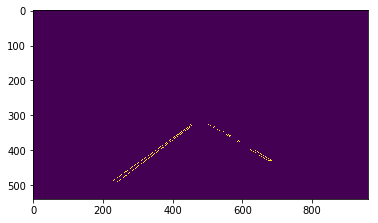

In [306]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_test_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [307]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))